# Covid-19 and the environment, a statistics case study

The purpose of this notebook is to discover potential links between the awareness of the environment and the actual state of the environment around the time of the Covid-19 lockdowns.
- First, we explore the dataset that was given in the problem statement. We merge, filter and prepare the data for further use.
- Then, we present the dataset which we introduced ourselves : more data from Wikipedia (nicknamed "precise wikipedia) the World Air Quality index and the plastics production statistics from Eurostat.
- Then, we analyze the links between wikipedia views with indicator of actual pollution.
- Finally, we present a statistical extrapolation of environment data without Covid and compare it to the actual data, to give an idea of what might have happened if Covid hadn't happened.

# Part 1 : Coronawiki

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
import copy
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
from dtw import dtw,accelerated_dtw
from statsmodels.stats import diagnostic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.multitest import fdrcorrection
np.random.seed(0)
np.random.RandomState(0)

RandomState(MT19937) at 0x1A7CA86B488

## Interventions

In this data, each language is mapped to the main country of usage except for English, where the language's usage is very high in multiple countries such that it couldn't be mapped to a single country. As such, for that language, we have most of the data missing.

Per country, the pandemic timeline is represented, such as the first registered case, the first death, etc.

Note that the paper says that nine languages are spoken in a single language, but we have more than that here (reason for that unknown).

In [2]:
interventions = pd.read_csv("Data/interventions.csv")


def transform_column(column_name):
    interventions[column_name] = pd.to_datetime(interventions[column_name])


for intervention in interventions.columns[1:]:
    transform_column(intervention)
interventions

lang   1st case  1st death School closure Public events banned   Lockdown  \
0    fr 2020-01-24 2020-02-14     2020-03-14           2020-03-13 2020-03-17   
1    da 2020-02-27 2020-03-12     2020-03-13           2020-03-12 2020-03-18   
2    de 2020-01-27 2020-03-09     2020-03-14           2020-03-22 2020-03-22   
3    it 2020-01-31 2020-02-22     2020-03-05           2020-03-09 2020-03-11   
4    nl 2020-02-27 2020-03-06     2020-03-11           2020-03-24        NaT   
5    no 2020-02-26 2020-02-26     2020-03-13           2020-03-12 2020-03-24   
6    sr 2020-03-06 2020-03-20     2020-03-15           2020-03-21 2020-03-21   
7    sv 2020-01-31 2020-03-11     2020-03-18           2020-03-12        NaT   
8    ko 2020-01-20 2020-02-20     2020-02-23                  NaT        NaT   
9    ca 2020-01-31 2020-02-13     2020-03-12           2020-03-08 2020-03-14   
10   fi 2020-01-29 2020-03-21     2020-03-16           2020-03-16        NaT   
11   ja 2020-01-16 2020-02-13     2020-02-27           2020-02-25        NaT   
12   en        NaT        NaT            NaT                  NaT        NaT   

     Mobility   Normalcy  
0  2020-03-16 2020-07-02  
1  2020-03-11 2020-06-05  
2  2020-03-16 2020-07-10  
3  2020-03-11 2020-06-26  
4  2020-03-16 2020-05-29  
5  2020-03-11 2020-06-04  
6  2020-03-16 2020-05-02  
7  2020-03-11 2020-06-05  
8  2020-02-25 2020-04-15  
9  2020-03-16        NaT  
10 2020-03-16 2020-05-21  
11 2020-03-31 2020-06-14  
12 2020-03-16 2020-05-21

## Timeseries <a id='timeseries'></a>

The most important data we have in this dataset are time series of the Wikipedia views from 2018 to July 2020 for 14 different languages: one part are the total views for all of that language's wikipedia, a second part are the views for the articles that are related to Covid-19, as well as the percentage. Finally, we also have for the same window of time the views for different topics.

In [3]:
timeseries = pd.read_json("Data/aggregated_timeseries.json.gz")
timeseries.head()

ja.m  \
len                                               1197788   
sum     {'2018-01-01 00:00:00': 22328288, '2018-01-02 ...   
covid   {'len': 30, 'sum': {'2018-01-01 00:00:00': 55,...   
topics  {'Culture.Biography.Biography*': {'len': 14904...   

                                                       it  \
len                                               1594039   
sum     {'2018-01-01 00:00:00': 3338750, '2018-01-02 0...   
covid   {'len': 33, 'sum': {'2018-01-01 00:00:00': 50,...   
topics  {'Culture.Biography.Biography*': {'len': 29427...   

                                                     da.m  \
len                                                256451   
sum     {'2018-01-01 00:00:00': 765123, '2018-01-02 00...   
covid   {'len': 4, 'sum': {'2018-01-01 00:00:00': 0, '...   
topics  {'Culture.Biography.Biography*': {'len': 57720...   

                                                       tr  \
len                                                346007   
sum     {'2018-01-01 00:00:00': 407629, '2018-01-02 00...   
covid   {'len': 64, 'sum': {'2018-01-01 00:00:00': 1, ...   
topics  {'Culture.Biography.Biography*': {'len': 70443...   

                                                     no.m  \
len                                                516838   
sum     {'2018-01-01 00:00:00': 715031, '2018-01-02 00...   
covid   {'len': 10, 'sum': {'2018-01-01 00:00:00': 7, ...   
topics  {'Culture.Biography.Biography*': {'len': 11603...   

                                                       en  \
len                                               6047509   
sum     {'2018-01-01 00:00:00': 86763830, '2018-01-02 ...   
covid   {'len': 306, 'sum': {'2018-01-01 00:00:00': 57...   
topics  {'Culture.Biography.Biography*': {'len': 14038...   

                                                       sr  \
len                                                632128   
sum     {'2018-01-01 00:00:00': 192409, '2018-01-02 00...   
covid   {'len': 9, 'sum': {'2018-01-01 00:00:00': 6, '...   
topics  {'Culture.Biography.Biography*': {'len': 37718...   

                                                     tr.m  \
len                                                345790   
sum     {'2018-01-01 00:00:00': 493684, '2018-01-02 00...   
covid   {'len': 64, 'sum': {'2018-01-01 00:00:00': 3, ...   
topics  {'Culture.Biography.Biography*': {'len': 70434...   

                                                     en.m  \
len                                               6045654   
sum     {'2018-01-01 00:00:00': 135822131, '2018-01-02...   
covid   {'len': 306, 'sum': {'2018-01-01 00:00:00': 91...   
topics  {'Culture.Biography.Biography*': {'len': 14038...   

                                                       no  ...  \
len                                                531478  ...   
sum     {'2018-01-01 00:00:00': 224417, '2018-01-02 00...  ...   
covid   {'len': 10, 'sum': {'2018-01-01 00:00:00': 2, ...  ...   
topics  {'Culture.Biography.Biography*': {'len': 11804...  ...   

                                                     ko.m  \
len                                                489181   
sum     {'2018-01-01 00:00:00': 1484496, '2018-01-02 0...   
covid   {'len': 113, 'sum': {'2018-01-01 00:00:00': 6,...   
topics  {'Culture.Biography.Biography*': {'len': 75406...   

                                                     fi.m  \
len                                                480638   
sum     {'2018-01-01 00:00:00': 1319053, '2018-01-02 0...   
covid   {'len': 9, 'sum': {'2018-01-01 00:00:00': 0, '...   
topics  {'Culture.Biography.Biography*': {'len': 10422...   

                                                     sr.m  \
len                                                396063   
sum     {'2018-01-01 00:00:00': 451383, '2018-01-02 00...   
covid   {'len': 9, 'sum': {'2018-01-01 00:00:00': 11, ...   
topics  {'Culture.Biography.Biography*': {'len': 37580...   

                                                  

In [4]:
timeseries.columns

Index(['ja.m', 'it', 'da.m', 'tr', 'no.m', 'en', 'sr', 'tr.m', 'en.m', 'no',
       'sv', 'nl.m', 'nl', 'da', 'de', 'fr.m', 'ca.m', 'de.m', 'ko.m', 'fi.m',
       'sr.m', 'ja', 'fr', 'fi', 'ca', 'it.m', 'sv.m', 'ko'],
      dtype='object')

In [5]:
languages_unique = timeseries.columns.map(lambda x: x[:2]).unique()

Correspondence:
- ja -> Japanese
- it -> Italian
- da -> Danish
- tr -> Turkish
- no -> Norwegian
- en -> English
- sr -> Serbian
- sv -> Swedish
- nl -> Dutch
- de -> German
- fr -> French
- ca -> Catalan
- ko -> Korean
- fi -> Finnish

### Splitting the timeseries data into different dataframes

As we can see, the data's format isn't ideal: for each language, the data is split into 3 Python dictionaries corresponding to the data described above, and it would be nice to separate these pieces of data to be able to read directly for each date, for example, the total number of views accross all languages, instead of having to iterate over each language's dictionnary every time.

This will also make the analysis phase easier later on.

### Total sum of views, views of articles related to Covid

<a id='extractionformat'></a>
In this part of the code we extract two following kind of data, for each date:
- For every language's Wikipedia, the total number of views on that particular date
- For every language's Wikipedia, the total number of views for articles related to Covid-19 on that particular date

---


Every resulting dataframe will have the following format:

| Column name          | Description                                                                                                                                                                                       |   |   |   |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| date           | A particular date between January 2018 (inclusive) and July of 2020 (inclusive)                                                                                                                         |   |   |   |                    
| language       | The corresponding wikipedia language                                                                |   |   |   |
| views  | The number of views (total or only for articles related to Covid-19) for this language and date



---



We also extract another dataframe that simply maps for each language the number of articles that were considered in the original experiment. Finally, a last dataframe which is redundant with the two first ones is present: one which gives for each day the percentage of views that went to Covid related articles.

In [6]:
timeseries_total_sum_dict = {}
timeseries_covid_len_dict = {}
timeseries_covid_sum_dict = {}
timeseries_covid_percent_dict = {}
for cn in timeseries.columns:
    timeseries_total_sum_dict[cn] = timeseries[cn]["sum"]
    timeseries_covid_len_dict[cn] = timeseries[cn]["covid"]["len"]
    timeseries_covid_sum_dict[cn] = timeseries[cn]["covid"]["sum"]
    timeseries_covid_percent_dict[cn] = timeseries[cn]["covid"]["percent"]

In [7]:
sum_data_df = pd.DataFrame.from_dict(timeseries_total_sum_dict, orient="index").T
covid_len_data_df = pd.DataFrame.from_dict(
    timeseries_covid_len_dict, orient="index", columns=["len"]
).T
covid_sum_data_df = pd.DataFrame.from_dict(timeseries_covid_sum_dict, orient="index").T
covid_percent_data_df = pd.DataFrame.from_dict(
    timeseries_covid_percent_dict, orient="index"
).T

In [8]:
# Fuse the .m and the normal columns together, and separate the data
new_sum_data_df = pd.DataFrame()
new_covid_sum_data_df = pd.DataFrame()
for language in languages_unique:
    country_sum_data = pd.DataFrame()
    country_sum_data["views"] = sum_data_df[language] + sum_data_df[language + ".m"]
    country_sum_data["language"] = language
    new_sum_data_df = pd.concat([new_sum_data_df, country_sum_data], axis=0)

    country_covid_sum_data = pd.DataFrame()
    country_covid_sum_data["views"] = (
        covid_sum_data_df[language] + covid_sum_data_df[language + ".m"]
    )
    country_covid_sum_data["language"] = language
    new_covid_sum_data_df = pd.concat(
        [new_covid_sum_data_df, country_covid_sum_data], axis=0
    )

sum_data_df = new_sum_data_df
covid_sum_data_df = new_covid_sum_data_df

In [9]:
sum_data_df.index = covid_sum_data_df.index = pd.to_datetime(sum_data_df.index)
covid_percent_data_df.index = pd.to_datetime(covid_percent_data_df.index)
sum_data_df["date"] = covid_sum_data_df["date"] = sum_data_df.index
covid_percent_data_df["date"] = covid_percent_data_df.index
# covid_sum_data_df = covid_sum_data_df[new_column_order]
# covid_percent_data_df = covid_percent_data_df[new_column_order]

In [10]:
sum_data_df.head()

views language       date
2018-01-01  30156443       ja 2018-01-01
2018-01-02  31038338       ja 2018-01-02
2018-01-03  33628914       ja 2018-01-03
2018-01-04  33870576       ja 2018-01-04
2018-01-05  33481670       ja 2018-01-05

In [11]:
covid_percent_data_df.head()

ja.m        it      da.m        tr      no.m        en  \
2018-01-01  0.000002  0.000015  0.000000  0.000002  0.000010  0.000007   
2018-01-02  0.000002  0.000019  0.000005  0.000007  0.000009  0.000010   
2018-01-03  0.000002  0.000023  0.000002  0.000013  0.000004  0.000010   
2018-01-04  0.000002  0.000019  0.000000  0.000002  0.000004  0.000010   
2018-01-05  0.000003  0.000022  0.000000  0.000000  0.000003  0.000010   

                  sr      tr.m      en.m        no  ...      fi.m      sr.m  \
2018-01-01  0.000031  0.000006  0.000007  0.000009  ...  0.000000  0.000024   
2018-01-02  0.000051  0.000004  0.000008  0.000011  ...  0.000000  0.000043   
2018-01-03  0.000040  0.000004  0.000008  0.000007  ...  0.000008  0.000037   
2018-01-04  0.000022  0.000019  0.000009  0.000002  ...  0.000000  0.000077   
2018-01-05  0.000051  0.000004  0.000008  0.000009  ...  0.000000  0.000087   

                  ja        fr        fi        ca      it.m      sv.m  \
2018-01-01  0.000003  0.000010  0.000004  0.000054  0.000011  0.000008   
2018-01-02  0.000005  0.000010  0.000003  0.000030  0.000015  0.000006   
2018-01-03  0.000005  0.000011  0.000003  0.000048  0.000013  0.000007   
2018-01-04  0.000010  0.000011  0.000005  0.000049  0.000015  0.000008   
2018-01-05  0.000011  0.000012  0.000000  0.000024  0.000010  0.000005   

                  ko       date  
2018-01-01  0.000004 2018-01-01  
2018-01-02  0.000021 2018-01-02  
2018-01-03  0.000019 2018-01-03  
2018-01-04  0.000017 2018-01-04  
2018-01-05  0.000021 2018-01-05  

[5 rows x 29 columns]

### Checking for missing data

Before continuing further, let us check for missing data in the timeseries; this will help us avoid bad surprises later on.

In [12]:
sum_data_df.isnull().any().any(), covid_sum_data_df.isnull().any().any(), covid_percent_data_df.isnull().any().any()

(False, False, True)

There appears to be some missing data in the percentage dataframe; let's check by language where that missing data is reported.

In [13]:
missing_data_language = covid_percent_data_df.isnull().any(axis=0)
missing_data_language[missing_data_language]

sv    True
dtype: bool

Looking at the paper, this corresponds to Swedish.

In [14]:
# Decomment Run this cell if you want to see how the missing data can be seen in the original timeseries
# timeseries.loc[:,'sv']['sum']

It appears that, for desktop devices, the views for the Swedish Wikipedia haven't been collected for the whole year 2018. The reason for that is unknown, as a quick search tells us that this version has existed since 2001. The mobile data, however, is available. We will need to take this into account when doing our analysis in the future, for example by not taking into account 2018.

### Topics data

Now we will extract for each language, all the views per topic in such a way that the data becomes more usable. In the original data, all topic-related information was in a single dictionnary; we're gonna separate them in a way that each column will correspond to a different topic, with each row being a different language.

In [15]:
country_to_topics = {}
for cn in timeseries.columns:
    country_to_topics[cn] = timeseries[cn]["topics"]
topics_df = pd.DataFrame.from_dict(country_to_topics, orient="index")

In [16]:
countries_to_topics_len = {}
countries_to_topics_sum = {}
countries_to_topics_percent = {}
for country in topics_df.index:
    countries_to_topics_len[country] = {}
    countries_to_topics_sum[country] = {}
    countries_to_topics_percent[country] = {}
    for topic in topics_df.columns:
        countries_to_topics_len[country][topic] = topics_df.loc[country, topic]["len"]
        countries_to_topics_sum[country][topic] = topics_df.loc[country, topic]["sum"]
        countries_to_topics_percent[country][topic] = topics_df.loc[country, topic][
            "percent"
        ]
countries_to_topics_len_df = pd.DataFrame.from_dict(
    countries_to_topics_len, orient="index"
)
countries_to_topics_sum_df = pd.DataFrame.from_dict(
    countries_to_topics_sum, orient="index"
)
countries_to_topics_percent_df = pd.DataFrame.from_dict(
    countries_to_topics_percent, orient="index"
)

In [17]:
countries_to_topics_sum_df.head()

Culture.Biography.Biography*  \
ja.m  {'2018-01-01 00:00:00': 6629234, '2018-01-02 0...   
it    {'2018-01-01 00:00:00': 809879, '2018-01-02 00...   
da.m  {'2018-01-01 00:00:00': 289706, '2018-01-02 00...   
tr    {'2018-01-01 00:00:00': 98424, '2018-01-02 00:...   
no.m  {'2018-01-01 00:00:00': 232404, '2018-01-02 00...   

                                Culture.Biography.Women  \
ja.m  {'2018-01-01 00:00:00': 1462146, '2018-01-02 0...   
it    {'2018-01-01 00:00:00': 193009, '2018-01-02 00...   
da.m  {'2018-01-01 00:00:00': 74001, '2018-01-02 00:...   
tr    {'2018-01-01 00:00:00': 14151, '2018-01-02 00:...   
no.m  {'2018-01-01 00:00:00': 64920, '2018-01-02 00:...   

                                 Culture.Food and drink  \
ja.m  {'2018-01-01 00:00:00': 302934, '2018-01-02 00...   
it    {'2018-01-01 00:00:00': 34632, '2018-01-02 00:...   
da.m  {'2018-01-01 00:00:00': 13610, '2018-01-02 00:...   
tr    {'2018-01-01 00:00:00': 3154, '2018-01-02 00:0...   
no.m  {'2018-01-01 00:00:00': 15889, '2018-01-02 00:...   

                               Culture.Internet culture  \
ja.m  {'2018-01-01 00:00:00': 443986, '2018-01-02 00...   
it    {'2018-01-01 00:00:00': 66037, '2018-01-02 00:...   
da.m  {'2018-01-01 00:00:00': 4361, '2018-01-02 00:0...   
tr    {'2018-01-01 00:00:00': 7279, '2018-01-02 00:0...   
no.m  {'2018-01-01 00:00:00': 5802, '2018-01-02 00:0...   

                                    Culture.Linguistics  \
ja.m  {'2018-01-01 00:00:00': 109480, '2018-01-02 00...   
it    {'2018-01-01 00:00:00': 23304, '2018-01-02 00:...   
da.m  {'2018-01-01 00:00:00': 4238, '2018-01-02 00:0...   
tr    {'2018-01-01 00:00:00': 9300, '2018-01-02 00:0...   
no.m  {'2018-01-01 00:00:00': 7222, '2018-01-02 00:0...   

                                     Culture.Literature  \
ja.m  {'2018-01-01 00:00:00': 2140880, '2018-01-02 0...   
it    {'2018-01-01 00:00:00': 206403, '2018-01-02 00...   
da.m  {'2018-01-01 00:00:00': 28733, '2018-01-02 00:...   
tr    {'2018-01-01 00:00:00': 14074, '2018-01-02 00:...   
no.m  {'2018-01-01 00:00:00': 27984, '2018-01-02 00:...   

                                    Culture.Media.Books  \
ja.m  {'2018-01-01 00:00:00': 97435, '2018-01-02 00:...   
it    {'2018-01-01 00:00:00': 50646, '2018-01-02 00:...   
da.m  {'2018-01-01 00:00:00': 8817, '2018-01-02 00:0...   
tr    {'2018-01-01 00:00:00': 3511, '2018-01-02 00:0...   
no.m  {'2018-01-01 00:00:00': 9003, '2018-01-02 00:0...   

                            Culture.Media.Entertainment  \
ja.m  {'2018-01-01 00:00:00': 238059, '2018-01-02 00...   
it    {'2018-01-01 00:00:00': 86717, '2018-01-02 00:...   
da.m  {'2018-01-01 00:00:00': 13707, '2018-01-02 00:...   
tr    {'2018-01-01 00:00:00': 3366, '2018-01-02 00:0...   
no.m  {'2018-01-01 00:00:00': 9807, '2018-01-02 00:0...   

                                    Culture.Media.Films  \
ja.m  {'2018-01-01 00:00:00': 681533, '2018-01-02 00...   
it    {'2018-01-01 00:00:00': 395631, '2018-01-02 00...   
da.m  {'2018-01-01 00:00:00': 47315, '2018-01-02 00:...   
tr    {'2018-01-01 00:00:00': 10859, '2018-01-02 00:...   
no.m  {'2018-01-01 00:00:00': 27301, '2018-01-02 00:...   

                                   Culture.Media.Media*  ...  \
ja.m  {'2018-01-01 00:00:00': 4264889, '2018-01-02 0...  ...   
it    {'2018-01-01 00:00:00': 1137084, '2018-01-02 0...  ...   
da.m  {'2018-01-01 00:00:00': 269483, '2018-01-02 00...  ...   
tr    {'2018-01-01 00:00:00': 54290, '2018-01-02 00:...  ...   
no.m  {'2018-01-01 00:00:00': 153531, '2018-01-02 00...  ...   

                                         STEM.Computing  \
ja.m  {'2018-01-01 00:00:00': 91338, '2018-01-02 00:...   
it    {'2018-01-01 00:00:00': 41406, '2018-01-02 00:...   
da.m  {'2018-01-01 00:00:00': 2505, '2018-01-02 00:0...   
tr    {'2018-01-01 00:00:00': 7422, '2018-01-02 00:0...   
no.m  {'2018-01-01 00:00:00': 2907, '2018-01-02 00:0...   

                             STEM.Earth and environment  \
ja.m  {'2018-01-01 00:00:00': 724

In [18]:
# Decomment and run this cell to see all available topics.
# countries_to_topics_sum_df.columns

However, we are not be interested in all available topics. As a matter of fact, for our project, it is only useful to isolate the data about articles related to the environment. Examining the columns, the topic is available in only one of them, so we will extract only that topic in two dataframes that have the same format as [here](#extractionformat) (only difference is that we change the name *views* to *environment_views*).

In [19]:
sum_environment_df = countries_to_topics_sum_df["STEM.Earth and environment"]
percent_environment_df = countries_to_topics_percent_df["STEM.Earth and environment"]
country_to_env_data_sum = {}
country_to_env_data_percent = {}
for country in sum_environment_df.index:
    country_to_env_data_sum[country] = sum_environment_df[country]
    country_to_env_data_percent[country] = percent_environment_df[country]
sum_environment_df = pd.DataFrame.from_dict(country_to_env_data_sum, orient="index").T
percent_environment_df = pd.DataFrame.from_dict(
    country_to_env_data_percent, orient="index"
).T
percent_environment_df.index = pd.to_datetime(percent_environment_df.index)

new_sum_environment_df = pd.DataFrame()
for language in languages_unique:
    country_env_sum_data = pd.DataFrame()

    country_env_sum_data["environment_views"] = (
        sum_environment_df[language] + sum_environment_df[language + ".m"]
    )
    country_env_sum_data["language"] = language
    new_sum_environment_df = pd.concat(
        [new_sum_environment_df, country_env_sum_data], axis=0
    )
sum_environment_df = new_sum_environment_df
sum_environment_df.index = pd.to_datetime(sum_environment_df.index)
sum_environment_df["date"] = sum_environment_df.index

In [20]:
sum_environment_df

environment_views language       date
2018-01-01             110497       ja 2018-01-01
2018-01-02             142849       ja 2018-01-02
2018-01-03             162644       ja 2018-01-03
2018-01-04             171022       ja 2018-01-04
2018-01-05             183210       ja 2018-01-05
...                       ...      ...        ...
2020-07-27              16384       fi 2020-07-27
2020-07-28              17269       fi 2020-07-28
2020-07-29              17182       fi 2020-07-29
2020-07-30              15963       fi 2020-07-30
2020-07-31              14373       fi 2020-07-31

[13202 rows x 3 columns]

In [21]:
# Not really useful piece of data
percent_environment_df.head()

ja.m        it      da.m        tr      no.m        en  \
2018-01-01  0.001414  0.002589  0.001947  0.003699  0.003708  0.003689   
2018-01-02  0.002001  0.003256  0.003672  0.003400  0.004326  0.003676   
2018-01-03  0.002074  0.003413  0.004139  0.003760  0.004906  0.003920   
2018-01-04  0.002029  0.003580  0.004273  0.003828  0.005288  0.004073   
2018-01-05  0.002136  0.003422  0.003925  0.003457  0.004078  0.003883   

                  sr      tr.m      en.m        no  ...      ko.m      fi.m  \
2018-01-01  0.002651  0.002373  0.002359  0.005613  ...  0.001663  0.003341   
2018-01-02  0.003157  0.002486  0.002764  0.007101  ...  0.002024  0.004122   
2018-01-03  0.003244  0.003047  0.003071  0.008214  ...  0.001953  0.004057   
2018-01-04  0.003960  0.003057  0.003305  0.008870  ...  0.002090  0.004323   
2018-01-05  0.003787  0.002363  0.002930  0.008315  ...  0.002155  0.003987   

                sr.m        ja        fr        fi        ca      it.m  \
2018-01-01  0.001607  0.002296  0.003844  0.004212  0.009242  0.001771   
2018-01-02  0.002492  0.002560  0.004250  0.005175  0.011023  0.002220   
2018-01-03  0.002561  0.002667  0.004465  0.005038  0.011034  0.002311   
2018-01-04  0.004285  0.003049  0.004455  0.005400  0.011972  0.002481   
2018-01-05  0.003053  0.003345  0.004351  0.005054  0.010285  0.002330   

                sv.m        ko  
2018-01-01  0.003260  0.002914  
2018-01-02  0.003829  0.002810  
2018-01-03  0.004315  0.003077  
2018-01-04  0.004363  0.003090  
2018-01-05  0.003549  0.003026  

[5 rows x 28 columns]

### Plots

In the following part, we save the following type of plots:

- per language on Wikipedia, three separate line plots showing the evolution of the total number of views, the number of views of articles related to Covid-19, and the number of views of environment articles.
- per language on Wikipedia, three separate histograms representing the number of views per day, for the same categories as in the point above.

These plots can be found in the 'Figures' folder that will be created after the launch of all cells in this part, but we will plot some examples in the notebook to try and detect some patterns.

In [22]:
figures_path = "./Figures/"
timeseries_path = "timeseries/"
hists_path = "hists/"
total_views_path = "all_views/"
covid_views_path = "covid_views/"
topic_views_path = "topic_views/"


def make_sub_dirs(main_dir):
    os.mkdir(main_dir + total_views_path)
    os.mkdir(main_dir + covid_views_path)
    os.mkdir(main_dir + topic_views_path)
    os.mkdir(main_dir + topic_views_path + total_views_path)
    os.mkdir(main_dir + topic_views_path + covid_views_path)

In [23]:
if not os.path.exists(figures_path):
    os.mkdir(figures_path)
    os.mkdir(figures_path + timeseries_path)
    os.mkdir(figures_path + hists_path)
    make_sub_dirs(figures_path + timeseries_path)
    make_sub_dirs(figures_path + hists_path)

In [24]:
def lineplot_language_views_timeseries(data, country, covid_views=False):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = data[data["language"] == country]
    x = filtered_data.index
    y = filtered_data.views
    g = sns.lineplot(x=x, y=y)
    plt.xticks(fontsize=8)
    g.set(xlabel="Dates")
    if covid_views:
        title = "Wikipedia page views for articles related to Covid-19 for {}".format(
            country
        )
    else:
        title = "Wikipedia page views for {}".format(country)
    g.set(ylabel="Page views", title=title)
    # ax.set(xscale="log")
    if covid_views:
        plt.savefig(figures_path + timeseries_path + covid_views_path + title + ".jpg")
    else:
        plt.savefig(figures_path + timeseries_path + total_views_path + title + ".jpg")
    plt.close(fig)
    # plt.show()

In [25]:
def hist_language_views(data, country, covid_views=False):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = data[data["language"] == country]
    g = sns.histplot(data=filtered_data, x="views", bins=50)
    if covid_views:
        title = (
            "Wikipedia views distribution for articles related to Covid-19 {}".format(
                country
            )
        )
    else:
        title = "Wikipedia views distribution for {}".format(country)
    g.set(title=title)
    if covid_views:
        plt.savefig(figures_path + hists_path + covid_views_path + title + ".jpg")
    else:
        plt.savefig(figures_path + hists_path + total_views_path + title + ".jpg")

    plt.close(fig)

In [26]:
for country_code in sum_data_df.language.unique():
    lineplot_language_views_timeseries(sum_data_df, country_code)
    hist_language_views(sum_data_df, country_code)
    lineplot_language_views_timeseries(covid_sum_data_df, country_code, True)
    hist_language_views(covid_sum_data_df, country_code, True)

In [27]:
def lineplot_topic_views_timeseries(
    topic_data, country, covid_views=False, topic="environment"
):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = topic_data[topic_data["language"] == country]
    x = filtered_data.index
    y = filtered_data.environment_views
    g = sns.lineplot(x=x, y=y)
    plt.xticks(fontsize=8)
    g.set(xlabel="Dates")
    if covid_views:
        title = "Wikipedia page views for articles related to Covid-19 for {0} for the {1} topic".format(
            country, topic
        )
    else:
        title = "Wikipedia page views for {0} for the {1} topic".format(country, topic)
    g.set(ylabel="Page views", title=title)
    if covid_views:
        plt.savefig(
            figures_path
            + timeseries_path
            + topic_views_path
            + covid_views_path
            + title
            + ".jpg"
        )
    else:
        plt.savefig(
            figures_path
            + timeseries_path
            + topic_views_path
            + total_views_path
            + title
            + ".jpg"
        )

    plt.close(fig)

In [28]:
def hist_topic_views(topic_data, country, covid_views=False, topic="environment"):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = topic_data[topic_data["language"] == country]
    g = sns.histplot(data=filtered_data, x="environment_views", bins=50)
    if covid_views:
        title = "Wikipedia views distribution for articles related to Covid-19 for {0} for the {1} topic".format(
            country, topic
        )
    else:
        title = "Wikipedia views distribution for {0} for the {1} topic".format(
            country, topic
        )
    g.set(title=title)
    if covid_views:
        plt.savefig(
            figures_path
            + hists_path
            + topic_views_path
            + covid_views_path
            + title
            + ".jpg"
        )
    else:
        plt.savefig(
            figures_path
            + hists_path
            + topic_views_path
            + total_views_path
            + title
            + ".jpg"
        )

    plt.close(fig)

In [29]:
for country_code in sum_environment_df.language.unique():
    lineplot_topic_views_timeseries(sum_environment_df, country_code)
    hist_topic_views(sum_environment_df, country_code)

Let us plot some of the environment views timeseries here, to try and see if some interesting patterns can be seen already. We will choose the Serbian and Danish languages for this part. Note that we're not comparing the values themselves but whether or not there are patterns in either of them, so sharing the y-axis isn't really needed here.

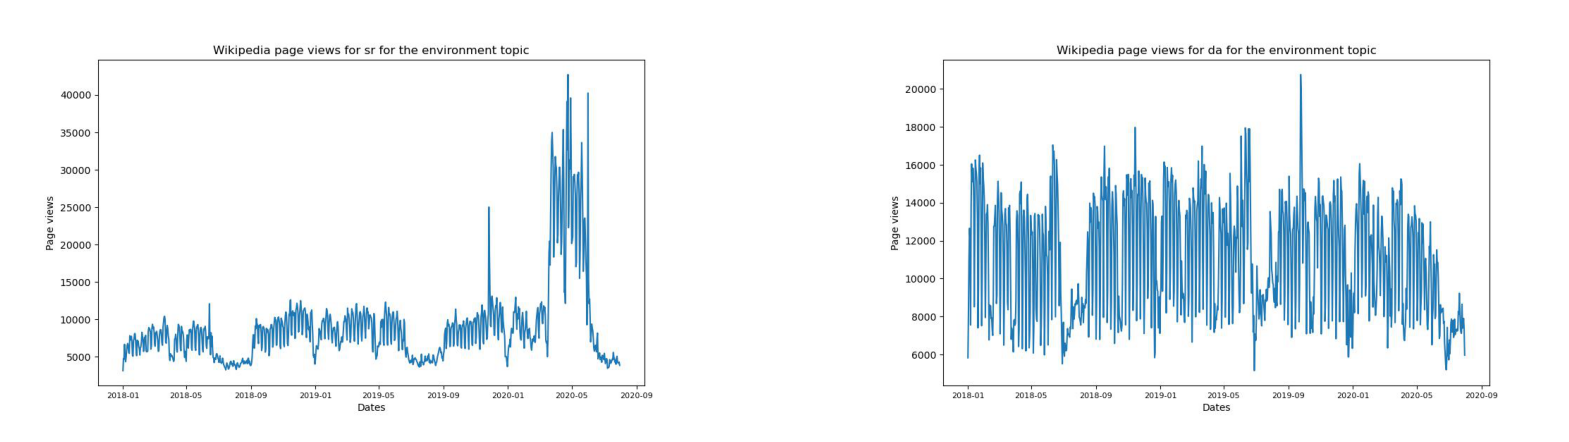

In [30]:
countries_chosen = ["sr", "da"]
fig, ax = plt.subplots(nrows=1, ncols=len(countries_chosen), figsize=(20, 10), dpi=100)
for i in range(len(countries_chosen)):
    filename = "Wikipedia page views for {} for the environment topic.jpg".format(
        countries_chosen[i]
    )
    ax[i].imshow(
        plt.imread(fname="./Figures/timeseries/topic_views/all_views/" + filename)
    )
    ax[i].axis("off")
# _ = plt.axis('off')

We can see a slight difference in behavior between these languages around the beginning of 2020:
- first, we can see that while the environment views are pretty low before 2020 for the serbian wikipedia, these views go up quickly around the end of March 2020, which when looking at the intervention data seems to coincide with the first serbian lockdown. It is still a bit early however to affirm that one of these elements caused the other.
- moving to the danish wikipedia however, there doesn't seem to be a particular rise or fall in the number of environment views.

We can also see however that for both languages, there seems to be a pattern of evolution of views between the years: for serbian, there is clear decrease between June and Septembre of both 2018 and 2019, which seems to have happened in 2020 as well if we look at the left plot. For danish the same phenomena can be observed as well, this time between July and August of both 2018 and 2019; again, this seems to have happened in 2020 as well if we were to look at the right plot. Looking at the other languages, patterns can also be found accross years.

It appears that indeed, the number of views for environmental articles did change in the same timeframe as when Covid-19 first arrived in some of the countries. It's equally important, however, to state that some don't display a change in pattern, and that at this point in the analysis **we can't say** that Covid-19 indeed caused more or less environment awareness on Wikipedia.

### Statistically testing if there was indeed a difference between 2019 and 2020 <a id='firststat'></a>

Let us now do another, more statistical analysis; we will test the hypothesis that, in average, and for every language, the average number of environmental views is the same between 2019 (pre-Covid) and 2020 (during the first, biggest wave of Covid). We will test these hypotheses using the $\alpha = 0.05 $ significance level, as well as using the Bonferonni correction $\alpha_{c} = \frac{\alpha}{n}$, with n = 14 .

We match the same dates between 2019 and 2020 (up to the 31st of July, as that's when the Coronawiki data ends) for every language, and conduct a t-test for the null hypothesis described above. Note that we consider the samples to be related, as they come from the same language and for the same range of dates. In this setup, a negative t-statistic means that for that language, there are more environment views on average in 2020, and vice-versa.

In [31]:
before_covid_env_topic_views = sum_environment_df[
    (sum_environment_df.date < "2020-01-01") & (sum_environment_df.date >= "2019-01-01")
]
during_covid_env_topic_views = sum_environment_df[
    sum_environment_df.date >= "2020-01-01"
]
for language in sum_environment_df.language.unique():
    language_before = before_covid_env_topic_views[
        before_covid_env_topic_views.language == language
    ].copy()
    language_during = during_covid_env_topic_views[
        during_covid_env_topic_views.language == language
    ].copy()

    language_before.date = language_before.date.apply(
        lambda date: str(date.month) + "-" + str(date.day)
    )
    language_during.date = language_during.date.apply(
        lambda date: str(date.month) + "-" + str(date.day)
    )
    matching = pd.merge(
        language_before,
        language_during,
        on=["date", "language"],
        suffixes=["_before", "_during"],
    )
    stat, pvalue = stats.ttest_rel(
        matching["environment_views_before"], matching["environment_views_during"]
    )
    print("p-value for {0}: {1}".format(language, pvalue))
    if pvalue >= 0.05:
        print("Don't reject null when alpha = 0.05")
    if pvalue >= (0.05 / 14):
        print("Don't reject null when using the banferoni correction")
    print("Ttest statistic value for {0}: {1}".format(language, stat))
    print("------------------")

p-value for ja: 8.674434578237681e-12
Ttest statistic value for ja: -7.231241414327632
------------------
p-value for it: 0.002239652239545297
Ttest statistic value for it: -3.094339981709228
------------------
p-value for da: 8.548804022807578e-09
Ttest statistic value for da: 5.998519188316964
------------------
p-value for tr: 1.314393887625464e-36
Ttest statistic value for tr: -15.476728178676694
------------------
p-value for no: 0.0003371702009370404
Ttest statistic value for no: 3.644641980122951
------------------
p-value for en: 5.111120077771199e-05
Ttest statistic value for en: 4.135571195327151
------------------
p-value for sr: 2.5049354455646286e-18
Ttest statistic value for sr: -9.596560924740071
------------------
p-value for sv: 3.0797434434976986e-10
Ttest statistic value for sv: 6.610574204066698
------------------
p-value for nl: 0.4461336381813529
Don't reject null when alpha = 0.05
Don't reject null when using the banferoni correction
Ttest statistic value for nl:

It appears that for 11 out of 14 languages, there is indeed a change in how people visit these pages; the null hypothesis is rejected even after applying the Bonferonni correction, seeing how small their p-values are.. Out of these 11 languages, 6 observe a negative t-statistic, i.e. an average increase in 2020, while the other 5 observe a positive t-statistic, i.e an average decrease in 2020.

## Mobility data

The second type of data we have are mobility data that come from two different sources. The first one is from Apple, who stopped giving out the data in April 2022, and the second one is from Google, which is still available, and more up-to-date (17th of October).

### Apple mobility

In [32]:
apple_mobility = pd.read_csv("Data/applemobilitytrends-2020-04-20.csv.gz")
apple_mobility.head()

geo_type     region transportation_type  2020-01-13  2020-01-14  \
0  country/region    Albania             driving         100       95.30   
1  country/region    Albania             walking         100      100.68   
2  country/region  Argentina             driving         100       97.07   
3  country/region  Argentina             walking         100       95.11   
4  country/region  Australia             driving         100      102.98   

   2020-01-15  2020-01-16  2020-01-17  2020-01-18  2020-01-19  ...  \
0      101.43       97.20      103.55      112.67      104.83  ...   
1       98.93       98.46      100.85      100.13       82.13  ...   
2      102.45      111.21      118.45      124.01       95.44  ...   
3      101.37      112.67      116.72      114.14       84.54  ...   
4      104.21      108.63      109.08       89.00       99.35  ...   

   2020-04-11  2020-04-12  2020-04-13  2020-04-14  2020-04-15  2020-04-16  \
0       25.47       24.89       32.64       31.43       30.67       30.00   
1       27.63       29.59       35.52       38.08       35.48       39.15   
2       19.40       12.89       21.10       22.29       23.55       24.40   
3       15.75       10.45       16.35       16.66       17.42       18.18   
4       26.95       31.72       53.14       55.91       56.56       58.77   

   2020-04-17  2020-04-18  2020-04-19  2020-04-20  
0       29.26       22.94       24.55       31.51  
1       34.58       27.76       27.93       36.72  
2       27.17       23.19       14.54       26.67  
3       18.80       17.03       10.59       18.44  
4       47.51       36.90       53.34       56.93  

[5 rows x 102 columns]

In [33]:
print(apple_mobility.transportation_type.unique())  # Three types of transportation
print(apple_mobility.geo_type.unique())  # Granularity

['driving' 'walking' 'transit']
['country/region' 'city']


The mobility data from Apple we have begins in mid-January 2020, and ends that same year in April. This isn't a big time window, and it doesn't appear that there is earlier data as it has been collected specifically for Covid-19 mobility tracking.

Three types of transportation have been tracked here: driving, walking, and transit. We also have two different granularities about the collected data: either country/world region level, or city level, which are often country capitals.

Per day and region, we have the pourcentage of the usage of every transportation mode according to some pre-pandemic baseline computed in early 2020.

In [34]:
apple_mobility.isnull().any().any()  # There doesn't appear to be null data, but verifying shows that some countries don't have all the transportation types (transit, mostly)

False

In [35]:
# Convert dates strings to date times
time_columns = pd.to_datetime(apple_mobility.columns[3:])
apple_mobility.columns = apple_mobility.columns[:3].append(time_columns)

### Global mobility from Google

In [36]:
global_mobility_report = pd.read_csv("Data/Global_Mobility_Report.csv.gz")

D:\Miniconda\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [37]:
print(
    min(global_mobility_report.date.unique()), max(global_mobility_report.date.unique())
)
global_mobility_report.date = pd.to_datetime(global_mobility_report.date)

2020-02-15 2020-08-25


The mobility data from Google we have begins in mid-February 2020, and ends that same year in August. This is more than the given Apple data, despite the fact that both collections happened in the context of Covid-19.

There are more levels of granularity with this data: for example, for the United Arab Emirates, we might simply talk about the whole country, or it could be specified in the column *sub_region_1* that the row is actually focused on the city of Abu Dhabi. This granularity can be made finer with *sub_region_2*.

Per day and region, we have the **difference** in pourcentage usage of various location types (workplaces, etc) according to some pre-pandemic baseline computed in the early weeks of 2020. The baseline was computed *per day* , as people can have different behaviors depending on whether it's the weekend or not.

In [38]:
global_mobility_report.isnull().sum() / global_mobility_report.shape[0]

country_region_code                                   0.000709
country_region                                        0.000000
sub_region_1                                          0.018154
sub_region_2                                          0.180897
metro_area                                            0.994122
iso_3166_2_code                                       0.813653
census_fips_code                                      0.762436
date                                                  0.000000
retail_and_recreation_percent_change_from_baseline    0.363799
grocery_and_pharmacy_percent_change_from_baseline     0.373900
parks_percent_change_from_baseline                    0.536971
transit_stations_percent_change_from_baseline         0.502960
workplaces_percent_change_from_baseline               0.050385
residential_percent_change_from_baseline              0.499080
dtype: float64

As expected, we have more coarse grained data (no missing data) than finer grained (many sub_region_1 fields are null, and even more sub_region_2 as well). The metropolitan area is very rarely defined, as almost 99.4% of the field is empty values.

Looking at the differences from baseline, we remark scarcity as well; apart from workplace locations which has a missing rate of only around 5.04%, others go from 36.4% (for retail) to 53.7% (for parks).

We can look in more details at the entries which have the missing values for the differences from baseline; let's check the intersection of these missing values, to see for example if the absence of one field implies the absence of the others.

In [39]:
retail_missing = (
    global_mobility_report.retail_and_recreation_percent_change_from_baseline.isnull()
)
grocery_pharmecy_missing = (
    global_mobility_report.grocery_and_pharmacy_percent_change_from_baseline.isnull()
)
park_missing = global_mobility_report.parks_percent_change_from_baseline.isnull()
transit_stations_missing = (
    global_mobility_report.transit_stations_percent_change_from_baseline.isnull()
)
workplace_missing = (
    global_mobility_report.workplaces_percent_change_from_baseline.isnull()
)
residential_missing = (
    global_mobility_report.residential_percent_change_from_baseline.isnull()
)

In [40]:
all_missing = (
    retail_missing
    & grocery_pharmecy_missing
    & park_missing
    & transit_stations_missing
    & workplace_missing
    & residential_missing
)

In [41]:
all_missing.any()

False

From the above result, we can conclude that there doesn't appear to be a feature such that if that one is missing, then all the others are missing; this also means that for each entry, there's always at least one feature available.

## Topics

Simply maps each considered article to the topics it is related to. A single article can be mapped to multiple topics. The number of articles per topic can be found in the [timeseries](#timeseries) data.

In [42]:
# loading the data takes a lot of time, so decomment if you want to run this cell.
# topics_linked = pd.read_csv("topics_linked.csv.xz")
# topics_linked

## Regression Analysis

The statistical testing [here](#firststat) showed us that indeed, there was a difference in environment views between 2019 and 2020. However, some questions remain: 
- are these differences correlated with the rest of the Coronawiki data, such as precise mobility changes (walking, driving, etc)?
- can we explain how these views evolve depending on different time periods for each language?

In order to answer these questions, we will proceed with two different regression analyses, both trying to explain the logarithm of the environment views. We are taking the logarithm because the range of pageviews vary greatly between languages. This also makes the models multiplicative, making comparaison easier between languages (a coefficient will now correspond to a multiplicative effect on the page views). The two regression models used are the following:
- first, we will try to see if using mainly the mobility data alone (without the context of a time period) is enough to explain the (log)pageviews. There isn't a concept of treatment or control group here, it is simply a regression task.
- the second model used is more refined: here, we take two different time periods (based on the mobility data) over 2019 and 2020, effectively creating a treatment and control group according to the time period, to see if we can detect a shift in pageviews volume based on the year and the time periods. More details will be given in the [second subsection](#diffndiff)

In [43]:
sum_environment_df['log_pages_views'] = np.log(sum_environment_df.environment_views)

### First regression: using the mobility data

#### Data merging

The data preparation phase in the first regression is more intensive as in the second, as we have to merge/standardize the format of multiple dataframes.

First of all, let us keep from both mobility datasets only the countries that were considered in the original timeseries. We mapped the english language to Washington DC, the catalan language to Barcelona, and the Korean language both to Seoul and South Korea.

In [44]:
country_to_wiki_code = {
    "Japan": "ja",
    "Italy": "it",
    "Denmark": "da",
    "Turkey": "tr",
    "Norway": "no",
    "Serbia": "sr",
    "Sweden": "sv",
    "Netherlands": "nl",
    "Germany": "de",
    "France": "fr",
    "Barcelona": "ca",
    "South Korea": "ko",
    "Finland": "fi",
    "District of Columbia": "en",
    "Washington DC": "en",
    "Seoul": "ko",
}

In [45]:
def map_countries_to_fine_grained(x):
    if x == "Spain":
        return "ca"
    if x == "United States":
        return "en"
    if x == "Seoul":
        return "ko"
    return country_to_wiki_code[x]


filtered_global_mobility_report = global_mobility_report[
    global_mobility_report["country_region"].isin(country_to_wiki_code)
    | global_mobility_report["sub_region_1"].isin(country_to_wiki_code)
    | global_mobility_report["sub_region_2"].isin(country_to_wiki_code)
].copy()
filtered_global_mobility_report.loc[
    :, "country_region_code"
] = filtered_global_mobility_report.country_region.apply(
    lambda x: map_countries_to_fine_grained(x)
)
filtered_global_mobility_report.index = range(len(filtered_global_mobility_report))
filtered_global_mobility_report.country_region.unique()  # There is data about all countries

array(['Germany', 'Denmark', 'Spain', 'Finland', 'France', 'Italy',
       'Japan', 'South Korea', 'Netherlands', 'Norway', 'Serbia',
       'Sweden', 'Turkey', 'United States'], dtype=object)

In [46]:
def add_global_mobility_language_info(cities_global_mobility_report, granularity, place, is_ankara = False):
    if not(is_ankara):
        return pd.concat(\
        [
            cities_global_mobility_report,
            filtered_global_mobility_report[
                filtered_global_mobility_report[granularity] == place
            ]
        ])
    return pd.concat(\
        [
            cities_global_mobility_report,
            filtered_global_mobility_report[
                (filtered_global_mobility_report[granularity] == place) & (filtered_global_mobility_report["sub_region_2"].isnull())
            ]
        ])

In [47]:
cities_global_mobility_report = pd.DataFrame()
zipped = [("sub_region_1", 'Tokyo'), ("sub_region_2", 'Copenhagen Municipality'), ("sub_region_1", 'Berlin'), ("sub_region_1", 'Oslo'), ("sub_region_2", 'Barcelona'),
          ("sub_region_2", 'Helsinki'), ("sub_region_2", 'Paris'), ("sub_region_2", 'Metropolitan City of Rome'), ("metro_area", 'Seoul Metropolitan Area'),
          ("sub_region_2", 'Government of Amsterdam'), ("metro_area", 'Belgrade Metropolitan Area'), ("sub_region_2", 'Stockholm Municipality'), 
          ("sub_region_1", 'Ankara'), ("sub_region_2", 'Barcelona'), ("sub_region_1", 'District of Columbia')]

for pair in zipped:
    if pair[1] == 'Ankara':
        cities_global_mobility_report = add_global_mobility_language_info(cities_global_mobility_report, pair[0], 'Ankara', True)
    else:
        cities_global_mobility_report = add_global_mobility_language_info(cities_global_mobility_report, pair[0], pair[1])
cities_global_mobility_report = cities_global_mobility_report[
    [
        "country_region_code",
        "date",
        "retail_and_recreation_percent_change_from_baseline",
        "grocery_and_pharmacy_percent_change_from_baseline",
        "parks_percent_change_from_baseline",
        "transit_stations_percent_change_from_baseline",
        "workplaces_percent_change_from_baseline",
        "residential_percent_change_from_baseline",
    ]
]
cities_global_mobility_report = cities_global_mobility_report.rename(
    columns={"country_region_code": "language"}
).copy()

In [48]:
filtered_apple_mobility = apple_mobility[
    apple_mobility["region"].isin(country_to_wiki_code)
].copy()
print(filtered_apple_mobility.region.unique())
print("-----")
filtered_apple_mobility.region = filtered_apple_mobility.region.apply(
    lambda x: country_to_wiki_code[x]
)
filtered_apple_mobility.head()

['Denmark' 'Finland' 'France' 'Germany' 'Italy' 'Japan' 'Netherlands'
 'Norway' 'Serbia' 'Sweden' 'Turkey' 'Barcelona' 'Seoul' 'Washington DC']
-----


geo_type region transportation_type  2020-01-13 00:00:00  \
31  country/region     da             driving                  100   
32  country/region     da             transit                  100   
33  country/region     da             walking                  100   
39  country/region     fi             driving                  100   
40  country/region     fi             transit                  100   

    2020-01-14 00:00:00  2020-01-15 00:00:00  2020-01-16 00:00:00  \
31               103.67               105.55               104.16   
32                98.09                98.22                99.55   
33                99.31               104.04               107.99   
39               102.42               105.41               104.46   
40                98.58                99.52               101.67   

    2020-01-17 00:00:00  2020-01-18 00:00:00  2020-01-19 00:00:00  ...  \
31               110.40               105.47               103.52  ...   
32               111.53               108.82               102.06  ...   
33               131.40               126.32                96.40  ...   
39               117.78               120.16               112.58  ...   
40               104.50               101.66                98.45  ...   

    2020-04-11 00:00:00  2020-04-12 00:00:00  2020-04-13 00:00:00  \
31                71.32                71.54                73.58   
32                32.59                34.40                35.26   
33                65.98                69.45                60.65   
39                76.06                54.91                74.72   
40                34.02                32.26                41.28   

    2020-04-14 00:00:00  2020-04-15 00:00:00  2020-04-16 00:00:00  \
31                77.88                80.32                82.37   
32                34.36                37.09                37.28   
33                66.49                70.92                74.24   
39                72.53                75.78                76.80   
40                39.78                39.22                36.50   

    2020-04-17 00:00:00  2020-04-18 00:00:00  2020-04-19 00:00:00  \
31                85.22                80.85                84.05   
32                40.06                38.39                42.40   
33                81.08                82.95                79.49   
39                88.83                87.21                86.59   
40                40.39                37.89                42.44   

    2020-04-20 00:00:00  
31                85.69  
32                41.87  
33                83.64  
39                84.52  
40                46.86  

[5 rows x 102 columns]

In [49]:
new_apple_mobility = pd.DataFrame()
for language in sum_data_df.language.unique():
    tmp = (
        filtered_apple_mobility[filtered_apple_mobility["region"] == language]
        .T.iloc[2:]
        .copy()
    )
    tmp.columns = tmp.iloc[0]
    tmp = tmp.iloc[1:]
    tmp["language"] = language
    tmp["date"] = tmp.index
    new_apple_mobility = pd.concat([new_apple_mobility, tmp], axis=0)

tmp_merge1 = sum_data_df.merge(new_apple_mobility, on=["language", "date"])
tmp_merge2 = tmp_merge1.merge(sum_environment_df, on=["language", "date"])
final_merge = tmp_merge2.merge(cities_global_mobility_report, on=["date", "language"])
final_merge[["driving", "transit", "walking"]] = final_merge[
    ["driving", "transit", "walking"]
].astype(np.float64)

In [50]:
final_merge.head()

views language       date  driving  transit  walking  environment_views  \
0  32829116       ja 2020-02-15   131.54   128.41   138.76             152200   
1  37797411       ja 2020-02-16   114.42   114.64   119.97             174462   
2  34293756       ja 2020-02-17   111.43   112.88   122.20             203263   
3  32288981       ja 2020-02-18   111.19   112.02   122.62             190820   
4  31509643       ja 2020-02-19   112.58   112.54   124.25             192859   

   log_pages_views  retail_and_recreation_percent_change_from_baseline  \
0        11.932951                                               -2.0    
1        12.069462                                              -13.0    
2        12.222256                                               -4.0    
3        12.159086                                               -2.0    
4        12.169715                                               -4.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                5.0   
1                                               -9.0   
2                                                3.0   
3                                                3.0   
4                                                2.0   

   parks_percent_change_from_baseline  \
0                                 9.0   
1                               -37.0   
2                                -2.0   
3                                 3.0   
4                                 8.0   

   transit_stations_percent_change_from_baseline  \
0                                            1.0   
1                                           -9.0   
2                                           -1.0   
3                                           -3.0   
4                                           -5.0   

   workplaces_percent_change_from_baseline  \
0                                      4.0   
1                                     -1.0   
2                                      1.0   
3                                      0.0   
4                                     -1.0   

   residential_percent_change_from_baseline  
0                                       1.0  
1                                       3.0  
2                                       0.0  
3                                       1.0  
4                                       1.0

There is still some null data however, so we have to manage these features, either with interpolation or filling these values with the mean of the corresponding countries.

In [51]:
final_merge.isnull().any()

views                                                 False
language                                              False
date                                                  False
driving                                               False
transit                                                True
walking                                               False
environment_views                                     False
log_pages_views                                       False
retail_and_recreation_percent_change_from_baseline    False
grocery_and_pharmacy_percent_change_from_baseline      True
parks_percent_change_from_baseline                    False
transit_stations_percent_change_from_baseline         False
workplaces_percent_change_from_baseline               False
residential_percent_change_from_baseline              False
dtype: bool

In [52]:
final_merge[final_merge.transit.isnull()].groupby("language").count()

views  date  driving  transit  walking  environment_views  \
language                                                              
ko           66    66       66        0       66                 66   
sr           66    66       66        0       66                 66   
tr           66    66       66        0       66                 66   

          log_pages_views  retail_and_recreation_percent_change_from_baseline  \
language                                                                        
ko                     66                                                 66    
sr                     66                                                 66    
tr                     66                                                 66    

          grocery_and_pharmacy_percent_change_from_baseline  \
language                                                      
ko                                                       66   
sr                                                       66   
tr                                                       66   

          parks_percent_change_from_baseline  \
language                                       
ko                                        66   
sr                                        66   
tr                                        66   

          transit_stations_percent_change_from_baseline  \
language                                                  
ko                                                   66   
sr                                                   66   
tr                                                   66   

          workplaces_percent_change_from_baseline  \
language                                            
ko                                             66   
sr                                             66   
tr                                             66   

          residential_percent_change_from_baseline  
language                                            
ko                                              66  
sr                                              66  
tr                                              66

It appears that transit data from Apple is totally missing for the Korean, Serbian and Turkish parts; as such there is no way to replace them. Let us check for the other feature

In [53]:
final_merge[final_merge.grocery_and_pharmacy_percent_change_from_baseline.isnull()]

views language       date  driving  transit  walking  \
328    988309       no 2020-04-19    86.32    46.41    80.64   
658  35759887       de 2020-04-19    63.82    46.65    75.93   

     environment_views  log_pages_views  \
328              11680         9.365633   
658             301591        12.616827   

     retail_and_recreation_percent_change_from_baseline  \
328                                              -55.0    
658                                              -68.0    

     grocery_and_pharmacy_percent_change_from_baseline  \
328                                                NaN   
658                                                NaN   

     parks_percent_change_from_baseline  \
328                                72.0   
658                                38.0   

     transit_stations_percent_change_from_baseline  \
328                                          -47.0   
658                                          -50.0   

     workplaces_percent_change_from_baseline  \
328                                    -34.0   
658                                    -23.0   

     residential_percent_change_from_baseline  
328                                       8.0  
658                                       7.0

We will simply interpolate these 2 missing values with the nearest value; because it's both on the same day, and that day isn't the last one per language, the nearest value will be one for the same language.

In [54]:
final_merge[["grocery_and_pharmacy_percent_change_from_baseline"]] = final_merge[
    ["grocery_and_pharmacy_percent_change_from_baseline"]
].interpolate(method="nearest")

#### Regression analysis

We can now do regression analysis, with the logarithm of the number of environment views as output, and using the columns of *final_merge* as covariates, to see if we can fit some hyperplane to this data. First, let us transform the categorical language data using dummy variable encoding

In [55]:
final_merge = pd.get_dummies(final_merge, drop_first=True)
final_merge.head()

views       date  driving  transit  walking  environment_views  \
0  32829116 2020-02-15   131.54   128.41   138.76             152200   
1  37797411 2020-02-16   114.42   114.64   119.97             174462   
2  34293756 2020-02-17   111.43   112.88   122.20             203263   
3  32288981 2020-02-18   111.19   112.02   122.62             190820   
4  31509643 2020-02-19   112.58   112.54   124.25             192859   

   log_pages_views  retail_and_recreation_percent_change_from_baseline  \
0        11.932951                                               -2.0    
1        12.069462                                              -13.0    
2        12.222256                                               -4.0    
3        12.159086                                               -2.0    
4        12.169715                                               -4.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                5.0   
1                                               -9.0   
2                                                3.0   
3                                                3.0   
4                                                2.0   

   parks_percent_change_from_baseline  ...  language_fi  language_fr  \
0                                 9.0  ...            0            0   
1                               -37.0  ...            0            0   
2                                -2.0  ...            0            0   
3                                 3.0  ...            0            0   
4                                 8.0  ...            0            0   

   language_it  language_ja  language_ko  language_nl  language_no  \
0            0            1            0            0            0   
1            0            1            0            0            0   
2            0            1            0            0            0   
3            0            1            0            0            0   
4            0            1            0            0            0   

   language_sr  language_sv  language_tr  
0            0            0            0  
1            0            0            0  
2            0            0            0  
3            0            0            0  
4            0            0            0  

[5 rows x 26 columns]

Then, we will normalize the input variables, so that each column has mean 0 and standard deviation 1

In [56]:
all_data_columns = list(final_merge.columns[2:])
all_data_columns.remove("environment_views")
#all_data_columns.remove("year")
all_data_columns.remove("log_pages_views")
for column in all_data_columns:
    final_merge[column] = (
        final_merge[column] - final_merge[column].mean()
    ) / final_merge[column].std()

#final_merge["environment_views"] = (
#    final_merge["environment_views"] - final_merge["environment_views"].mean()
#) / final_merge["environment_views"].std()

In [57]:
formula = ""
for covariate in all_data_columns:
    formula = covariate + "+" + formula


formula = formula[: len(formula) - 1]

First we will use all covariates as predictors, with no interactions between them.

In [58]:
mod = smf.ols(formula="""log_pages_views ~ """ + formula, data=final_merge)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        log_pages_views   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2798.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:54:01   Log-Likelihood:                 206.96
No. Observations:                 792   AIC:                            -373.9
Df Residuals:                     772   BIC:                            -280.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

We're being told in the warnings that there either, there are strong multicollinearity problems, or the design matrix isn't invertible. This might be because of the "dummy variable trap" where, after using dummy encoding, many of the created features can be explained by the others. The condition number is also pretty high, which means that the matrix is easily perturbed by variation in the input data. We will try to fit a different model with less of the dummy variables to see if we can get rid of this issue.

We also use less data points than we have; these correspond to the three languages that don't have the Apple transit data, i.e Turkish, Serbian and Korean. We will first try to get rid of that feature for the next regression analysis

In [59]:
features_to_exclude = [
    "transit", 
]
data_columns = list(set(all_data_columns) - set(features_to_exclude))
formula = ""
for covariate in data_columns:
    formula = covariate + "+" + formula


formula = formula[: len(formula) - 1]
# formula = formula[120:]
# formula = formula[72:]

In [60]:
mod = smf.ols(formula="""log_pages_views ~ """ + formula, data=final_merge)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        log_pages_views   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1921.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:54:01   Log-Likelihood:                 58.265
No. Observations:                 990   AIC:                            -72.53
Df Residuals:                     968   BIC:                             35.22
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Here, we got rid of the Apple transit feature, which makes us able to use all the data points we have. This gets rid of the warning that we used to have, meaning that we don't have multicollinearity problems anymore, and the data matrix is invertible. We can then now try to interpret the model.

The R-squared is nearly the same as before, i.e the part of explained variance is equal to 97.7% . Some of the features are not singificant, as their p-value is bigger than 0.05, so one can try to fit the model without these features.

Looking at the covariates themselves, we see that it is useful to have the language data, as obviously the range of views from one country to another can change significantly as Wikipedia's importance isn't the same everywhere.

From the Apple mobility data, it appears that the remaining features (Walking and driving) aren't statistically significant, and so it may not be suitable to use/interpret them.

For the global mobility, all but one feature (*parks_percent_change_from_baseline*) are statistically significant; however, it is quiet hard to interpret some of them. For example, it makes sense to say that an increase in the use of transit stations results in less environment views (coefficient is -0.2785) as people are using more polluting modes of transportation. Similarly, an increase in how much one stays home (the residential change) seems to indicate an increase in environment views.

However, on the flip side, other features aren't as interpretable, or appear counter-intuitive: for example, it's not really easy to explain why an increase in the visits to workplaces would cause an increase in environment views.

Performing a regression analysis using the mobility data from Apple and Google appears to explain the data quiet well; however, because it is lacking more contextualisation, it is not clear if this analysis is enough. To get more precise, we will now conduct the difference-in-difference regressions, to check more clearly the differences between not only 2019 and 2020, but also specific time periods in each year.

### Difference in Difference regression <a id='diffndiff'></a>

The second type of analysis we will now conduct is a difference-in-differences regression; as explained in the original paper, it follows the same logic as observational data analysis, as we can define a concept of treatment and control if we were to use certain time periods as points of reference.

First, we have to prepare the data; as in the paper, we will define certain time windows of (up to) 5 weeks around both the change of mobility dates, and the return to normalcy dates.  We have to do this separately for each language, and keep the same dates in 2019. 

Note that we lack the Turkish data, as by the time Coronawiki was created, Turkey still didn't have even a lockdown (which happened in April 2021).

In [61]:
thirty_five_days = timedelta(days = 35)
## For each date, calculate the 5 week time window preceeding and following it
## We keep only the day and months so that when we define the time periods later, we can also do it for 2019.
interventions['Mobility_35_days_before'] = (interventions['Mobility'] - thirty_five_days).dt.strftime('%m-%d')
interventions['Mobility_35_days_after'] = (interventions['Mobility'] + thirty_five_days).dt.strftime('%m-%d')
interventions['Mobility'] = interventions['Mobility'].dt.strftime('%m-%d')
interventions['Normalcy_35_days_before'] = (interventions['Normalcy'] - thirty_five_days).dt.strftime('%m-%d')
interventions['Normalcy_35_days_after'] = (interventions['Normalcy'] + thirty_five_days).dt.strftime('%m-%d')
interventions['Normalcy'] = interventions['Normalcy'].dt.strftime('%m-%d')

In [62]:
# Boolean variables that define the time periods; note that for attributes with prefix 'before_', this means that the date is in a 5 weeks time window before
# the corresponding date for a given language; for the prefix 'after_', this means that it is in the 5 weeks time window after the date for that language
sum_environment_df['before_mobility'] = 0
sum_environment_df['after_mobility'] = 0
sum_environment_df['before_normalcy'] = 0
sum_environment_df['after_normalcy'] = 0
sum_environment_df['year'] = sum_environment_df['date'].dt.year
sum_environment_df['date_without_year'] =  sum_environment_df['date'].dt.strftime('%m-%d')

In [63]:
def set_values_for_language(mask, date_1, date_2, column_name):
    #For a given boolean variable, set to 1 if the dates are in the given time window denoted by date_1 and date_2, otherwise it's 0
    sum_environment_df.loc[(mask) & \
                        (sum_environment_df['date_without_year'] >= date_1) & \
                        (sum_environment_df['date_without_year'] < date_2), column_name] = 1

    

for language in languages_unique:
    if language == 'tr': #ignore the turkish language as we don't have mobility data for it
        continue
    
    constant_mask_interventions = (interventions['lang'] == language)
    intervention_for_that_language = interventions[constant_mask_interventions]
    
    #Keep the 3 mobility-related dates for that language
    before_mobility_date = intervention_for_that_language['Mobility_35_days_before'].item()
    mobility_date = intervention_for_that_language['Mobility'].item()
    after_mobility_date = intervention_for_that_language['Mobility_35_days_after'].item()
    
    #Keep the 3 normalcy-related dates for that language
    before_normalcy_date = intervention_for_that_language['Normalcy_35_days_before'].item()
    normalcy_date = intervention_for_that_language['Normalcy'].item()
    after_normalcy_date = intervention_for_that_language['Normalcy_35_days_after'].item()
    
    constant_mask_env = (sum_environment_df['language'] == language)
    set_values_for_language(constant_mask_env, before_mobility_date, mobility_date, 'before_mobility')
    set_values_for_language(constant_mask_env, mobility_date, after_mobility_date, 'after_mobility')
    set_values_for_language(constant_mask_env, before_normalcy_date, normalcy_date, 'before_normalcy')
    set_values_for_language(constant_mask_env, normalcy_date, after_normalcy_date, 'after_normalcy')

In [64]:
# Cell for sanity check, no use to run it
_ = """for language in languages_unique:
    print(language)
    for c in ['before_mobility', 'after_mobility', 'before_normalcy', 'after_normalcy']:
        print(c)
        print(len(sum_environment_df[(sum_environment_df['language'] == language)&(sum_environment_df[c] == 1) & (sum_environment_df['year'] == 2020)]))
    print("------")"""

In [65]:
sum_environment_df = sum_environment_df.drop(labels = 'date_without_year', axis = 1) # We don't need that column anymore
sum_environment_df_2019_2020 = sum_environment_df[sum_environment_df['year'] >= 2019].copy() #Keep only data from 2019 and 2020
sum_environment_df_2019_2020['is_2020'] = (sum_environment_df_2019_2020.year == 2020).astype(int) #Create a boolean variable to denote the year

Now, we will define the 3 regression models that we will build. For all of these, the data around certain dates from 2020 is considered to be the treated one, while the 2019 one is the control :
- for the first, we take the mobility change date as our only reference, by using the 10 week data around that date for each language. The goal is to quantify the immediate change after the mobility restriction
- for the second , we take the data before mobility restriction and the data after normalcy, to see if having the same mobility means having exactly the same visits to the environment pages
- for the third and last, we take the data after the mobility change and the data after the return to normalcy, to see if by returning to normal, the environment visits also changed, and how much 

In [66]:
# before and after mobility change
sum_environment_df_2019_2020_before_after_mobility = sum_environment_df_2019_2020[(sum_environment_df_2019_2020.before_mobility == 1) |\
                             (sum_environment_df_2019_2020.after_mobility == 1)].drop(labels = ['before_normalcy', 'after_normalcy'], axis = 1)
sum_environment_df_2019_2020_before_after_mobility['period'] = (sum_environment_df_2019_2020_before_after_mobility.after_mobility ==1).astype(int)

# before mobility and after normalcy
# note that for this dataframe and the next, we have to exclude the ca language, as it doesn't have a return to normacly date.
sum_environment_df_2019_2020_before_mobility_after_normalcy = sum_environment_df_2019_2020[(sum_environment_df_2019_2020.before_mobility == 1) |\
                             (sum_environment_df_2019_2020.after_normalcy == 1)].drop(labels = ['after_mobility', 'before_normalcy'], axis = 1).copy()
sum_environment_df_2019_2020_before_mobility_after_normalcy['period'] = (sum_environment_df_2019_2020_before_mobility_after_normalcy.after_normalcy ==1).astype(int)
sum_environment_df_2019_2020_before_mobility_after_normalcy = sum_environment_df_2019_2020_before_mobility_after_normalcy[sum_environment_df_2019_2020_before_mobility_after_normalcy.language != 'ca']

# after mobility and after normalcy
sum_environment_df_2019_2020_after_mobility_after_normalcy = sum_environment_df_2019_2020[(sum_environment_df_2019_2020.after_mobility == 1) |\
                             (sum_environment_df_2019_2020.after_normalcy == 1)].drop(labels = ['before_mobility', 'before_normalcy'], axis = 1).copy()
sum_environment_df_2019_2020_after_mobility_after_normalcy['period'] = (sum_environment_df_2019_2020_after_mobility_after_normalcy.after_mobility ==1).astype(int)
sum_environment_df_2019_2020_after_mobility_after_normalcy = sum_environment_df_2019_2020_after_mobility_after_normalcy[sum_environment_df_2019_2020_after_mobility_after_normalcy.language != 'ca']

For the 3 regressions, the regression formula used is the same: $log\_views \; \text{~}\;is\_2020 * period * language  $, where :
- is_2020 is a binary variable that determines whether it is 2019 or 2020
- period is a binary variable that determines whether we're in a certain time period for each test (for example, it is equal to 1 in the first regression if the data point is in the 5 week window after the mobility for the corresponding language, otherwise it is before). When both this variable is equal to 1, and the year is 2020, then we are in the treated group.
- language simply corresponds to that data point's language; lets the model adapt to the different languages pageview volumes

#### Difference in difference

In [67]:
all_languages = sum_environment_df_2019_2020_before_mobility_after_normalcy.language.unique()

In [68]:
# This cell and the one following it are taken from the original Coronawiki code:  https://github.com/epfl-dlab/wiki_pageviews_covid/blob/master/analyses/diffs_in_diffs.ipynb
def get_standard_error_sum(results, covariates):
    '''
    #95CI is approximated with +- 2 sum_variance_standard_error
    '''
    # get the variance covariance matrix
    # print(covariates)
    vcov = results.cov_params() \
        .loc[covariates, covariates].values

    # calculate the sum of all pair wise covariances by summing up off-diagonal entries
    off_dia_sum = np.sum(vcov)
    # variance of a sum of variables is the square root
    return np.sqrt(off_dia_sum)

In [69]:
def diff_n_diff(df, careful_da = False):
    mod = smf.ols(formula="""log_pages_views ~ is_2020* period * C(language) """ , data=df)
    res = mod.fit()
    #print(res.params)
    res = res.get_robustcov_results(cov_type='HC0')
    res = statsmodels.regression.linear_model.RegressionResultsWrapper(res)
    print("R2 for this regression: {}".format(res.rsquared))
    df_list = []
    for lang in all_languages:
        if careful_da and lang == 'da':
            val = res.params['is_2020:period']

            std = get_standard_error_sum(res, ['is_2020:period'])
        else:
            val = res.params['is_2020:period'] + \
                    res.params['is_2020:period:C(language)[T.{}]'.format(lang)]

            std = get_standard_error_sum(res, ['is_2020:period',
                                               'is_2020:period:C(language)[T.{}]'.format(lang)])
        tmp_dict = {
                "lang": lang,
                "low": val - 2 * std,
                "high": val + 2 * std,
                "val": val,
                "pval": (val - 2 * std > 0) or (val + 2 * std < 0),
                "std": std
            }

        df_list.append(tmp_dict)
    print("==============================================")
    print(pd.DataFrame(df_list))

We will now have a look at the results from the 3 different regressions separately.

In [70]:
# Pre-vs-post mobility change effects on environment views
diff_n_diff(sum_environment_df_2019_2020_before_after_mobility)

R2 for this regression: 0.9834305139255674
   lang       low      high       val   pval       std
0    ja  0.051445  0.254313  0.152879   True  0.050717
1    it  0.103832  0.317195  0.210513   True  0.053341
2    da -0.261217  0.058871 -0.101173  False  0.080022
3    no -0.139492  0.176686  0.018597  False  0.079045
4    en -0.070657  0.076678  0.003010  False  0.036834
5    sr  0.621958  0.993568  0.807763   True  0.092903
6    sv -0.185318  0.012506 -0.086406  False  0.049456
7    nl  0.071986  0.295752  0.183869   True  0.055942
8    de -0.061513  0.132365  0.035426  False  0.048470
9    fr -0.036317  0.128616  0.046149  False  0.041233
10   ko -0.202843  0.081249 -0.060797  False  0.071023
11   fi  0.126479  0.413174  0.269827   True  0.071674


Let us now try to interpret the results we have for the first regression:
- First, notice that for the logarithmic pre-vs.-post mobility effect isn't significant for all languages; only the Japanese, Italian, Serbian, Dutch and Finnish observe a statistically meaningful change. We also notice that for the languages where the effect isn't significant, the coefficients either go in the negatives (i.e there is a diminution of environment views after the change of mobility), or in very small positive values (i.e, small multiplicative effect).
- Second, for every statistically significant change, there is an increase that can go from around 116% of normal pageviews for the Japanese Wikipedia ($exp(val)\; \text{≃} 1.16$ ), to around 224 % for the Serbian one. 

In [71]:
# Pre mobility vs Post normalcy effects on environment views
diff_n_diff(sum_environment_df_2019_2020_before_mobility_after_normalcy, True)

R2 for this regression: 0.9883156403327762
   lang       low      high       val   pval       std
0    ja  0.022532  0.214352  0.118442   True  0.047955
1    it -0.221548 -0.056130 -0.138839   True  0.041354
2    da -0.462844 -0.136979 -0.299911   True  0.081466
3    no -0.345297 -0.060594 -0.202946   True  0.071176
4    en -0.139541  0.004426 -0.067557  False  0.035992
5    sr  0.655401  0.990580  0.822990   True  0.083795
6    sv -0.143626  0.019053 -0.062287  False  0.040670
7    nl -0.085130  0.132683  0.023776  False  0.054453
8    de -0.178537 -0.009364 -0.093951   True  0.042293
9    fr -0.249221 -0.087352 -0.168286   True  0.040467
10   ko -0.082372  0.179667  0.048647  False  0.065510
11   fi -0.091871  0.124691  0.016410  False  0.054140


For this second regression, we notice that:
- for a majority of languages, the change is statistically significant, i.e there is indeed a difference between how people visit environment related pages before the mobility changes, and after the return to normalcy.

- for most of these meaningful changes, we see a decrease, i.e people visit these pages less after returning to normal mobility. There are some outliers for which there is an increase (Serbian and Japanese), but for the decreases can range from 87% (Italian) of before-mobility pageviews to 74% (Danish), which is the most significant. 

In [72]:
# Post mobility vs Post normalcy effects on environment views
diff_n_diff(sum_environment_df_2019_2020_after_mobility_after_normalcy, True)

R2 for this regression: 0.984230503694445
   lang       low      high       val   pval       std
0    ja -0.070374  0.139248  0.034437  False  0.052406
1    it  0.245976  0.452729  0.349352   True  0.051688
2    da  0.020304  0.377172  0.198738   True  0.089217
3    no  0.056557  0.386529  0.221543   True  0.082493
4    en  0.005082  0.136053  0.070568   True  0.032743
5    sr -0.221915  0.191460 -0.015228  False  0.103344
6    sv -0.116167  0.067929 -0.024119  False  0.046024
7    nl  0.056255  0.263930  0.160093   True  0.051919
8    de  0.050822  0.207932  0.129377   True  0.039277
9    fr  0.139838  0.289033  0.214436   True  0.037299
10   ko -0.262541  0.043652 -0.109444  False  0.076548
11   fi  0.108057  0.398777  0.253417   True  0.072680


For the final results, this is what we have:
- First, for all statistically significant changes, we observe an increase after the mobility changes compared to the post-return to normalcy window. We also see that whereas the change for some languages wasn't significant in the pre-vs-post mobility regression, it became so in this one (Danish and French for example). 

- Relating these results to the two above regressions, we see that it makes sense: according to the first analysis, views generally increased post-mobility compared to the pre-mobility, and according to the second, views generally decreased after the return to normality compared to before the mobility change. Therefore by transitivity is it expected that on average, there would be even bigger changes when comparing post-mobility to post-normalcy.

After this analysis, we can conclude that depending on the considered time period and year, a general increase of environment views is clear after the mobility change compared to both after a return to normalcy, and before that same mobility change for every language.

Now, this doesn't mean that people are necessarily in the topic of environment itself; as such, the next step of our analysis will be to compare the evolution of these views with the whole of Wikipedia for every language.

## Comparaison with rest of Wikipedia

First, we will start with a simple plot, to gather some first-order intuition: we will aggregate, for every language, all the views from all topics one hand, and the environment views on the other. We will then plot the trends using a period of 14 days and see if the overall evolutions are the same.

In [73]:
sum_environment_df['year'] = sum_environment_df.date.dt.year
sum_environment_df_2020 = sum_environment_df[sum_environment_df['year'] > 2019][['environment_views', 'language', 'date']]
sum_environment_df_2020_views = sum_environment_df_2020.groupby('date').sum()
sum_data_df_all_2020_views = sum_data_df[sum_data_df.date.dt.year > 2019].groupby('date').sum()
#sum_data_df_all_2020_views.head()

In [74]:
result_env = seasonal_decompose(sum_environment_df_2020_views, model='additive', period=14).trend
result_all = seasonal_decompose(sum_data_df_all_2020_views, model='additive', period=14).trend
# To put them both on the same scale from 0 to 1, we normalize by the maximum of every trend
result_env = result_env / result_env.max()
result_all = result_all/ result_all.max()

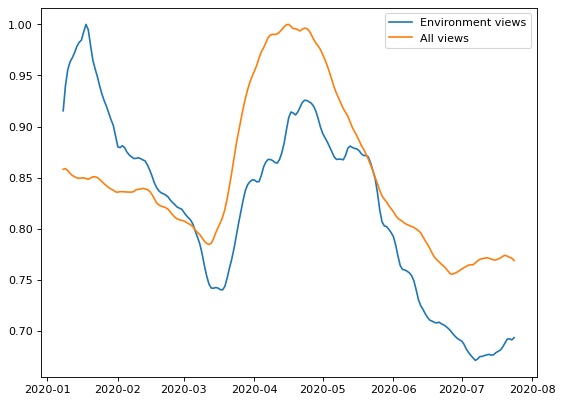

In [75]:
figure(figsize=(8, 6), dpi=80)
plt.plot(result_env, label = "Environment views")
plt.plot(result_all, label = "All views")
plt.legend()

As we can see in this first analysis, it appears that the maximum of the environment views happen in the beginning of 2020, during a time where the Wikipedia views in general are declining; after that, in the first part of March, the general views are in constant increase while the environment ones decline until near the end of March. After that, both timeseries appear to be in sync. 

In order to be more fine-grained about our analysis, we will propose two methods : Dynamic Time Warping first, then Time Lagged Cross-Correlation.

### Dynamic time warping

Dynamic time warping (DTW) is a way to compare two usually temporal sequences that do not sync up perfectly. It is a method to calculate the optimal matching between two sequences. It’s commonly used to measure the distance between two time-series.

Our goal here is to build some intuition on whenever the increase in popularity of the environement pages is simply due to the fact that people read wikipedia more or if people are really more interested in them. In order to do that we will study the similarity between the wikipedia views of environement related topics with the total wikipedia views both as a function of time. We only keep the views data from 2020.

In [76]:
sum_data_df_2020=sum_data_df[sum_data_df['date']>='2020-01-01']
sum_environment_df_2020=sum_environment_df[sum_environment_df['date']>='2020-01-01']
language=set(sum_data_df_2020['language'])

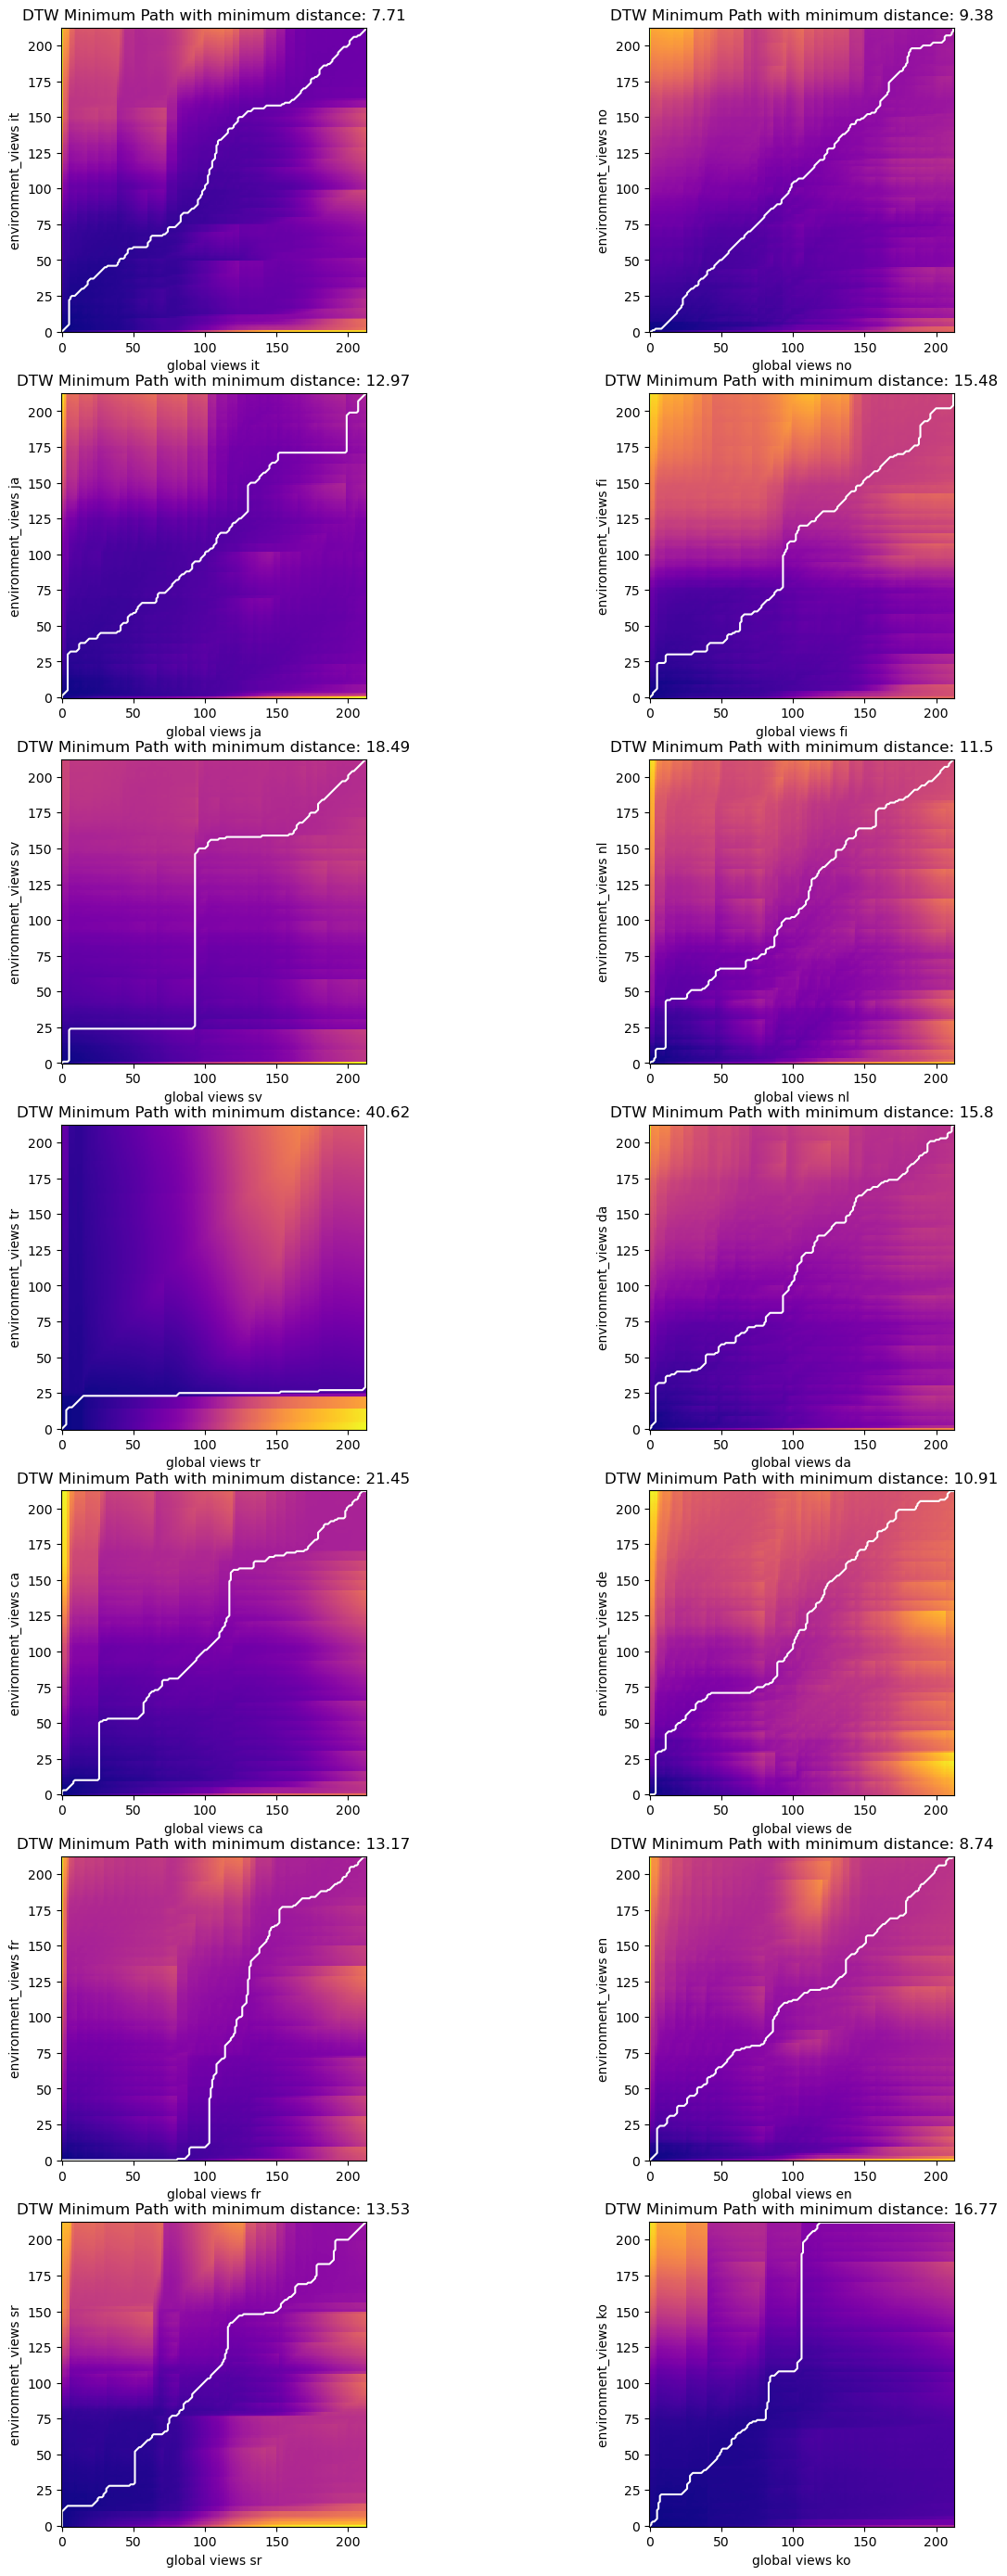

In [77]:
i = 0
fig, axs = plt.subplots(7, 2)
fig.set_figheight(35)
fig.set_figwidth(15)

for code in language:
    ax = axs[i % 7, i // 7 ]
    """
     We decided to use min max scaling as it makes the distance easier to interpret.
     Scaling is important as both timeseries don't have the same range of values, and so this way both timeseries are in the [0, 1] range which makes 
     it possible to compare them.
    """
    sum_data_df_2020_normalized = sum_data_df_2020[(sum_data_df_2020['views'].notnull()) & (sum_data_df_2020['language']==code)].copy()
    sum_data_df_2020_normalized['views'] = (sum_data_df_2020_normalized['views']-sum_data_df_2020_normalized['views'].min())/sum_data_df_2020_normalized['views'].max()
    
    sum_environment_df_2020_normalized = sum_environment_df_2020[sum_environment_df_2020['environment_views'].notnull()& (sum_data_df_2020['language']==code)].copy()
    sum_environment_df_2020_normalized['environment_views']=(sum_environment_df_2020_normalized['environment_views']-sum_environment_df_2020_normalized['environment_views'].min())/sum_environment_df_2020_normalized['environment_views'].max()
    
    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(sum_data_df_2020_normalized['views'].values,sum_environment_df_2020_normalized['environment_views'].values,dist='euclidean')

    ax.imshow(acc_cost_matrix.T, origin='lower', cmap='plasma', interpolation='nearest')
    ax.plot(path[0], path[1], 'w')
    ax.set_xlabel('global views '+code)
    ax.set_ylabel('environment_views '+code)
    ax.set_title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
    i+=1

We can see here that for Italian, Norwegian, English and Dutch, the time series are really close to each others, and because the shortest path is really close to the matrix diagonal, we can say that the time series are behaving similarly (up to the scales of the values and time dilation). This may indicate that the evolution in environment views isn't due to a sudden ecological awareness.

For some of the other languages (Korean or Swedish for example), the distances on one hand are higher than average, and the plots are very far from being lines. This means that DTW didn't find a mapping that is even close to one-to-one for a majority of the points; i.e, the environment views and the total Wikipedia evolution for these languages are different.

### Time lagged cross correlation

Another similarity study we decided to use as a complement to the DTW is the Time lagged cross correlation which study the behavior of $\mathbf{corr}[X_tY_{t+\tau}]$ where $\tau$ is a time lag. The goal of this analysis is see for which value of $\tau$ the correlation is maximal in order to determine if one series is a shifted version of the other or at least has a non zero correlation of time lagged version of the other.

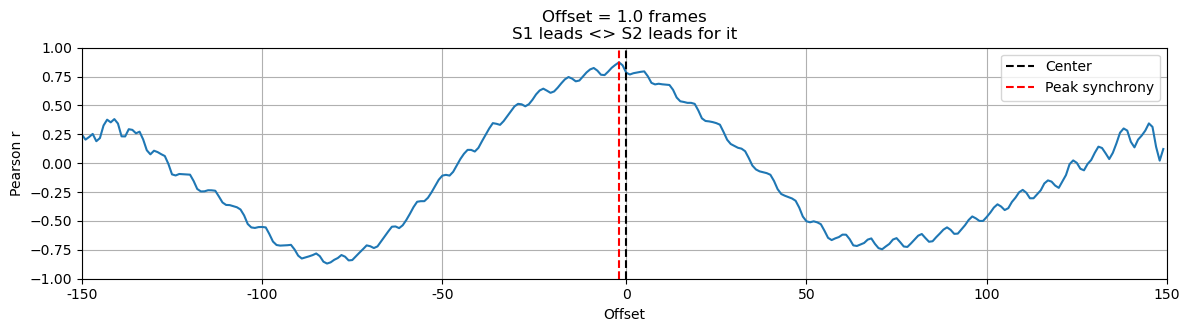

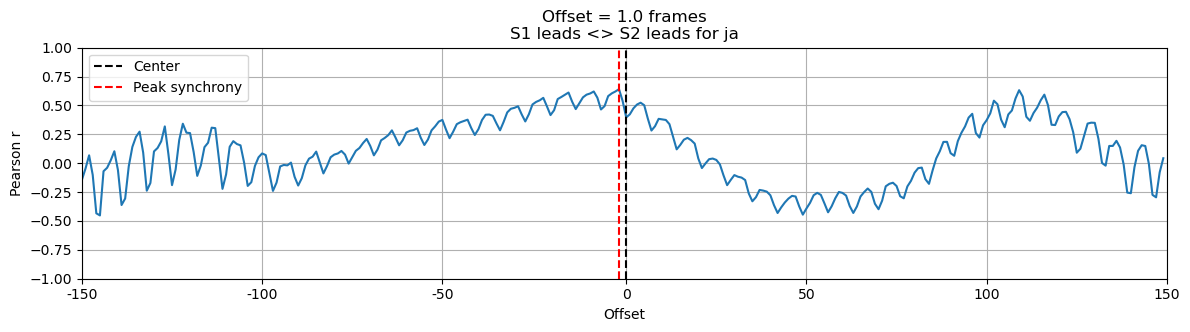

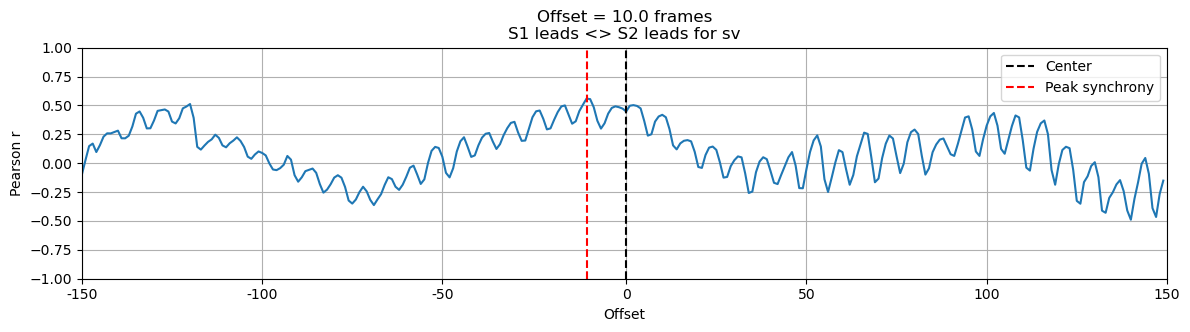

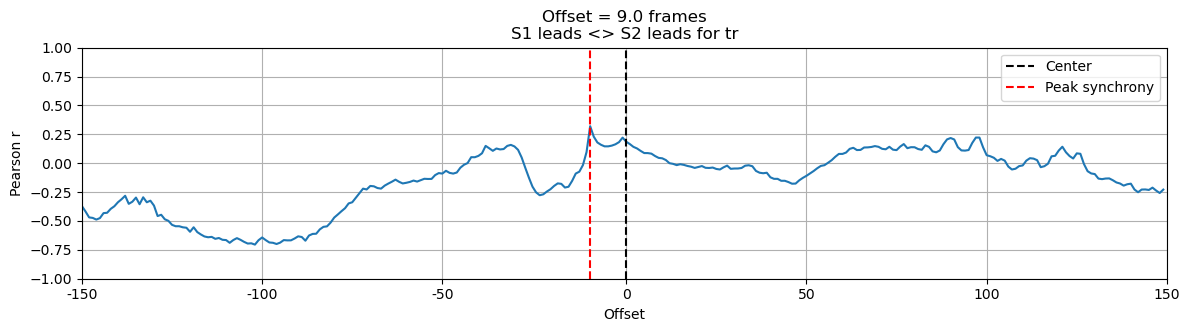

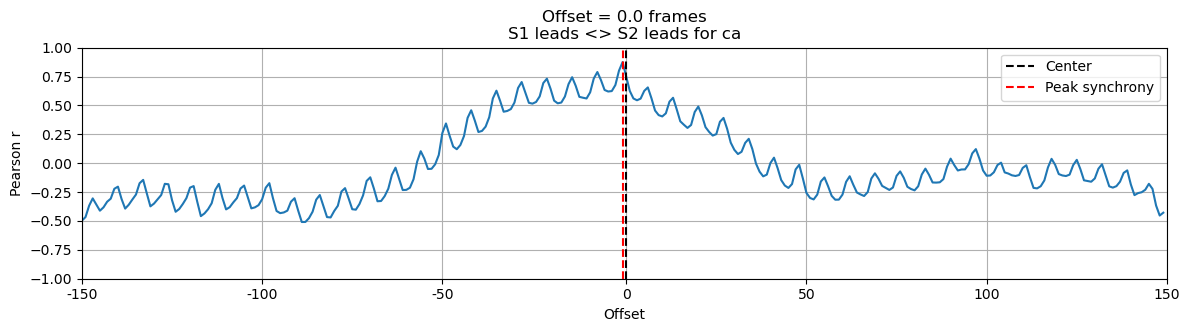

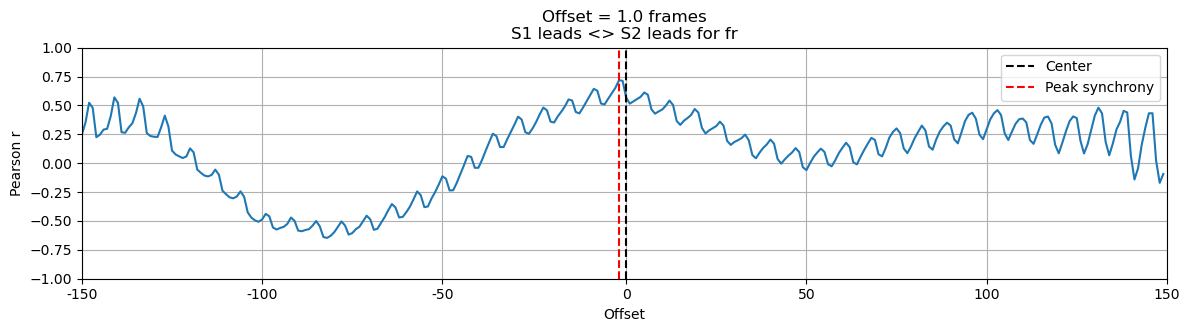

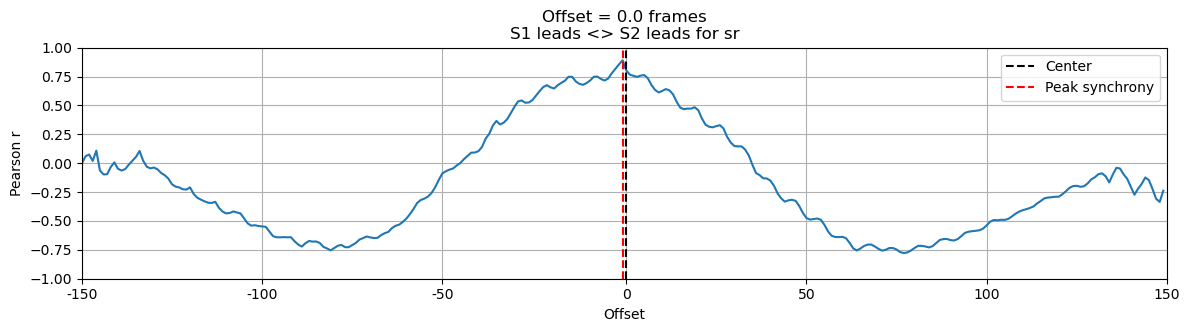

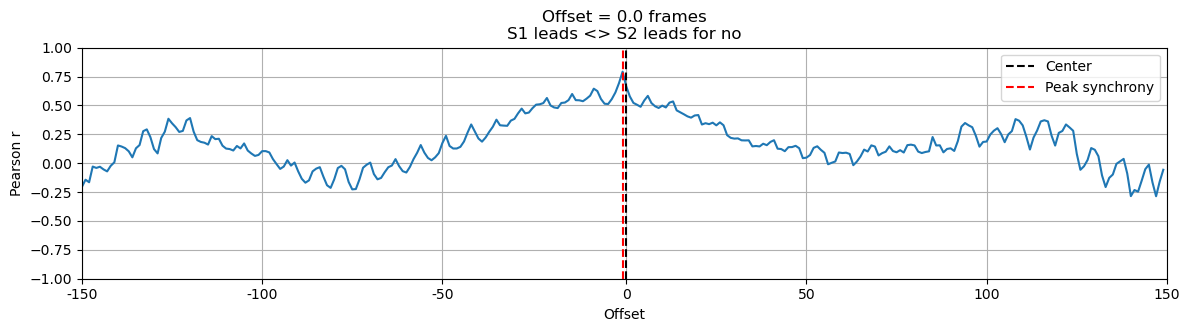

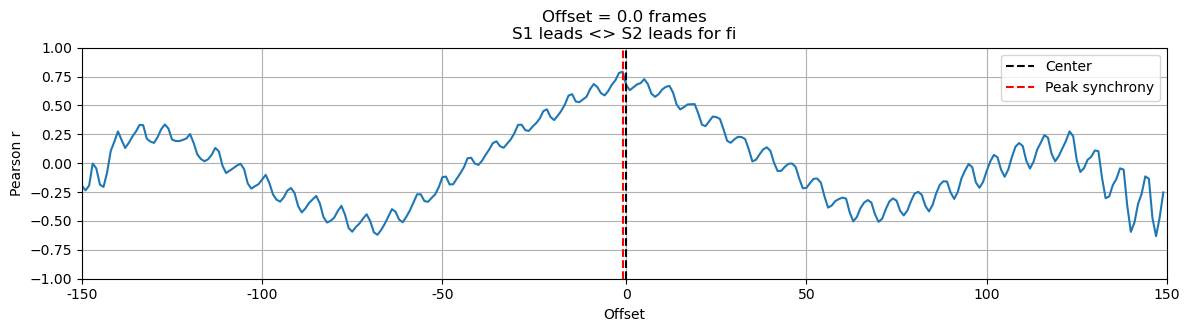

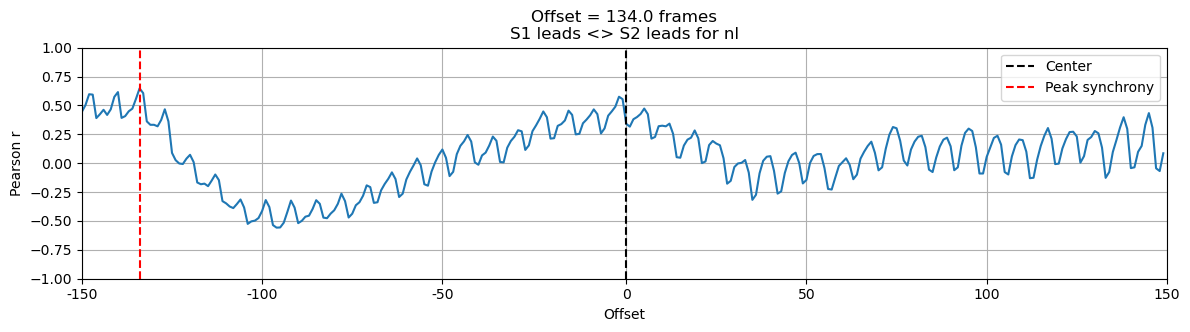

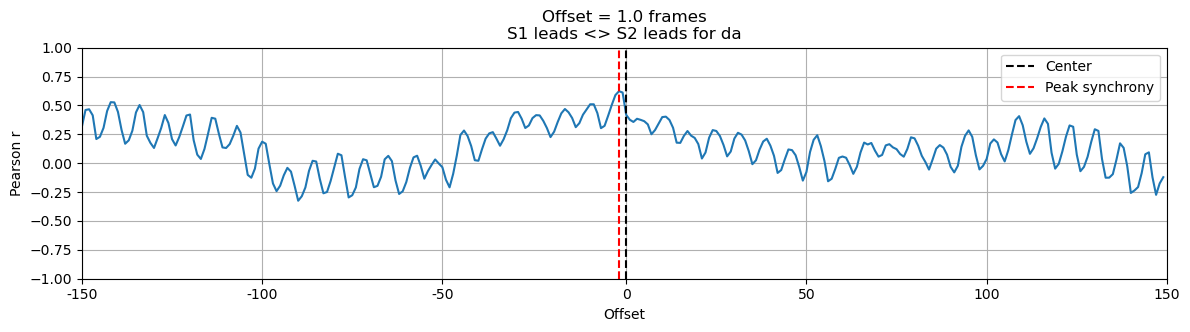

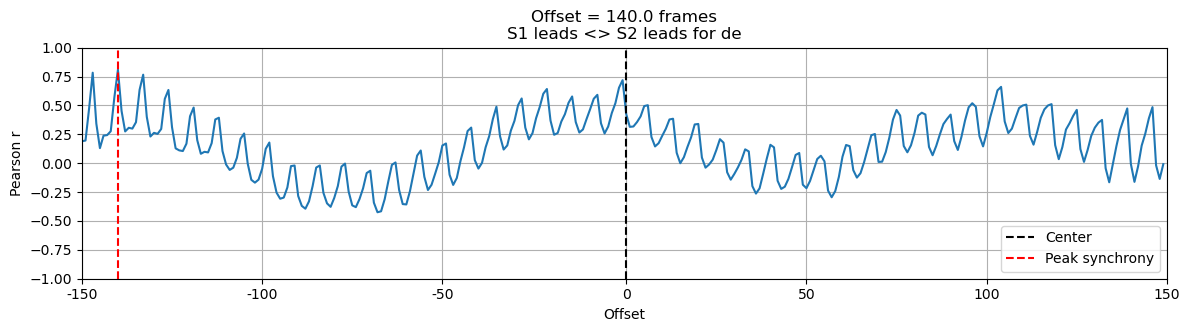

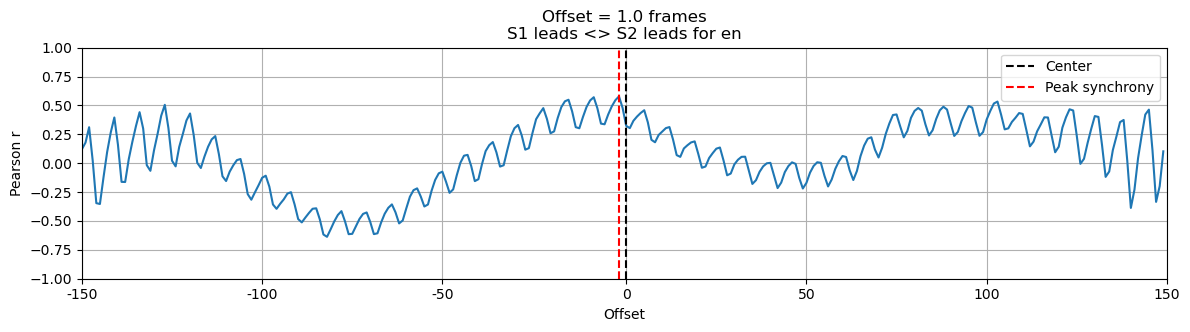

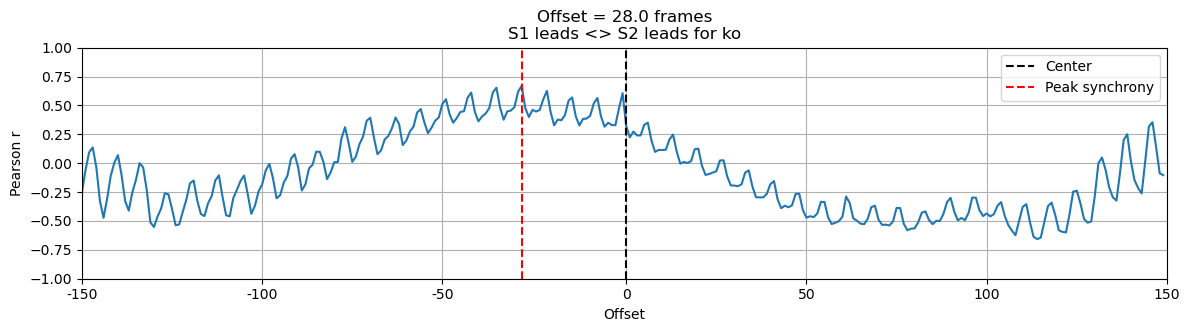

In [78]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
for code in language:
    sum_data_df_2020_normalized = sum_data_df_2020[(sum_data_df_2020['views'].notnull()) & (sum_data_df_2020['language']==code)].copy()
    sum_data_df_2020_normalized['views'] = (sum_data_df_2020_normalized['views']-sum_data_df_2020_normalized['views'].min())/sum_data_df_2020_normalized['views'].max()

    sum_environment_df_2020_normalized = sum_environment_df_2020[sum_environment_df_2020['environment_views'].notnull()& (sum_data_df_2020['language']==code)].copy()
    sum_environment_df_2020_normalized['environment_views']=(sum_environment_df_2020_normalized['environment_views']-sum_environment_df_2020_normalized['environment_views'].min())/sum_environment_df_2020_normalized['environment_views'].max()



    d1 = sum_data_df_2020_normalized['views']
    d2 = sum_environment_df_2020_normalized['environment_views']
    seconds = 5
    fps = 30
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    offset = np.floor(len(rs)/2)-np.argmax(rs)
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs)
    ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads for '+code,ylim=[-1,1],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
    ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
    ax.grid()
    ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
    plt.legend()

An interesting case here is German for which an offset of 140 has a Pearson coefficient of 0.75 meaning that the wikipedia views at time $t+140$ almost overlaps with environment views at time t. This might indicate that some increase in the views of the environement related topics might not be due to an increase in wikipedia views.
Meanwhile, for Serbian, Catalan, French, Italian and Norwegian, the offset that maximizes the cross correlation is 0. As such, we cannot really conclude much as the wikipedia views and environement views behave very similarly, so any increase in the environement views appears to be due to just an increase in Wikipedia views in general.

### Study of the evolution of the rank of the environement topic as a function of time

The previous analysis showed that a more in depth study of the Wikipedia views is required to truly see if the people's attention shifted towards or away from the environment pages during the first Covid wave. To that end, we decided to study the ranking of the views of the environment compared to the rest, to see whether or not it is one of the most important topics. A ranking of 1 means that it is the most viewed subject, while a ranking of 64 means the opposite.

In [79]:
topics = set(countries_to_topics_sum_df.columns)
df_per_topic=dict()

for topic in topics:
    sum_topic_df = countries_to_topics_sum_df[topic]
    country_to_topic_data_sum = {}
    for country in sum_topic_df.index:
        country_to_topic_data_sum[country] = sum_topic_df[country]
    sum_topic_df = pd.DataFrame.from_dict(country_to_topic_data_sum, orient="index").T

    new_sum_topic_df = pd.DataFrame()
    for language in languages_unique:
        country_topic_sum_data = pd.DataFrame()

        country_topic_sum_data[topic+"_views"] = (
            sum_topic_df[language] + sum_topic_df[language + ".m"]
        )
        country_topic_sum_data["language"] = language
        new_sum_topic_df = pd.concat(
            [new_sum_topic_df, country_topic_sum_data], axis=0
        )
    sum_topic_df = new_sum_topic_df
    sum_topic_df.index = pd.to_datetime(sum_topic_df.index)
    sum_topic_df["date"] = sum_topic_df.index
    sum_topic_df["topic"] = topic
    sum_topic_df = sum_topic_df[sum_topic_df.date.dt.year > 2018]
    sum_topic_df = sum_topic_df.rename(columns = {topic+'_views':'views'})
    df_per_topic.update([(topic,sum_topic_df)])
multi_language_save_topic_data = copy.deepcopy(df_per_topic)
    
# we sum the views of all languages together

for topic in topics:
    df_per_topic[topic]=df_per_topic[topic].groupby('date').sum()
    
for topic in topics:
    df_per_topic[topic]['topic']=topic
    df_per_topic[topic].rename(columns = {topic+'_views':'views'}, inplace = True)

df = pd.DataFrame()
for topic in topics:
    df = pd.concat([df, df_per_topic[topic]])   
df['date']=df.index   
df['Month_Year'] = df['date'].dt.to_period('M')
df2=pd.DataFrame(df.groupby(['topic','Month_Year'])['views'].sum())
periods=set(df['Month_Year'])
df2['Month_Year']=df2.index.get_level_values('Month_Year')
df2['topic']=df2.index.get_level_values('topic')
environement_rank=pd.DataFrame()
for period in periods:
    temp=df2[df2['Month_Year']==period].copy()
    temp['topic']=temp.index.get_level_values('topic')
    temp['rank']=temp['views'].rank(ascending=False)
    temp[temp['topic']=='STEM.Earth and environment']['rank']
    environement_rank=pd.concat([environement_rank,temp[temp['topic']=='STEM.Earth and environment']['rank']])
environement_rank.index=environement_rank.index.map( lambda  x:x[1])
environement_rank=environement_rank.sort_index(ascending=True)

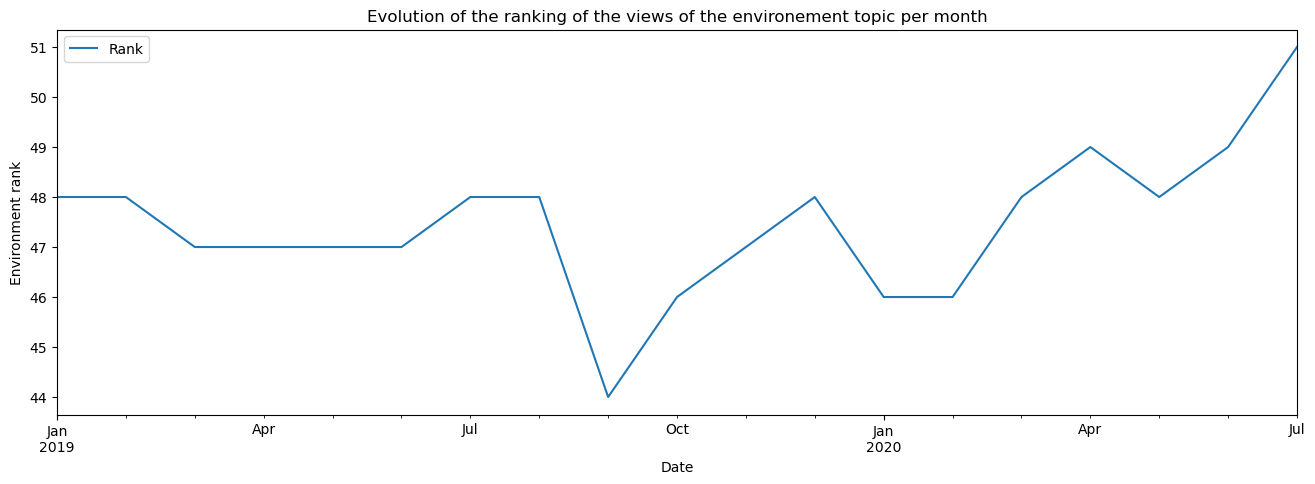

In [80]:
environement_rank.plot.line(figsize = (16,5))
plt.title('Evolution of the ranking of the views of the environement topic per month')
plt.xlabel('Date')
plt.ylabel('Environment rank')
plt.legend(["Rank"])
plt.show()

The results here aren't the best; the fact is that the rank of the environment topic (aggregated accross all available languages) doesn't go above 44, and towards June/July, it actually goes above the 50 rank threshold.

To try and see if this is the result of some languages dominating others in terms of views (English for example), and thus shifting the ranks, we will do the same ranking plot but for every language.

In [81]:
language_to_env_ranking = {} #will hold the ranking of env for each languages
periods = set()
for language in languages_unique:
    df_language_all_topics = pd.DataFrame()
    for topic in topics:
        language_topic_data =  multi_language_save_topic_data[topic]
        language_topic_data = language_topic_data[language_topic_data.language == language]
        df_language_all_topics = pd.concat([df_language_all_topics, language_topic_data])
    #print(df_language_all_topics)
    df_language_all_topics['year_month'] = df_language_all_topics['date'].dt.to_period('M')
    if(periods == set()):
        periods = sorted(set(df_language_all_topics['year_month']))
    
    grouped = pd.DataFrame(df_language_all_topics.groupby(['year_month', 'topic'])['views'].sum())
    grouped['year_month'] = grouped.index.get_level_values('year_month')
    grouped['topic'] = grouped.index.get_level_values('topic')
    #print(grouped.year_month)
    #grouped
    result = []
    result_language = pd.DataFrame()
    for period in periods:
        tmp = grouped[grouped.year_month == period].copy()
        tmp['rank'] = tmp['views'].rank(ascending = False)
        tmp = pd.concat([result_language, tmp[tmp.topic == 'STEM.Earth and environment'][['year_month', 'rank']]])
        tmp.index = tmp.year_month
        result_language = tmp
        #result.append(tmp[tmp.topic == 'STEM.Earth and environment']['rank'])
    language_to_env_ranking[language] = result_language
    

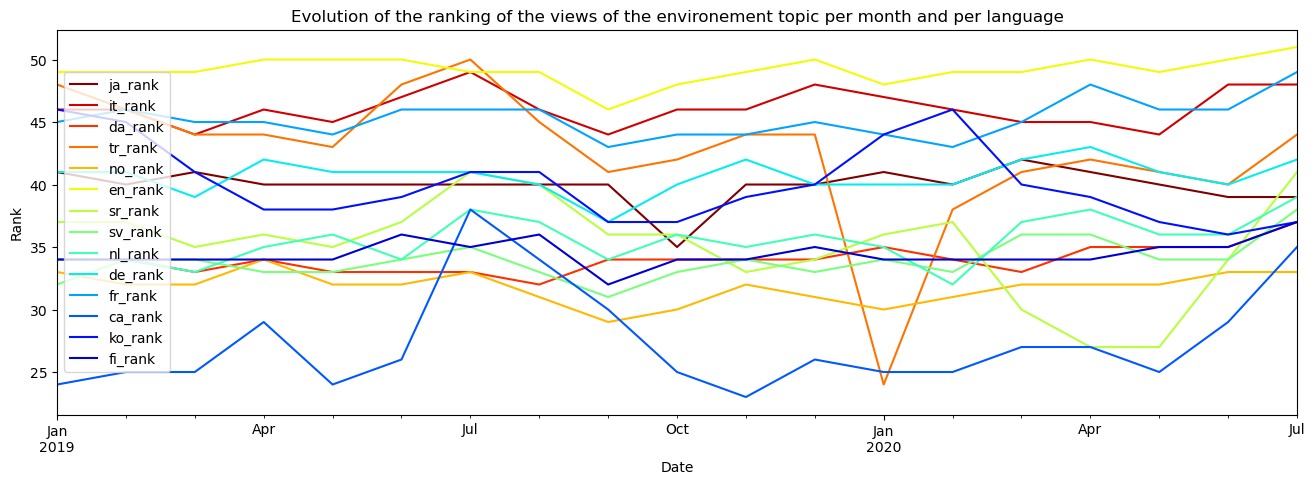

In [82]:
plt.figure(figsize = (16,5))
plt.gca().set_prop_cycle(None)
cmap = plt.get_cmap('jet_r')
for idx,language in enumerate(languages_unique):
    color = cmap(float(idx)/len(languages_unique))
    language_to_env_ranking[language] = language_to_env_ranking[language].rename(columns = {'rank': language + "_rank"})
    ax = language_to_env_ranking[language][language + "_rank"].plot.line(color = color)
plt.title('Evolution of the ranking of the views of the environement topic per month and per language')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.legend()
plt.show()

Here, the results aren't looking great either: it appears that a majority of the languages, the didn't really change their focus towards environment when the first Covid wave hit in March/April 2020. One language in particular that appears to have that behavior is Serbian, but even that shift may have not been caused by Covid; other changes seem to be seasonal.

## Conclusion

Excluding the data loading/wrangling, this first part serves as a preliminary analysis of the Coronawiki dataset content related to environmental topics. Firstly, we saw that statistically speaking, for a majority of the available countries, there was indeed a difference between the visits to environmental topics between the years of 2019 and 2020; this difference wasn't always an increase for all languages.

Using that as a basis, we asked ourselves whether we can predict these views using only the changes in transportations mode/visits to certain places, for every language. We saw that it appears to be possible, but not always interpretable, and there may be a lack of contextualisation, i.e it's not certain that if we had the same data but from another year (for example 2019), we would have the same results. In order to do that, we resort to difference-in-difference regression.

Depending on the considered time period and year, a general increase of environment views is clear after the mobility change compared to both after a return to normalcy, and before that same mobility change for every language. Note that in this case, we did use the 2019 data as well, so we see that the fact that there is an increase in 2020 is indeed related to Covid-related restrictions. However, we asked ourselves another question at this point: yes, there is an increase happening during the first Covid wave, but this translate directly into environmental awareness?

To attempt to answer that, we decided to study the similarities between the evolution of the global wikipedia views, and the evolution of wikipedia views related to the environement.
The DTW analysis showed that for a lot of languages, both of the corresponding timeseries are really close to each others in distance and behave very similarly. This seems to indicate that an increase in environment views was most of the time, because of an increase Wikipedia usage in general. 

In order to complement this analysis, we decided to look at the time lagged cross correlation. Unfortunatly, other than for German for which time lagged cross correlation attains its maximun of 0.75 with a lag of 140 compared to the unlagged correlation of 0.5, most of the languages achieve maximum cross correlation for a lag of 0 or 1, and therefore both of their time series are almost superposed.

More over, since the environement views and wikipedia views behave the same, we decided to study the ranking of the environement topic compared to other topics, either by separating the languages or aggregating them all together. The results we have seems to indicate that people were more preoccupied with other topics than the environment during the first Covid wave.

Thus it seems that for now, the increase in environement views in 2020 isn't necessarily due to a sudden awarness as its rankind drops to 51, but to a increase in wikipedia views. However, it doesn't mean that more awareness wasn't there; our data does stop in July 2020 after all; plus, the Wikipedia views alone aren't enough to confirm a change in awareness, we need to have a better look at the general behavior of people. In order to complement our analysis, we add the usage in the followning part of external datasets related to pollution, and even more Wikipedia data to see the evolution of environment related views after 2020. 

# Part 2 : The external datasets which we added by ourselves

## Precise Wikipedia Views Analysis

The goal of this section is to precisely analyse the views of different wikipedia pages (Air pollution, Plastic pollution, and plastic production) from 01/01/2019 to 01/09/2022.

## Data import

In [83]:
# We restrict the page to the language studied in coronawiki
languages = [
    "ja",
    "it",
    "da",
    "tr",
    "no",
    "en",
    "sr",
    "sv",
    "nl",
    "de",
    "fr",
    "ca",
    "ko",
    "fi",
]

In [84]:
def process_langviews_data(path, columns_to_keep=None):
    """
    Convert the csv generated by langviews for a particular wikipedia page into a usable dataframe keeping only the pages in the specified languages.
    The resulting dataframe has a column per language and a new total column giving the total number of views across all the studied languages.
    """

    data = pd.read_csv(path).transpose()
    data.columns = data.iloc[0]
    titles = data.iloc[1]
    data.drop(["Language", "Title", "Badges"], inplace=True)

    if columns_to_keep is None:
        columns_to_keep = data.columns

    columns = data.columns.intersection(columns_to_keep + ["date"])
    data = data[columns]

    data["total"] = data.sum(axis=1)
    data["date"] = data.index
    data["date"] = pd.to_datetime(data["date"])
    data["year"] = data.apply(lambda x: x.date.year, axis=1)

    return  titles ,data

#### Air Pollution

In [85]:
airpol_titles, airpol_data = process_langviews_data(
    "Data/Additional/wikiviews/page-views-airpol.csv", languages
)
airpol_data

Language      en   fr  it   ja   de   tr   sr  nl  ko  ca  fi  sv no da  \
2015-07-01  4647  150  86  316  235   17   10  26  24   9   4   2  4  2   
2015-07-02  4373  152  94  301  187    9    1  21  10   7   6   6  5  3   
2015-07-03  3429  155  88  240   96    6    5  17   3  11   3   2  5  1   
2015-07-04  3328   97  44  145   66   14    3  32   4   1   0   2  2  0   
2015-07-05  4541   73  56  243  129   10    7  34  11   3   3   8  3  2   
...          ...  ...  ..  ...  ...  ...  ...  ..  ..  ..  ..  .. .. ..   
2022-10-28  3286  205  73  159   44   50   54  30  51  23   2  15  1  1   
2022-10-29  2818  236  40   54   26   59   37  11  20  17   7   3  1  2   
2022-10-30  3712  273  57   56   55   56   64  14  52  10   7   5  0  4   
2022-10-31  4158  268  52  181   51  107  161  22  77  12  14   7  1  0   
2022-11-01  4379  307  84  139   68   97  114  23  87  26  14   5  1  1   

Language     total       date  year  
2015-07-01  5532.0 2015-07-01  2015  
2015-07-02  5175.0 2015-07-02  2015  
2015-07-03  4061.0 2015-07-03  2015  
2015-07-04  3738.0 2015-07-04  2015  
2015-07-05  5123.0 2015-07-05  2015  
...            ...        ...   ...  
2022-10-28  3994.0 2022-10-28  2022  
2022-10-29  3331.0 2022-10-29  2022  
2022-10-30  4365.0 2022-10-30  2022  
2022-10-31  5111.0 2022-10-31  2022  
2022-11-01  5345.0 2022-11-01  2022  

[2681 rows x 17 columns]

#### Plastic Industry

In [86]:
plastin_titles, plastin_data = process_langviews_data(
    "Data/Additional/wikiviews/page-views-plastin.csv", languages
)
plastin_data

Language     en  fr fi  de  total       date  year
2019-01-01   72   1  1   0   74.0 2019-01-01  2019
2019-01-02  145   1  5   0  151.0 2019-01-02  2019
2019-01-03  129   0  4   2  135.0 2019-01-03  2019
2019-01-04  181   1  3   1  186.0 2019-01-04  2019
2019-01-05   98   1  4   0  103.0 2019-01-05  2019
...         ...  .. ..  ..    ...        ...   ...
2022-11-04   72   9  1  11   93.0 2022-11-04  2022
2022-11-05   59  18  1   7   85.0 2022-11-05  2022
2022-11-06   56  15  3   3   77.0 2022-11-06  2022
2022-11-07   65  10  6   7   88.0 2022-11-07  2022
2022-11-08   97  13  6  11  127.0 2022-11-08  2022

[1408 rows x 7 columns]

#### Plastic Pollution

In [87]:
plastpol_titles, plastpol_data = process_langviews_data(
    "Data/Additional/wikiviews/page-views-plastpol.csv", languages
)
plastpol_data

Language      en  it  fr  ko da ca tr  de  nl sr   total       date  year
2015-07-01   958   6   4   0  0  0  0   0   0  0   968.0 2015-07-01  2015
2015-07-02  1123  10   7   0  0  0  0   0   0  0  1140.0 2015-07-02  2015
2015-07-03   808   3   5   0  0  0  0   0   0  0   816.0 2015-07-03  2015
2015-07-04   729  10   4   0  0  0  0   0   0  0   743.0 2015-07-04  2015
2015-07-05  1172  10   2   0  0  0  0   0   0  0  1184.0 2015-07-05  2015
...          ...  ..  ..  .. .. .. ..  ..  .. ..     ...        ...   ...
2022-10-28   797  42  22  35  1  1  5  10  15  0   928.0 2022-10-28  2022
2022-10-29   600  33  22  11  0  0  6   2   3  0   677.0 2022-10-29  2022
2022-10-30   830  23  21  34  0  0  6   2   1  0   917.0 2022-10-30  2022
2022-10-31   728  44  28  74  1  0  3   4  43  0   925.0 2022-10-31  2022
2022-11-01   894  59  33  90  1  0  6   4  24  3  1114.0 2022-11-01  2022

[2681 rows x 13 columns]

### Covid-19

In [88]:
covid_titles, covid_data = process_langviews_data(
    "Data/Additional/wikiviews/page-views-covid19.csv", languages
)
covid_data

Language       en    de    it    fr   nl    ja   tr   fi   ko   sv   da  ca  \
2018-01-01      0     0     0     0    0     0    0    0    0    0    0   0   
2018-01-02      0     0     0     0    0     0    0    0    0    0    0   0   
2018-01-03      0     0     0     0    0     0    0    0    0    0    0   0   
2018-01-04      0     0     0     0    0     0    0    0    0    0    0   0   
2018-01-05      0     0     0     0    0     0    0    0    0    0    0   0   
...           ...   ...   ...   ...  ...   ...  ...  ...  ...  ...  ...  ..   
2021-12-27  20411  1870  2709  1254  461  1149  415  298  227  155   64  77   
2021-12-28  21443  2070  2983  1363  512  1059  428  383  261  163   94  80   
2021-12-29  23268  2250  3105  1468  672  1094  452  432  228  178  103  63   
2021-12-30  23472  1872  3173  1370  601  1016  459  392  410  224   84  65   
2021-12-31  21463  1681  2463  1171  618  1080  363  319  199  235   86  61   

Language     no  sr    total       date  year  
2018-01-01    0   0      0.0 2018-01-01  2018  
2018-01-02    0   0      0.0 2018-01-02  2018  
2018-01-03    0   0      0.0 2018-01-03  2018  
2018-01-04    0   0      0.0 2018-01-04  2018  
2018-01-05    0   0      0.0 2018-01-05  2018  
...         ...  ..      ...        ...   ...  
2021-12-27   85  22  29197.0 2021-12-27  2021  
2021-12-28   65  31  30935.0 2021-12-28  2021  
2021-12-29   79  43  33435.0 2021-12-29  2021  
2021-12-30  110  23  33271.0 2021-12-30  2021  
2021-12-31   95  19  29853.0 2021-12-31  2021  

[1461 rows x 17 columns]

### Total Wikipedia Views

In [89]:
global_views = pd.read_csv('Data/Additional/langviews/final/wikipedia_global_views.csv')
global_views['date'] = pd.to_datetime(global_views['date'])
global_views['total'] = global_views.drop("date", axis=1).sum(axis=1)
global_views['year'] = global_views.apply(lambda x: x.date.year, axis=1)

## Visualization

### Air Pollution

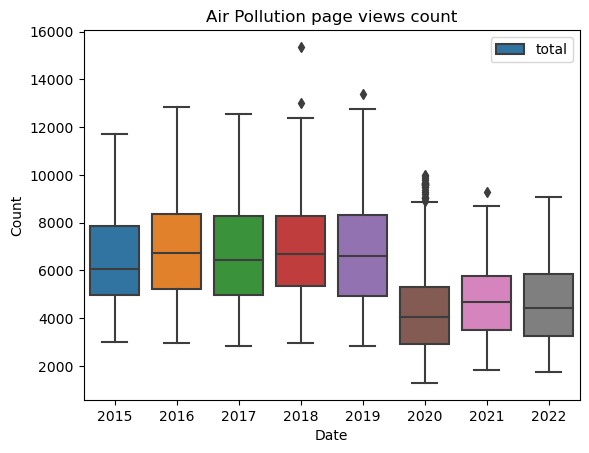

In [90]:
sns.boxplot(y=airpol_data.total, x=airpol_data.year)
plt.title("Air Pollution page views count")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["total"])
plt.show()

It seems that during and after COVID, interest in air pollution decreases significantly

### Plastic Industry

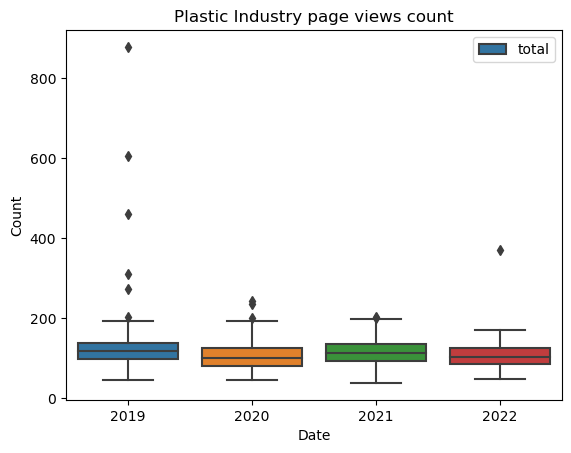

In [91]:
sns.boxplot(y=plastin_data.total, x=plastin_data.year)
plt.title("Plastic Industry page views count")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["total"])
plt.show()

There are not enough views to conclude anything about awareness on this topic.

### Plastic Pollution

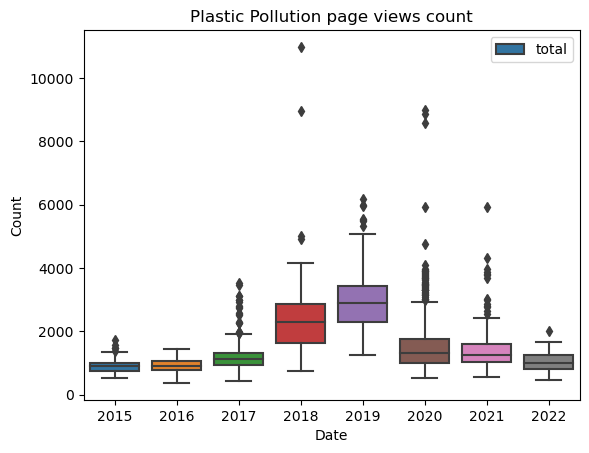

In [92]:
sns.boxplot(y=plastpol_data.total, x=plastpol_data.year)
plt.title("Plastic Pollution page views count")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["total"])
plt.show()

### Total Wikipedia Views

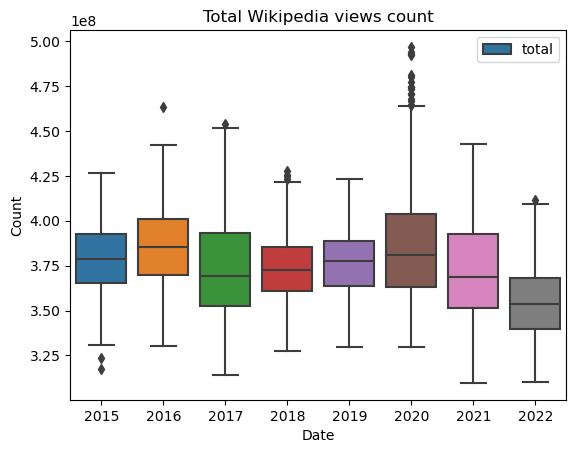

In [93]:
sns.boxplot(y=global_views.total, x=global_views.year)
plt.title("Total Wikipedia views count")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["total"])

Globally, it seems that interest in wikipedia increases during Covid and significatively decreases after the crisis.

### Environment topic expansion

The coronawiki dataset contains aggregated views per day of all articles related to different topics. Unfortunately, these values are only listed for the years 2018 to 2020. This is not usable to do a proper analysis, so we used the langviews website to acquire views data for every article in the environment topic and aggregate them. To see how we precisely did, you can see the *wikipedia_views_extension* notebook.

In [94]:
aggregated_views = pd.read_csv('Data/Additional/langviews/final/aggregated_views.csv')
aggregated_views['date'] = pd.to_datetime(aggregated_views['date'])
aggregated_views['year'] = aggregated_views.apply(lambda x: x.date.year, axis=1)
aggregated_views

ja       it      da       tr      no         en       sr       sv  \
0     182122.0  77640.0  4067.0  16321.0  5386.0  1519066.0   2334.0  12743.0   
1     201826.0  72749.0  3874.0  15493.0  5663.0  1438586.0   2310.0  13477.0   
2     170885.0  68917.0  3758.0  15131.0  5297.0  1293716.0   1938.0  13601.0   
3     154506.0  59069.0  3891.0  32832.0  5101.0  1167907.0   1860.0  16422.0   
4     181196.0  67898.0  5367.0  18967.0  6428.0  1331215.0   2465.0  18411.0   
...        ...      ...     ...      ...     ...        ...      ...      ...   
2696  133494.0  82921.0  5805.0  39317.0  8255.0  1525641.0   9441.0  22762.0   
2697  156458.0  72549.0  5385.0  39910.0  7559.0  1395392.0   8668.0  20617.0   
2698  110291.0  71071.0  4349.0  32031.0  5803.0  1280768.0   7632.0  17542.0   
2699  123332.0  85384.0  5613.0  41407.0  7168.0  1418026.0  10264.0  20283.0   
2700       0.0      0.0     0.0      0.0     0.0        0.0      0.0      0.0   

           nl        de        fr       ca       ko       fi      total  \
0     32902.0  209406.0  124421.0   2601.0  14987.0   9054.0  2213050.0   
1     30745.0  204013.0  114584.0   2876.0  13309.0   8739.0  2128244.0   
2     25835.0  176506.0  105264.0   2321.0  15551.0   8254.0  1906974.0   
3     26814.0  159996.0   99934.0   2328.0  12892.0   7924.0  1751476.0   
4     35109.0  217275.0  112298.0   3086.0  14841.0  10258.0  2024814.0   
...       ...       ...       ...      ...      ...      ...        ...   
2696  37995.0  176343.0  175445.0  10931.0  13706.0  17274.0  2259330.0   
2697  33013.0  155686.0  145484.0   9180.0  13698.0  16618.0  2080217.0   
2698  30480.0  143231.0  140873.0   5007.0  10185.0  13538.0  1872801.0   
2699  34610.0  190498.0  170235.0   6979.0  12222.0  15121.0  2141142.0   
2700      0.0       0.0       0.0      0.0      0.0      0.0        0.0   

           date  year  
0    2015-07-01  2015  
1    2015-07-02  2015  
2    2015-07-03  2015  
3    2015-07-04  2015  
4    2015-07-05  2015  
...         ...   ...  
2696 2022-11-17  2022  
2697 2022-11-18  2022  
2698 2022-11-19  2022  
2699 2022-11-20  2022  
2700 2022-11-21  2022  

[2701 rows x 17 columns]

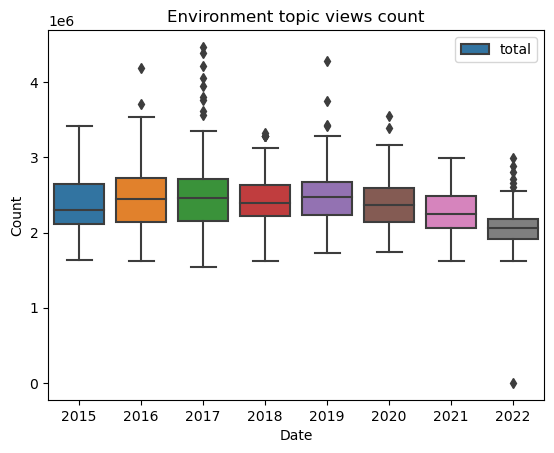

In [95]:
sns.boxplot(y=aggregated_views.total, x=aggregated_views.year)
plt.title("Environment topic views count")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["total"])
plt.show()

Globally, after the Covid crisis, interest in articles concerning the environment topic decreases. We now need to determine wether this decrease follow the general loss of interest in wikipedia or not.

This concludes the extra data from Wikipedia that we add to the original Coronawiki dataset.
Let us now present the next one : NO2 air pollution data by country.

## Analysis of nitrogen dioxide levels by capital city

Nitrogen dioxide is a toxic molecule that is typically emitted by industrial activities and car engines. It is therefore a very good indicator of human-induced air pollution.

Here, we will focus on understanding the link between Covid and NO2 air pollution, i.e. between Covid and human-induced air pollution. To do so, we will make the following assumptions :
- 2019 is the year that represents the "usual activities" before Covid.
- The year of lockdowns and restrictions is then obviously 2020. We also consider that 2021-22 are the beginning of efforts towards going back to the normal, pre-Covid life. We do not assume that 2021 and 2022 have succeeded at being "back to normal".

This might be a simplification of reality, but it has the two following advantages :
- Covid began spreading worldwide during the very beginning of 2020. We can exploit this to our advantage by splitting years at the beginning of January, which is easy and fits our assumptions well.
- It makes for very easy cross-coutries, cross-years comparisons.
- Using instead lockdown data instead of year-by-year separations would weaken the possibility of comparing pollution by country, as pollution emissions are very dependent on the period of the year.

The goal of this section is then to establish (or not) the fact that during Covid, the air got significantly cleaner, and to quantify the margin of improvement. We also consider the recovery phase after the initial Covid wave, i.e. after 2020.

## Data loading

We use air pollution data from the different capitals from the World Air Quality Index dataset for the Covid-19 period (https://aqicn.org/data-platform/covid19/). This is a reliable dataset that was used in various large-scale studies about worldwide air pollution. This dataset is fairly lage, it includes the data for the years 2018 to 2022 for many cities of the world, and for various air polluting molecules.

We reduce this to NO2 and only the fourteen capital cities in the notebook "air_quality_by_capital.ipynb", reducing the dataset to a much more manageable size, but not to the point of losing all interesting information.

Note : we don't consider country-wide pollution because the dataset does not provide us with a way to merge all cities into one large blob for the country : we don't have the city size, the geographic proportion of the city in the country, etc. We therefore study capitals only, which the dataset certainly provides.

In [96]:
path_to_datasets = "Data/Additional/waqi/no2_capital/"
capitals = [
    "tokyo",
    "rome",
    "copenhagen",
    "ankara",
    "oslo",
    "washington",
    "stockholm",
    "belgrade",
    "amsterdam",
    "berlin",
    "paris",
    "barcelona",
    "seoul",
    "helsinki",
]

In [97]:
full_datasets = []
for capital in capitals:
    full_datasets.append((capital, pd.read_csv(path_to_datasets + capital + ".csv")))

In [98]:
full_datasets[1][1]

Date Country  City Specie  median
0     2018-12-31      IT  Rome    no2    17.9
1     2019-01-01      IT  Rome    no2    11.9
2     2019-01-02      IT  Rome    no2    12.8
3     2019-01-03      IT  Rome    no2    11.5
4     2019-01-04      IT  Rome    no2    13.3
...          ...     ...   ...    ...     ...
1390  2022-10-27      IT  Rome    no2    19.7
1391  2022-10-28      IT  Rome    no2    18.8
1392  2022-10-29      IT  Rome    no2    16.5
1393  2022-10-30      IT  Rome    no2    13.8
1394  2022-10-31      IT  Rome    no2    17.4

[1395 rows x 5 columns]

In [99]:
ds_2019 = []
for (capital, dataset) in full_datasets:
    # keep year 2019
    ds = dataset[dataset.Date.str.startswith("2019")].copy()
    # remove year from date string to allow for inner merge on date with other years later on
    ds["yearlessDate"] = ds.Date.str[5:]
    # remove all other columns
    ds = ds[["yearlessDate", "median"]]
    ds_2019.append((capital, ds))

In [100]:
# same thing as above, but for 2020
ds_2020 = []
for (capital, dataset) in full_datasets:
    ds = dataset[dataset.Date.str.startswith("2020")].copy()
    ds["yearlessDate"] = ds.Date.str[5:]
    ds = ds[["yearlessDate", "median"]]
    ds_2020.append((capital, ds))

In [101]:
ds_2021 = []
for (capital, dataset) in full_datasets:
    ds = dataset[dataset.Date.str.startswith("2021")].copy()
    ds["yearlessDate"] = ds.Date.str[5:]
    ds = ds[["yearlessDate", "median"]]
    ds_2021.append((capital, ds))

In [102]:
ds_2022 = []
for (capital, dataset) in full_datasets:
    ds = dataset[dataset.Date.str.startswith("2022")].copy()
    ds["yearlessDate"] = ds.Date.str[5:]
    ds = ds[["yearlessDate", "median"]]
    ds_2022.append((capital, ds))

## Data viz

We will then plot the SO3 measurements in all 14 cities every day for the years 2019, 2020 and 2021.

We could also easily plot the current data for 2022, but we found that the resulting graph was fairly overloaded.

We use a log scale because these cities have strong differences in air quality, and we want to show the full detail.

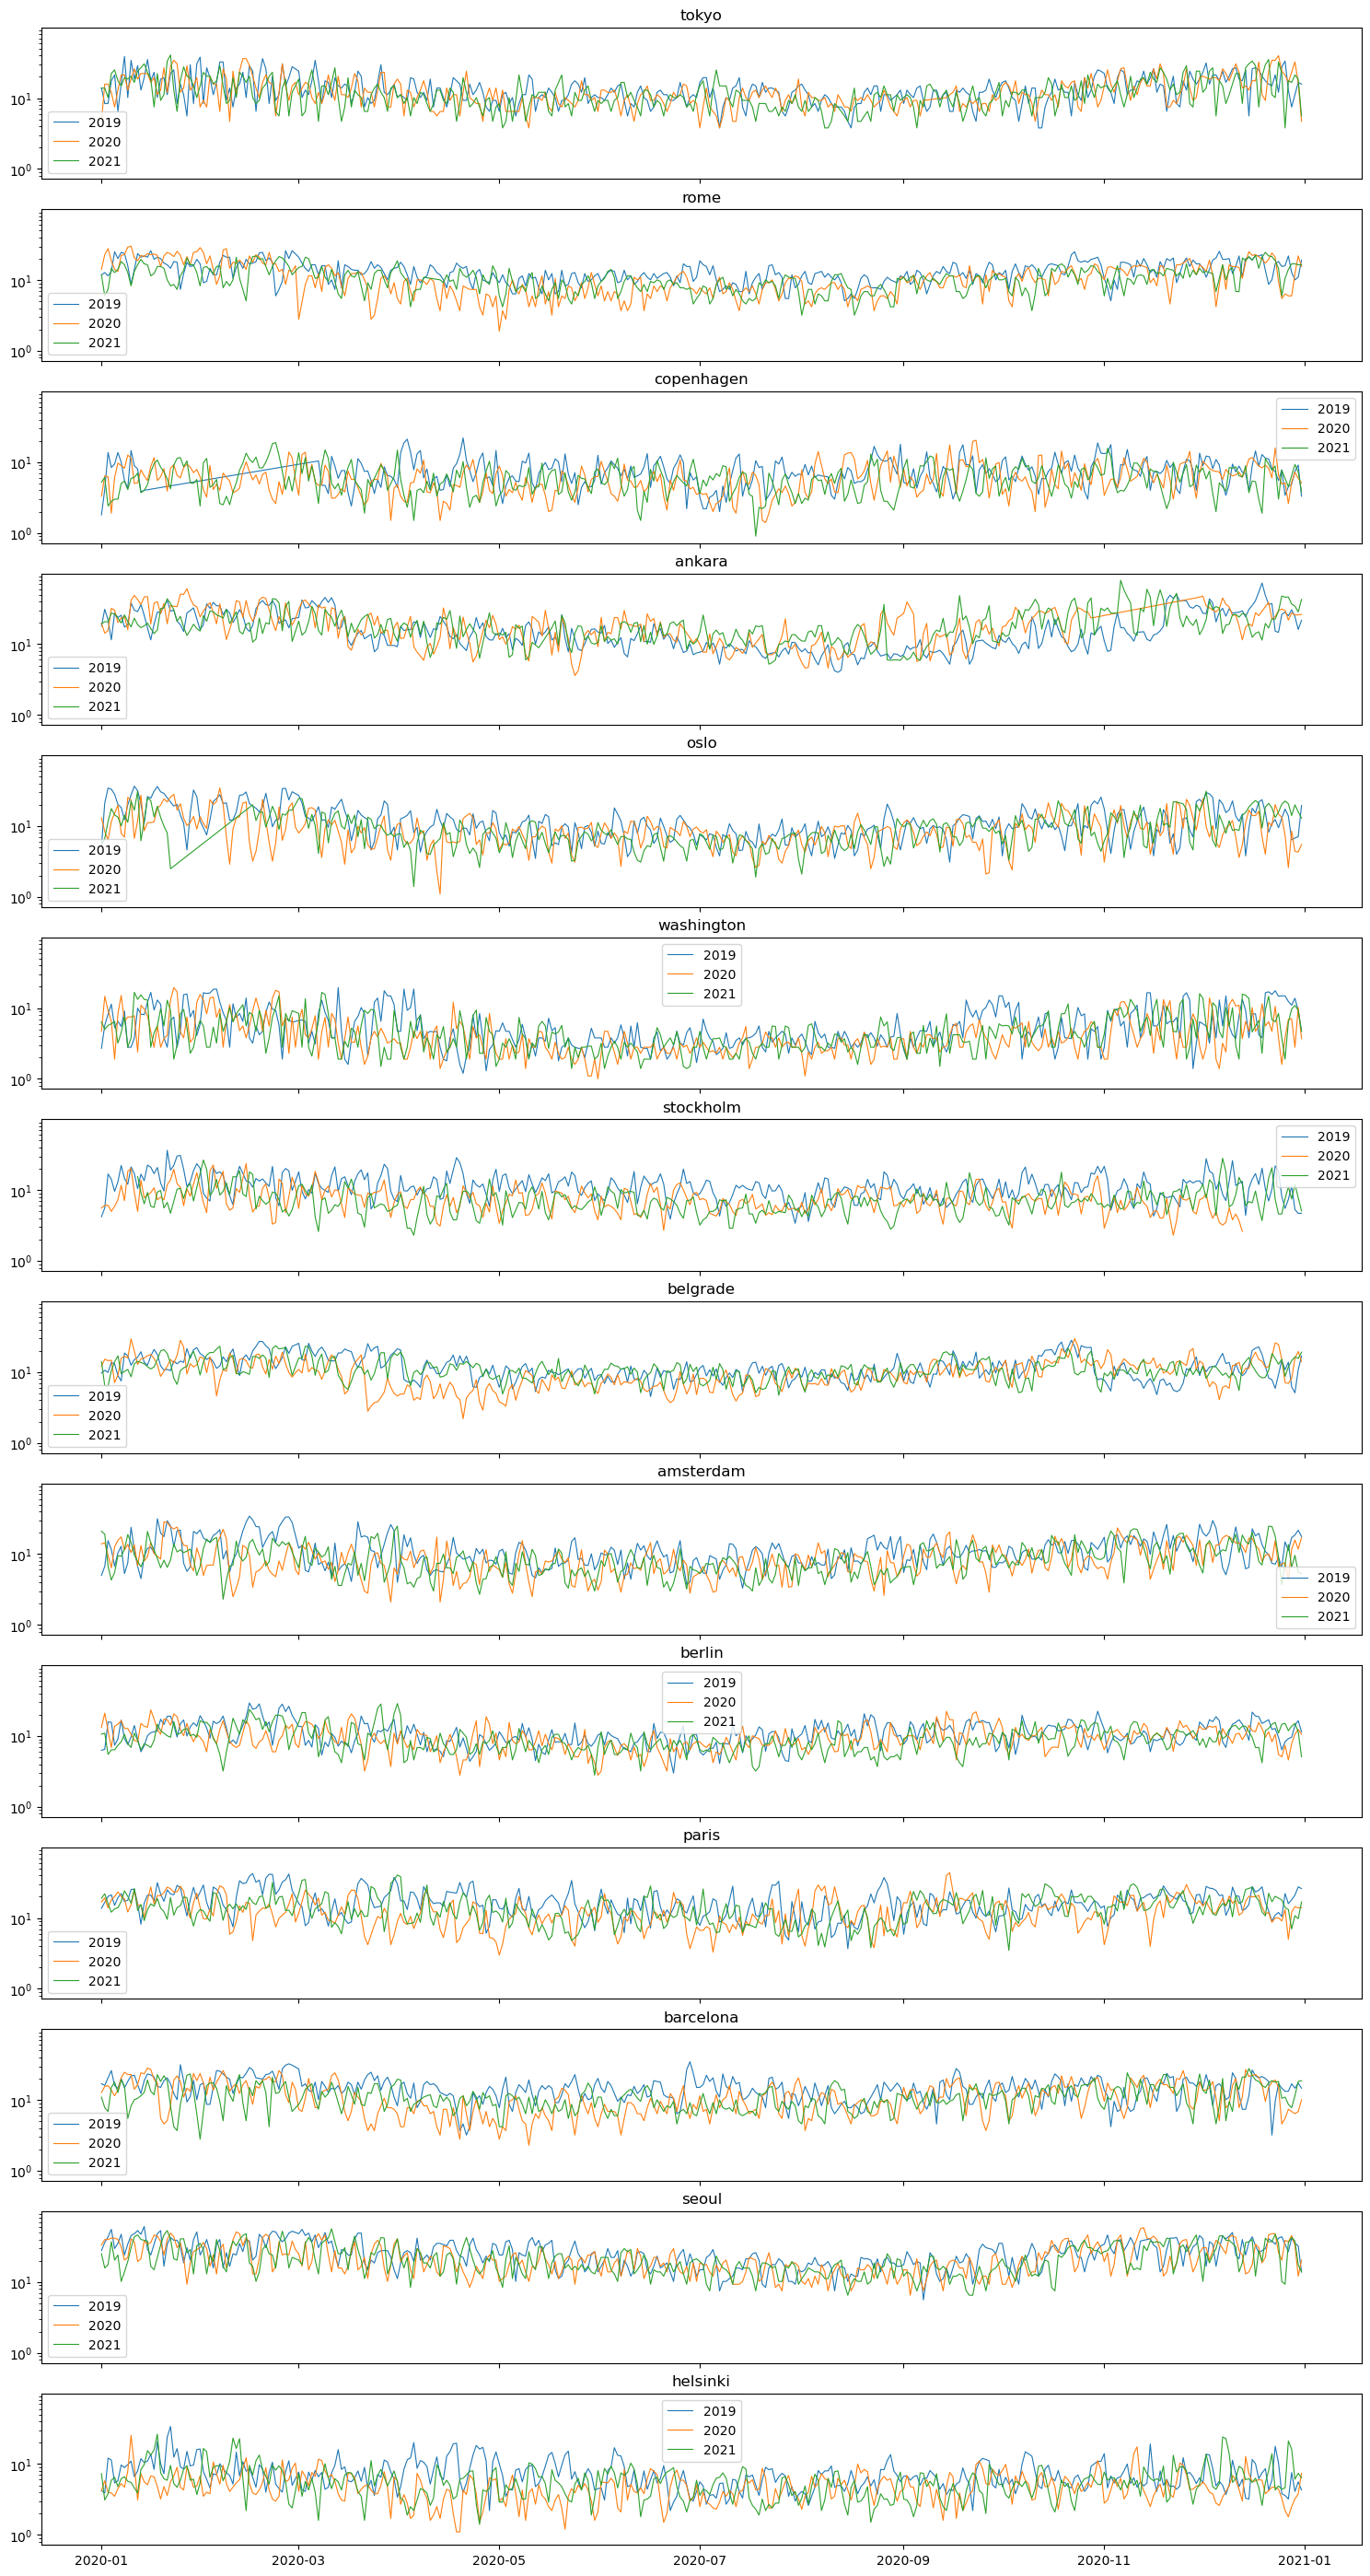

In [103]:
fig, ax = plt.subplots(14, sharex=True, sharey=True)
fig.set_size_inches(18.5, 35.5)
for i in range(14):
    ds1 = ds_2019[i][1]
    ds2 = ds_2020[i][1]
    ds3 = ds_2021[i][1]
    # not 2022, see above

    ax[i].set_yscale("log")
    ax[i].set_title(ds_2019[i][0])
    # always 2020 because we want all three graphs on one year, and 2020 is a leap year
    (p2019,) = ax[i].plot_date(
        matplotlib.dates.datestr2num("2020-" + ds1["yearlessDate"]),
        ds1["median"],
        tz="UTC+1",
        fmt="-",
        linewidth=0.8,
    )
    (p2020,) = ax[i].plot_date(
        matplotlib.dates.datestr2num("2020-" + ds2["yearlessDate"]),
        ds2["median"],
        tz="UTC+1",
        fmt="-",
        linewidth=0.8,
    )
    (p2021,) = ax[i].plot_date(
        matplotlib.dates.datestr2num("2020-" + ds3["yearlessDate"]),
        ds3["median"],
        tz="UTC+1",
        fmt="-",
        linewidth=0.8,
    )
    ax[i].legend([p2019, p2020, p2021], ["2019", "2020", "2021"])

Some trends emerge :
- 2019 (in blue) is usually a little bit above the others. When considering that this is a log scale, this is actually a fairly impressive difference.
- 2020 is typically lower. We can almost always find a drop in March 2020, where the international community initially reacted to the virus.
- 2020 and 2021 are somewhat more difficult to discern. It could be that these years are similar in terms of NO2 pollution.

We can also check the evolution of mean pollution per country per year :

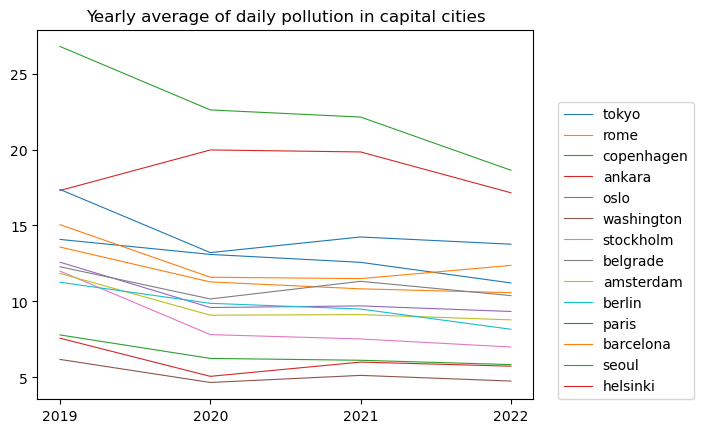

In [104]:
means2019 = [df["median"].mean() for (capital, df) in ds_2019]
means2020 = [df["median"].mean() for (capital, df) in ds_2020]
means2021 = [df["median"].mean() for (capital, df) in ds_2021]
means2022 = [df["median"].mean() for (capital, df) in ds_2022]


plt.title("Yearly average of daily pollution in capital cities")

for i in range(len(capitals)):
    plt.plot(
        ["2019", "2020", "2021", "2022"],
        [means2019[i], means2020[i], means2021[i], means2022[i]],
        linewidth=0.8,
        label=capitals[i],
    )

plt.legend(loc=(1.05, 0))
plt.show()

Perhaps surprisingly, the graph is not U-shaped at all ! This means that on average, air pollution in the capital cities goes down steadily year after year. There is a caveat : the year 2022 is not over as we write these words. This means that the end of autumn and beginning of winter 2022 are not accounted for in this graph. If winter is more polluted than summer in 2022, then the graph above underestimates the pollution average for 2022.

We can then quantify this evolution exactly, by using statistics.

## Statistical testing

The testing we will perform consists of the following :
- First, we merge the pollution data of two years
- Then, for each capital city, we do a paired test comparing pairs of (day, day) of both years
- The two days are always on the same date, except for the year. This enables us to compare pollution day by day, ignoring the effects of recurring seasonal pollution. This analysis works for 2022, as the missing data for the end of the year will be ignored in the other dataset, possibly making the compromise of increasing the variance of test statistics.

We first merge years we want to compare. We will compare the following pairs : (2019-2020) to check if covid had an impact against the 2019 baseline, (2020-2021) to see if 2021 was a rebounce/drop from Covid, and (2020, 2022) for the same reason.

In [105]:
merged19_20 = []
for index in range(len(capitals)):
    (capital1, df1) = ds_2019[index]
    (capital2, df2) = ds_2020[index]
    assert capital1 == capital2
    mergeTwoYears = pd.merge(df1, df2, on="yearlessDate", how="inner")
    merged19_20.append((capitals[index], mergeTwoYears))

merged20_21 = []
for index in range(len(capitals)):
    (capital2, df2) = ds_2020[index]
    (capital3, df3) = ds_2021[index]
    assert capital2 == capital3
    mergeTwoYears = pd.merge(df2, df3, on="yearlessDate", how="inner")
    merged20_21.append((capitals[index], mergeTwoYears))

merged20_22 = []
for index in range(len(capitals)):
    (capital2, df2) = ds_2020[index]
    (capital4, df4) = ds_2022[index]
    assert capital2 == capital4
    mergeTwoYears = pd.merge(df2, df4, on="yearlessDate", how="inner")
    merged20_22.append((capitals[index], mergeTwoYears))

We can then do the daily paired test for the year pairs :

2019 to 2020 comparison :

In [106]:
test_by_capital = []
for capital, merger in merged19_20:
    ttest = stats.ttest_rel(merger.median_x, merger.median_y, alternative="greater")
    alone_sig = ttest.pvalue < 0.05
    bonf_sig = ttest.pvalue < (0.05 / 14)
    evolution = (
        "{:+.2f}".format(
            ((np.mean(merger.median_y) / np.mean(merger.median_x)) - 1) * 100
        )
        + "%"
    )

    test_by_capital.append((capital, len(merger), evolution, alone_sig, bonf_sig))

pd.DataFrame(
    test_by_capital,
    columns=[
        "Capital",
        "numpoints",
        "pollution_evolution",
        "better_during_covid_significant",
        "bonferroni_significant",
    ],
)

Capital  numpoints pollution_evolution  \
0        tokyo        358              -7.40%   
1         rome        364             -16.94%   
2   copenhagen        314             -20.84%   
3       ankara        324             +19.52%   
4         oslo        365             -23.72%   
5   washington        365             -24.48%   
6    stockholm        345             -35.08%   
7     belgrade        364             -17.12%   
8    amsterdam        365             -23.14%   
9       berlin        365             -12.25%   
10       paris        365             -23.86%   
11   barcelona        364             -22.97%   
12       seoul        361             -15.85%   
13    helsinki        365             -33.32%   

    better_during_covid_significant  bonferroni_significant  
0                              True                   False  
1                              True                    True  
2                              True                    True  
3                             False                   False  
4                              True                    True  
5                              True                    True  
6                              True                    True  
7                              True                    True  
8                              True                    True  
9                              True                    True  
10                             True                    True  
11                             True                    True  
12                             True                    True  
13                             True                    True

Here, we learn that for almost every capital city, the air was significantly cleaner in during Covid times than before. There is an exception for Ankara in Turkey, which is the only capital city that polluted more during Covid than before. Tokyo is not Bonferroni-significant, but also shows a drop in average pollution during Covid.

In [107]:
test_by_capital = []
for capital, merger in merged20_21:
    # NOTE : we switch to two-sided testing because we are interested in both kinds of changes.
    # Before, we were only interested in knowing whether covid was an improvement or not
    ttest = stats.ttest_rel(merger.median_x, merger.median_y, alternative="two-sided")
    alone_sig = ttest.pvalue < 0.05
    bonf_sig = ttest.pvalue < (0.05 / 14)
    evolution = (
        "{:.2f}".format(
            ((np.mean(merger.median_y) / np.mean(merger.median_x)) - 1) * 100
        )
        + "%"
    )

    test_by_capital.append((capital, len(merger), evolution, alone_sig, bonf_sig))

pd.DataFrame(
    test_by_capital,
    columns=[
        "Capital",
        "numpoints",
        "pollution_evolution",
        "alone_significant",
        "bonferroni_significant",
    ],
)

Capital  numpoints pollution_evolution  alone_significant  \
0        tokyo        359              -3.88%              False   
1         rome        359              -4.30%              False   
2   copenhagen        365              -1.96%              False   
3       ankara        321              -6.76%               True   
4         oslo        341               5.71%              False   
5   washington        365               9.90%               True   
6    stockholm        333              -2.52%              False   
7     belgrade        365              11.41%               True   
8    amsterdam        365               0.33%              False   
9       berlin        365              -3.87%              False   
10       paris        364               7.74%               True   
11   barcelona        365              -0.73%              False   
12       seoul        365              -2.00%              False   
13    helsinki        365              18.85%               True   

    bonferroni_significant  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
5                    False  
6                    False  
7                     True  
8                    False  
9                    False  
10                   False  
11                   False  
12                   False  
13                    True

Here, the results are much less significant, as the test could not manage to find a lot of cities where 2020 and 2021 were somehow different. We only have Belgrade (Serbia) and Helsinki (Finland) that showed a significant boost in pollution between 2020 and 2021. In this sense, the years 2020 and 2021 and very much alike.

In [108]:
test_by_capital = []
for capital, merger in merged20_22:
    ttest = stats.ttest_rel(merger.median_x, merger.median_y, alternative="two-sided")
    alone_sig = ttest.pvalue < 0.05
    bonf_sig = ttest.pvalue < (0.05 / 14)
    evolution = (
        "{:.2f}".format(
            ((np.mean(merger.median_y) / np.mean(merger.median_x)) - 1) * 100
        )
        + "%"
    )

    test_by_capital.append((capital, len(merger), evolution, alone_sig, bonf_sig))

pd.DataFrame(
    test_by_capital,
    columns=[
        "Capital",
        "numpoints",
        "pollution_evolution",
        "alone_significant",
        "bonferroni_significant",
    ],
)

Capital  numpoints pollution_evolution  alone_significant  \
0        tokyo        300              -5.62%               True   
1         rome        303              -0.59%              False   
2   copenhagen        306              -3.12%              False   
3       ankara        296             -10.79%               True   
4         oslo        305               0.21%              False   
5   washington        306               9.62%               True   
6    stockholm        304             -13.54%               True   
7     belgrade        306               7.23%               True   
8    amsterdam        306               4.38%              False   
9       berlin        306             -15.72%               True   
10       paris        306               7.88%               True   
11   barcelona        306              11.58%               True   
12       seoul        306             -11.74%               True   
13    helsinki        297              15.09%               True   

    bonferroni_significant  
0                    False  
1                    False  
2                    False  
3                     True  
4                    False  
5                    False  
6                     True  
7                    False  
8                    False  
9                     True  
10                   False  
11                    True  
12                    True  
13                    True

This is perhaps the surprise of this study. We find that between 2020 and 2022, the only significant changes show that the cities are doing better in 2022 in terms of air pollution, the only exception being Barcelona (Spain).

## Conclusion

Let us then conclude about the NO2 air pollution. We have established the following :
- Air pollution typically goes down with time in the fourteen capital cities we studied.
- The year 2020 is special, as it shows a massive drop worldwide. We attribute this to Covid.
- The air pollution typically does not go back up after Covid. This is surprising, as one might expect air pollution to go back up after the lockdowns are finished. This is not the case.

There are a few limitations in this study :
- We do not study pollution by country, but by capital city. If we want to draw nationwide conclusions, we need to assume that the pollution of the capital city is a good proxy for the country. This may or may not be the case.
- We assumed that we could split the timeline (before, during, after) as (2019, 2020, 2021+). This is a decent compromise in order to be able to compare the evolution country-wise, but it can be a bit rough.

This concludes this study about air pollution.

## Plastic pollution

In [109]:
global_plastic = pd.read_csv("Data/Additional/plastic/global-plastics-production.csv")
# source : https://ourworldindata.org/plastic-pollution
global_plastic = global_plastic.rename(
    columns={"Global plastics production": "Global_plastics_production"}
)
global_plastic

Entity      Code  Year  Global_plastics_production
0   World  OWID_WRL  1950                     2000000
1   World  OWID_WRL  1951                     2000000
2   World  OWID_WRL  1952                     2000000
3   World  OWID_WRL  1953                     3000000
4   World  OWID_WRL  1954                     3000000
..    ...       ...   ...                         ...
65  World  OWID_WRL  2015                   381000000
66  World  OWID_WRL  2016                   400050000
67  World  OWID_WRL  2017                   420052500
68  World  OWID_WRL  2018                   441055125
69  World  OWID_WRL  2019                   459745870

[70 rows x 4 columns]

In [110]:
oecd = pd.read_excel("Data/Additional/plastic/oecd_source.xlsx")
# source: https://www.oecd.org/newsroom/plastic-pollution-is-growing-relentlessly-as-waste-management-and-recycling-fall-short.htm
oecd = oecd.dropna().rename(
    columns={
        "Unnamed: 0": "Region",
        "Unnamed: 1": "2020",
        "Unnamed: 2": "2019",
        "Unnamed: 3": "pre-COVID 2020 projection",
        "Unnamed: 4": "Absolute 2020 versus 2019",
    }
)
oecd = oecd.iloc[1:, :]

## Looking at the difference between the amount of plastic produced in 2020 and 2019 per region

[Text(0.5, 1.0, 'difference between the amount of plastic produced in 2020 and 2019 per region')]

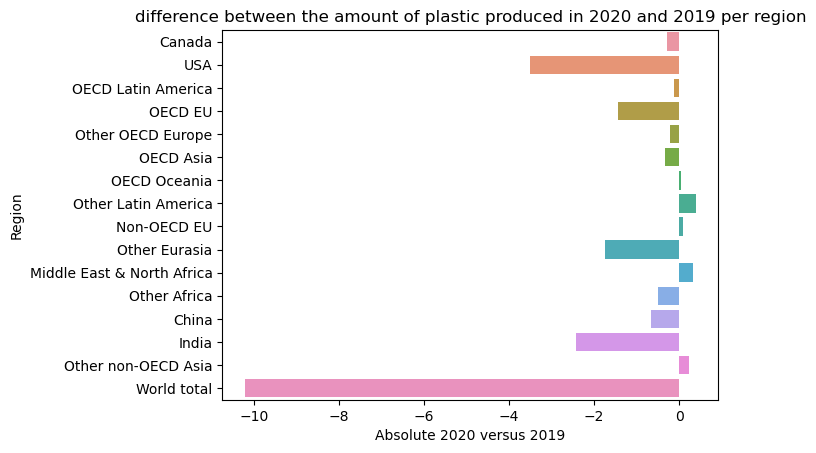

In [111]:
sns.barplot(data=oecd, x="Absolute 2020 versus 2019", y="Region").set(title="difference between the amount of plastic produced in 2020 and 2019 per region")

[Text(0.5, 1.0, 'global plastic production per year from 1950 to 2019')]

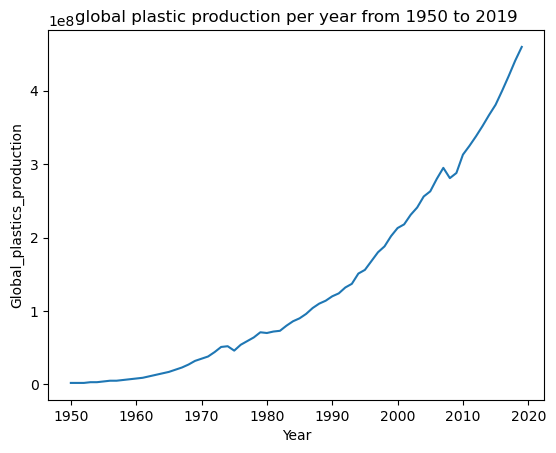

In [112]:
# we dont have 2020 data here
sns.lineplot(data=global_plastic, x="Year", y="Global_plastics_production").set(title="global plastic production per year from 1950 to 2019")

Now we want to fit a regression model in order to predict what will be the global plastic production in 2020 given the data from 1950 to 2019, the goal is to see how much higher that number would have been if covid was not there 

In [113]:
mod = smf.ols(
    formula="Global_plastics_production ~ +np.exp(Year/1950) +Year ",
    data=global_plastic,
)
model = mod.fit()
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     Global_plastics_production   R-squared:                       0.996
Model:                                    OLS   Adj. R-squared:                  0.996
Method:                         Least Squares   F-statistic:                     8739.
Date:                        Thu, 22 Dec 2022   Prob (F-statistic):           9.89e-82
Time:                                17:54:24   Log-Likelihood:                -1212.6
No. Observations:                          70   AIC:                             2431.
Df Residuals:                              67   BIC:                             2438.
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

Text(0.5, 1.0, 'The regression model')

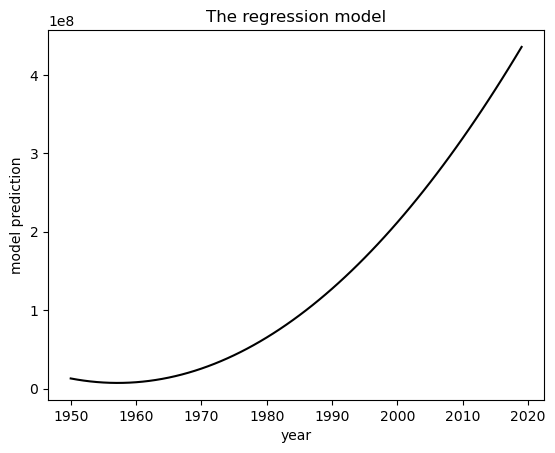

In [114]:
X = global_plastic["Year"]
plt.plot(X, model.predict(X), color="k", label="Regression model")

plt.xlabel('year') 
plt.ylabel('model prediction') 
plt.title('The regression model') 

In [115]:
data = dict(Year=2020)

d2020 = pd.DataFrame(data, index=[0])
plastic_prediction_2020_if_not_covid = model.predict(d2020)
real_plastic_prodction_2020=oecd['2020'][49]*10**6

In [116]:
poucentage_de_reduction=((real_plastic_prodction_2020 - plastic_prediction_2020_if_not_covid) / plastic_prediction_2020_if_not_covid) * 100
print(poucentage_de_reduction[0])

-0.062373006227152146


We can see that compared to our prediction the amount of plastic produced in 2020 is 0.06% smaller

## Studying the plastic production in the EU
In the first part we study the plastic produced for food packaging, Then the whole amount of plastic produced 

In [117]:
eu_plastic_packaging = pd.read_csv(
    "Data/Additional/plastic/sts_inpr_m__custom_3782744_linear.csv"
)
# source= https://ec.europa.eu/eurostat/databrowser/view/STS_INPR_M/default/table?lang=en production of plastic packages in europe

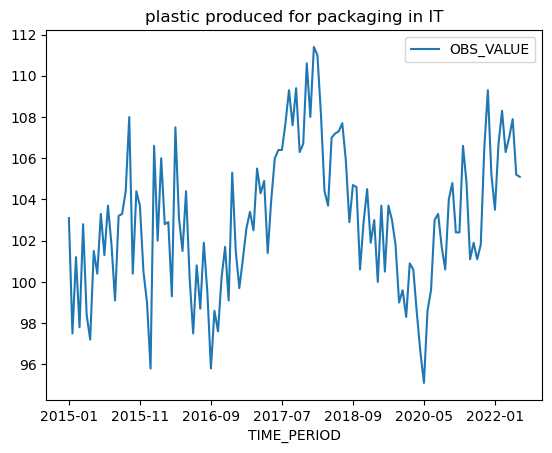

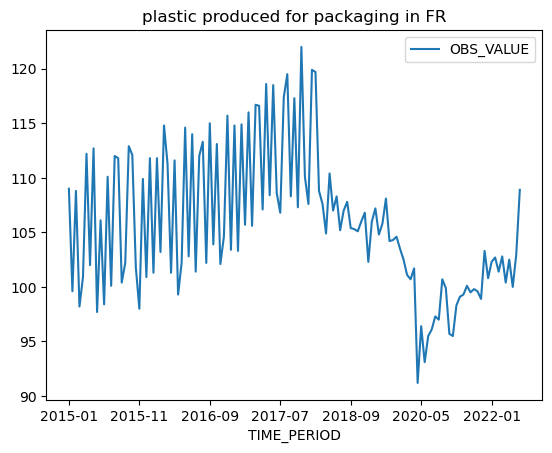

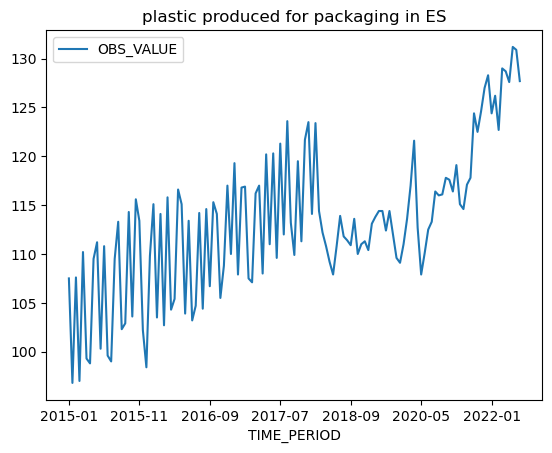

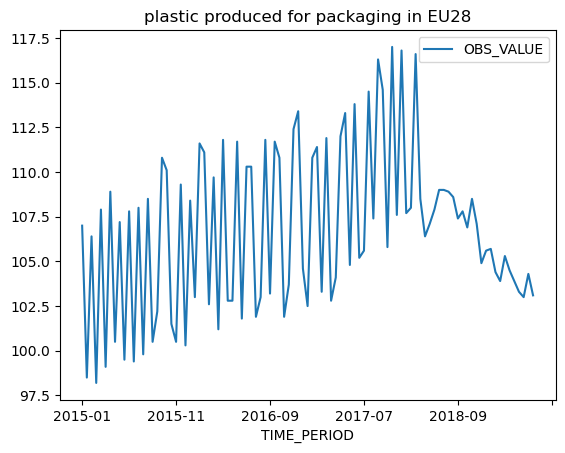

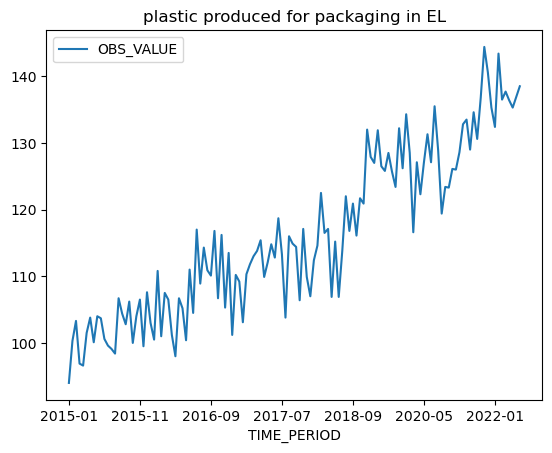

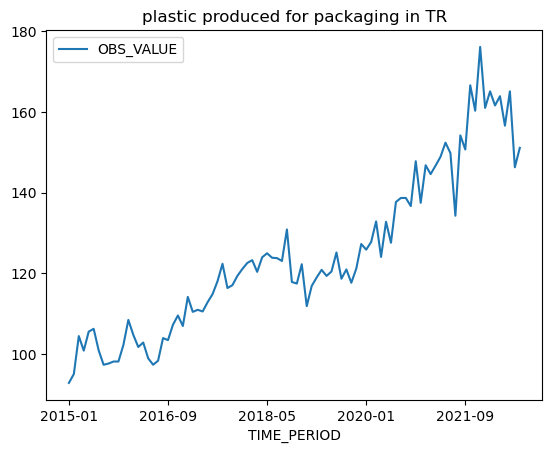

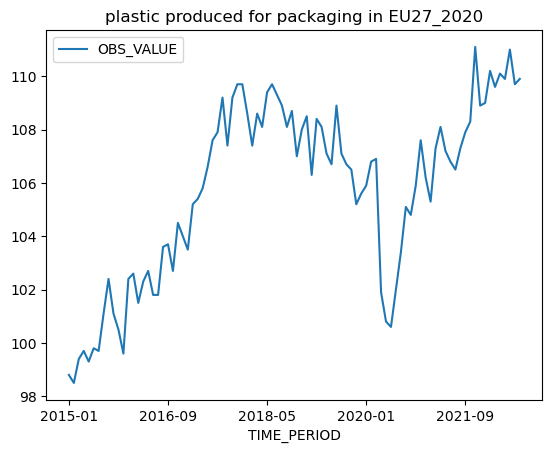

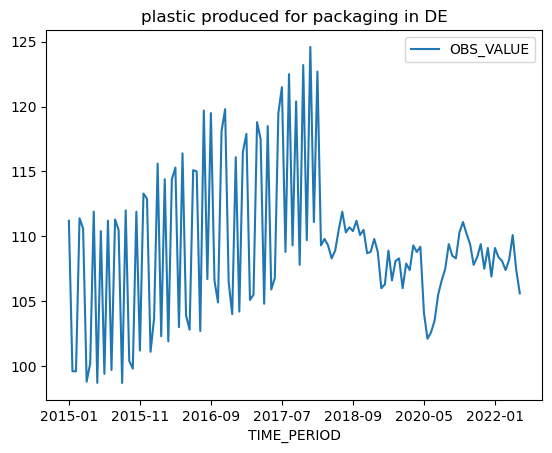

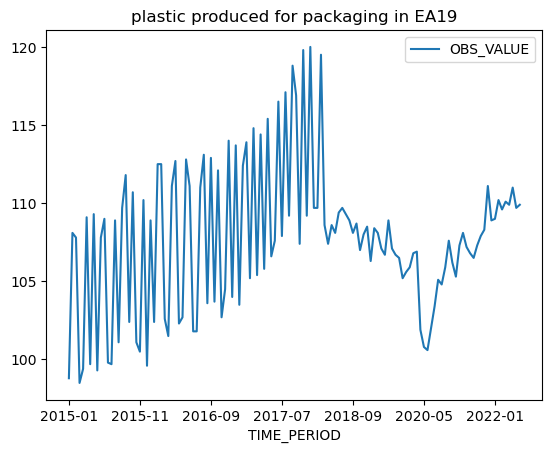

In [118]:
eu_nace_r2_c222 = eu_plastic_packaging[eu_plastic_packaging["nace_r2"] == "C2222"].sort_values("TIME_PERIOD")

for region in set(eu_nace_r2_c222["geo"]):
    df = eu_nace_r2_c222[eu_nace_r2_c222["geo"] == region]
    if len(df["OBS_VALUE"].dropna()) == 0:
        continue

    df.plot.line(
        x="TIME_PERIOD", y="OBS_VALUE", title="plastic produced for packaging in " +region, rot=0
    )

Notice the drop around 2020

In [119]:
new = eu_plastic_packaging[
    (eu_plastic_packaging["nace_r2"] == "C2222")
    & (eu_plastic_packaging["TIME_PERIOD"] >= "2020-01")
]
old = eu_plastic_packaging[
    (eu_plastic_packaging["nace_r2"] == "C2222")
    & (eu_plastic_packaging["TIME_PERIOD"] < "2020-01")
]

for each region we compare the production before and after covid to see how the pandemic affected the production

In [120]:
for region in set(
    eu_plastic_packaging[eu_plastic_packaging["nace_r2"] == "C2222"]["geo"]
):
    if region=='IE' or region=='UK' or region=='EU28': # we have no data for these 
        continue
    print(
        "difference in the mean ammount of plastic produced before and after covid in "+region,
        stats.ttest_ind(
            new[new["geo"] == region]["OBS_VALUE"].dropna(),
            old[old["geo"] == region]["OBS_VALUE"].dropna(),
        ),
    )

difference in the mean ammount of plastic produced before and after covid in IT Ttest_indResult(statistic=0.1874347017555443, pvalue=0.8516213117255758)
difference in the mean ammount of plastic produced before and after covid in FR Ttest_indResult(statistic=-7.84751909778192, pvalue=1.5225000977245244e-12)
difference in the mean ammount of plastic produced before and after covid in ES Ttest_indResult(statistic=7.665508815722206, pvalue=4.028908308019724e-12)
difference in the mean ammount of plastic produced before and after covid in EL Ttest_indResult(statistic=11.450754284714431, pvalue=3.011158391140717e-21)
difference in the mean ammount of plastic produced before and after covid in EU27_2020 Ttest_indResult(statistic=2.5313710264301355, pvalue=0.013097367301850519)
difference in the mean ammount of plastic produced before and after covid in TR Ttest_indResult(statistic=14.08859776353546, pvalue=1.729091479313658e-24)
difference in the mean ammount of plastic produced before and a

it seems for France and Germany the data shows a significant drop in production, while for spain Greece and turkey we see an increase

In [121]:
# Manufacture of plastics products by month by country
full_plastic_production = pd.read_csv(
    "Data/Additional/plastic/sts_inpr_m__custom_3857183_linear.csv"
)
# source: https://ec.europa.eu/eurostat/databrowser/view/STS_INPR_M__custom_3857183/default/table?lang=en

In [122]:
full_plastic_production = full_plastic_production[
    full_plastic_production["TIME_PERIOD"] >= "2018-01"
]

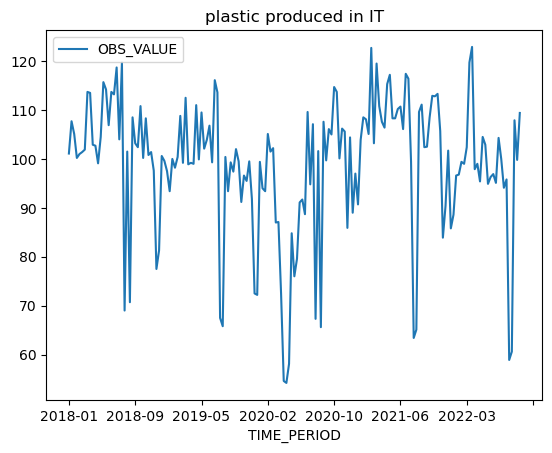

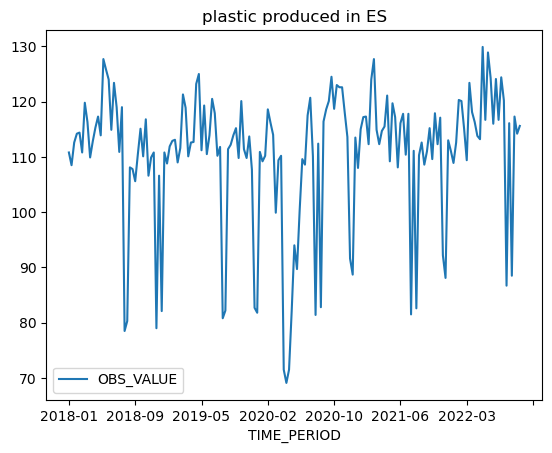

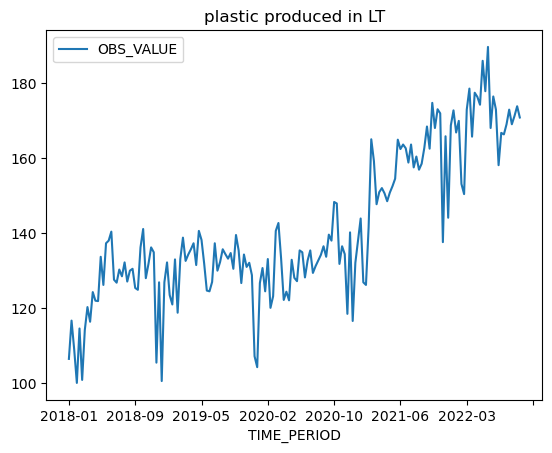

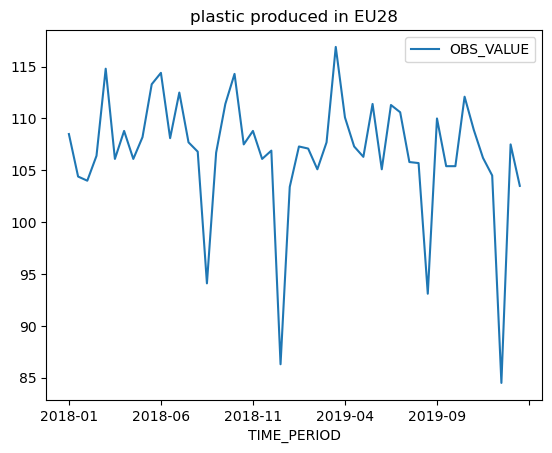

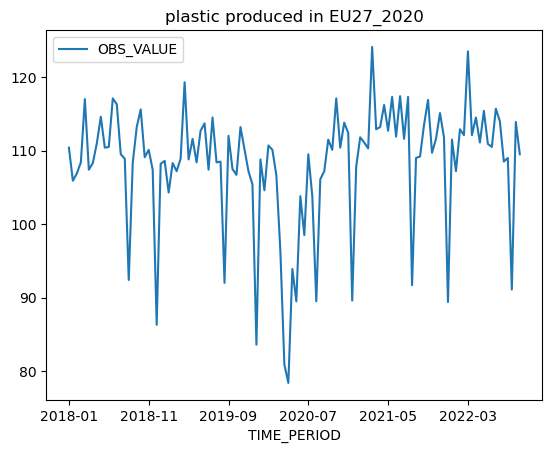

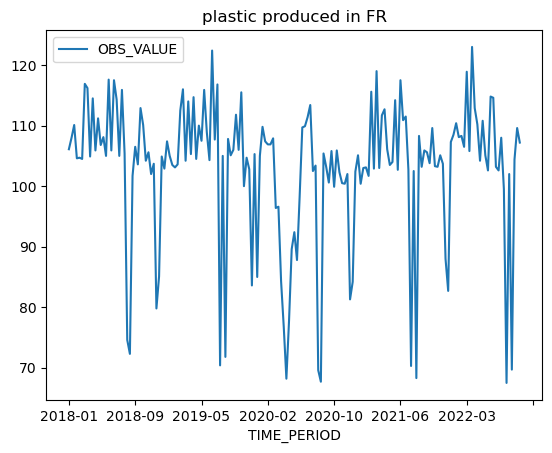

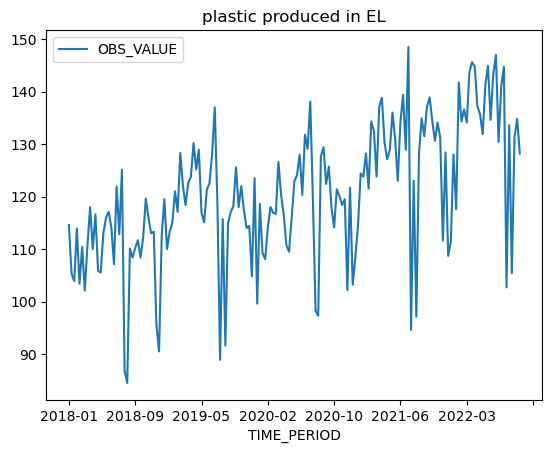

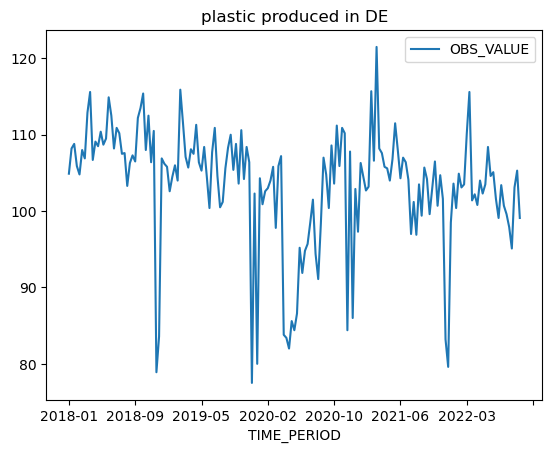

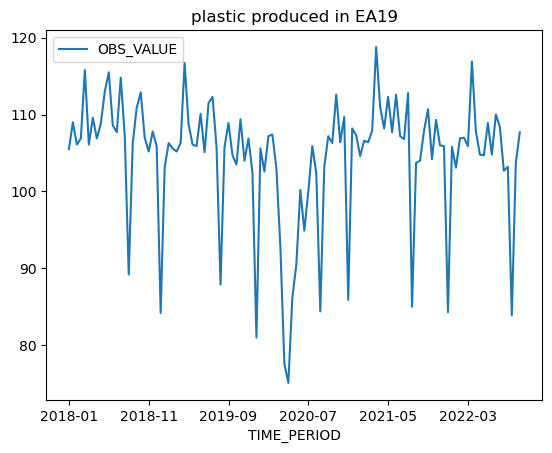

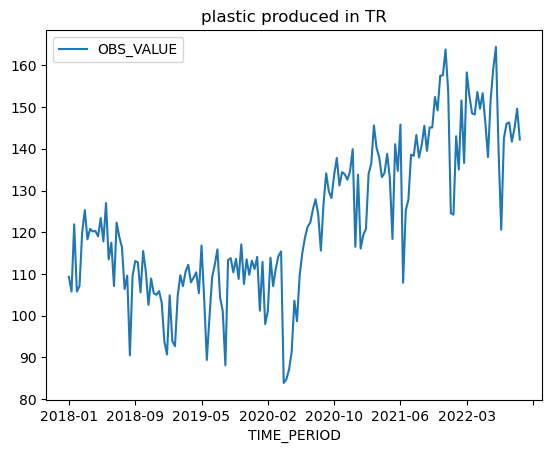

In [123]:
r2_c222 = full_plastic_production[full_plastic_production["nace_r2"] == "C222"].sort_values("TIME_PERIOD")
for region in set(r2_c222["geo"]):
    df = r2_c222[r2_c222["geo"] == region]
    if len(df["OBS_VALUE"].dropna()) == 0:
        continue

    df.plot.line(x="TIME_PERIOD", y="OBS_VALUE", title="plastic produced in " +region, rot=0)

notice how the drop during 2020 usually wider than the others and slightly deeper

## Study of the recycling rates and recovery rates
The goal here is to see how the recycling and recovery rates were affected by covid, since if we see a drop in plastic production it would be hard to state that it would lead to a drop in plastic pollution without studying first how covid impacted plastic management facilities.

source: https://ec.europa.eu/eurostat/databrowser/view/TEN00063__custom_3793752/default/table?lang=en

Recycling rates for packaging waste

In [124]:
Recycling_rates_eu = pd.read_csv(
    "Data/Additional/plastic/ten00063__custom_3793752_linear.csv"
)

In [125]:
# we filter for plastic waste
Recycling_rates_eu = Recycling_rates_eu[Recycling_rates_eu["waste"] == "W150102"]

In [126]:
stats.ttest_ind(
    Recycling_rates_eu[Recycling_rates_eu["TIME_PERIOD"] == 2020]["OBS_VALUE"],
    Recycling_rates_eu[Recycling_rates_eu["TIME_PERIOD"] == 2019]["OBS_VALUE"],
)

Ttest_indResult(statistic=-1.0725985166419096, pvalue=0.2888144167933384)

The data shows that the recycling rates are unaffected by covid, thus we can conclude that the recycling rates did not change from 2019 to 2020

Rate of recovery or incineration at waste incineration plants with energy recovery’ for the purposes of Article 6(1) of Directive 94/62/EC means the total quantity of packaging waste recovered or incinerated at waste incineration plants with energy recovery, divided by the total quantity of generated packaging waste https://ec.europa.eu/eurostat/databrowser/view/ten00062/default/table?lang=en

In [127]:
recovery_rates_eu = pd.read_csv("Data/Additional/plastic/ten00062_linear.csv")
recovery_rates_eu = recovery_rates_eu[recovery_rates_eu["waste"] == "W150102"]

In [128]:
stats.ttest_ind(
    recovery_rates_eu[recovery_rates_eu["TIME_PERIOD"] == 2020]["OBS_VALUE"],
    recovery_rates_eu[recovery_rates_eu["TIME_PERIOD"] == 2019]["OBS_VALUE"],
)

Ttest_indResult(statistic=0.08560441171826655, pvalue=0.932136971130831)

The data shows that the recovery rates are unaffected by covid, thus we can conclude that the recovery rates did not change from 2019 to 2020

## Study of the waste generated by households

In [129]:
eu_waste = pd.read_csv("Data/Additional/plastic/ten00110_linear.csv")
# https://ec.europa.eu/eurostat/databrowser/view/TEN00110/default/table?lang=en&category=env.env_was.env_wasgt

In [130]:
eu_waste = eu_waste[eu_waste["waste"] == "TOTAL"]

In [131]:
eu_waste[eu_waste["TIME_PERIOD"] == 2020]

DATAFLOW        LAST UPDATE freq unit    hazard nace_r2  \
8    ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
11   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
20   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
29   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
38   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
47   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
56   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
65   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
74   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
81   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
90   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
97   ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
114  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
123  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
131  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
140  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
163  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
178  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
187  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
196  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
201  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
207  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
216  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
223  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
232  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
241  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
250  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
259  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
265  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
274  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
283  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
292  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
301  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   
314  ESTAT:TEN00110(1.0)  13/09/22 11:00:00    A    T  HAZ_NHAZ   EP_HH   

     waste        geo  TIME_PERIOD  OBS_VALUE OBS_FLAG  
8    TOTAL         AT         2020    4630301      NaN  
11   TOTAL         BA         2020     902567      NaN  
20   TOTAL         BE         2020    5342390      NaN  
29   TOTAL         BG         2020    2312155      NaN  
38   TOTAL         CY         2020     378382      NaN  
47   TOTAL         CZ         2020    6108373      NaN  
56   TOTAL         DE         2020   38474001      NaN  
65   TOTAL         DK         2020    3617933      NaN  
74   TOTAL         EE         2020     550331      NaN  
81   TOTAL         EL         2020    4420481        p  
90   TOTAL         ES         2020   23257379      NaN  
97   TOTAL  EU27_2020         2020  203660000        s  
114  TOTAL         FI         2020    2475453      NaN  
123  TOTAL         FR         2020   33543535      NaN  
131  TOTAL         HR         2020    1212068      NaN  
140  TOTAL         HU         2020    4673721      NaN  
163  TOTAL         IT         2020   28945093      NaN  
178  TOTAL         LT         2020    1397018      NaN  
187  TOTAL         LU         2020     202250      NaN  
196  TOTAL         LV         2020     644390      NaN  
201  TOTAL         ME         2020     230684      NaN  
207  TOTAL         MK         2020          0      NaN  
216  TOTAL         MT         2020     196079      NaN  
223  TOTAL         NL 

[Text(0.5, 1.0, 'Household waste generated per year in the EU')]

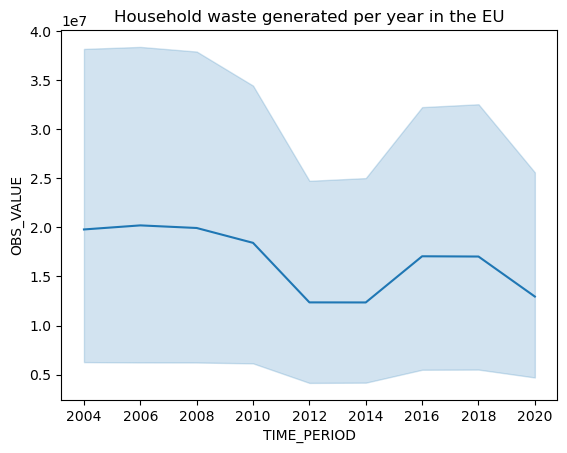

In [132]:
sns.lineplot(data=eu_waste, x="TIME_PERIOD", y="OBS_VALUE").set(title="Household waste generated per year in the EU")

We can see a drop of 0.5 in 2020, however, due to the low amount of data the confidence intervals are quite large, so it would be hard to perform statistical tests and get a meaningful result

## Study of the total amount of waste generated by households and businesses

In [133]:
eu_waste = pd.read_csv("Data/Additional/plastic/ten00108_linear.csv")
eu_waste = eu_waste[eu_waste["waste"] == "TOTAL"]
# https://ec.europa.eu/eurostat/databrowser/view/TEN00108/default/table?lang=en&category=env.env_was.env_wasgt

[Text(0.5, 1.0, 'Total amount of waste generated by the EU and buisnesses')]

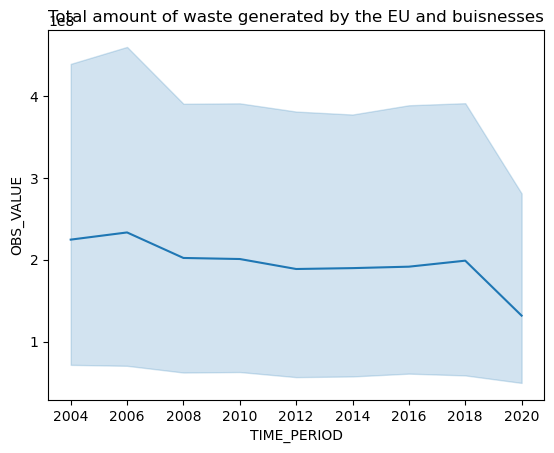

In [134]:
sns.lineplot(data=eu_waste, x="TIME_PERIOD", y="OBS_VALUE").set(title="Total amount of waste generated by the EU and buisnesses")

We can see a drop of almost 1 in 2020, however, due to the low amount of data the confidence intervals are quite large, so it would be hard to perform statistical tests and get a meaningful result

## Conclusion:
We saw that in some countries the plastic production experienced a significant decrease during covid, especially around 2020 we saw quite a drop probably due to lockdown. However, recycling rates and recovery rates did not experience significant change, More over The amount of waste generated decreased between 2018 and 2020 although one might question the validity of this due to a low amount of data.

Therefore with those results one might conclude that since less plastic was produced and with no impact on the recycling and recovery rates this might suggest that covid caused a drop plastic polution in the EU.


This analysis can be improved since one main issue is that the EU data lacks the data for some countries like Switzerland Poland and so on.
This causes some confidence intervals to inflate and thus makes some hypothesis hard to test.
We mainly focused on the EU and therefore we can improve it by adding other regions of the world.



# Part 3 : Studying the awareness versus the actual pollution

The goal is to establish whether there is a link between awareness (i.e. Wikipedia views) and actual ground measurements about pollution. We will perform two experiments for each country : 
- **intervention analysis** : we find the peak of wikipedia views for a given wikipedia subject or page in 2020 (the peak of awareness, which we call the intervention) and check whether this peak translates to a significant change in empirical pollution. 
- **granger causality testing** : we test whether a given timeseries (wikipedia views) can be used to linearly predict the future of another timeseries (say, pollution). This gives us a hint about the temporal relationship between two observations.

In [135]:
country_codes = sum_environment_df.language.unique()

In [136]:
capitals

['tokyo',
 'rome',
 'copenhagen',
 'ankara',
 'oslo',
 'washington',
 'stockholm',
 'belgrade',
 'amsterdam',
 'berlin',
 'paris',
 'barcelona',
 'seoul',
 'helsinki']

In [137]:
wikipedia_language_to_dataset = {
    'ja' : full_datasets[0], 
    'it' : full_datasets[1], 
    'da' : full_datasets[2],
    'tr' : full_datasets[3], 
    'no' : full_datasets[4], 
    'en' : full_datasets[5], 
    'sr' : full_datasets[7], #careful : we swap indices here 
    'sv' : full_datasets[6], 
    'nl' : full_datasets[8], 
    'de' : full_datasets[9], 
    'fr' : full_datasets[10], 
    'ca' : full_datasets[11], 
    'ko' : full_datasets[12], 
    'fi' : full_datasets[13]
}

In [138]:
{(k, v[0]) for (k, v) in wikipedia_language_to_dataset.items()}

{('ca', 'barcelona'),
 ('da', 'copenhagen'),
 ('de', 'berlin'),
 ('en', 'washington'),
 ('fi', 'helsinki'),
 ('fr', 'paris'),
 ('it', 'rome'),
 ('ja', 'tokyo'),
 ('ko', 'seoul'),
 ('nl', 'amsterdam'),
 ('no', 'oslo'),
 ('sr', 'belgrade'),
 ('sv', 'stockholm'),
 ('tr', 'ankara')}

First, we will perform intervention analysis. The first thing we need is to find the peaks of awareness in all fourteen countries in the environment dataset.

In [139]:
peak2020 = {}
for code in country_codes:
    datapoints = sum_environment_df[sum_environment_df.language == code]
    datapoints = datapoints[datapoints.date.dt.year == 2020]
    peak = datapoints.environment_views.max()
    peakline = datapoints[datapoints.environment_views == peak].iloc[0]
    peak2020[code] = peakline['date']

In [140]:
peak2020

{'ja': Timestamp('2020-05-06 00:00:00'),
 'it': Timestamp('2020-04-22 00:00:00'),
 'da': Timestamp('2020-01-14 00:00:00'),
 'tr': Timestamp('2020-01-25 00:00:00'),
 'no': Timestamp('2020-01-08 00:00:00'),
 'en': Timestamp('2020-01-13 00:00:00'),
 'sr': Timestamp('2020-04-24 00:00:00'),
 'sv': Timestamp('2020-02-09 00:00:00'),
 'nl': Timestamp('2020-02-09 00:00:00'),
 'de': Timestamp('2020-02-09 00:00:00'),
 'fr': Timestamp('2020-01-27 00:00:00'),
 'ca': Timestamp('2020-04-16 00:00:00'),
 'ko': Timestamp('2020-04-13 00:00:00'),
 'fi': Timestamp('2020-04-01 00:00:00')}

Now that we have all peaks, we can look at the 365 previous days and the 365 following years in air pollution and analyze whether there is a significant difference in air quality. This will give us an idea of the relationship between awareness of environment problems and the actual state of the environment.

#### Can wikipedia awareness be used to model an intervention in the air pollution ?

At first, let us visualize the data which we analyze : we want to see whether there is a significant difference of air quality before and after the wikipedia views peak of 2020. We will look at both the full timeseries with a change of color at the date of the peak, along with a boxplot to show the difference in quartile-based statistics.

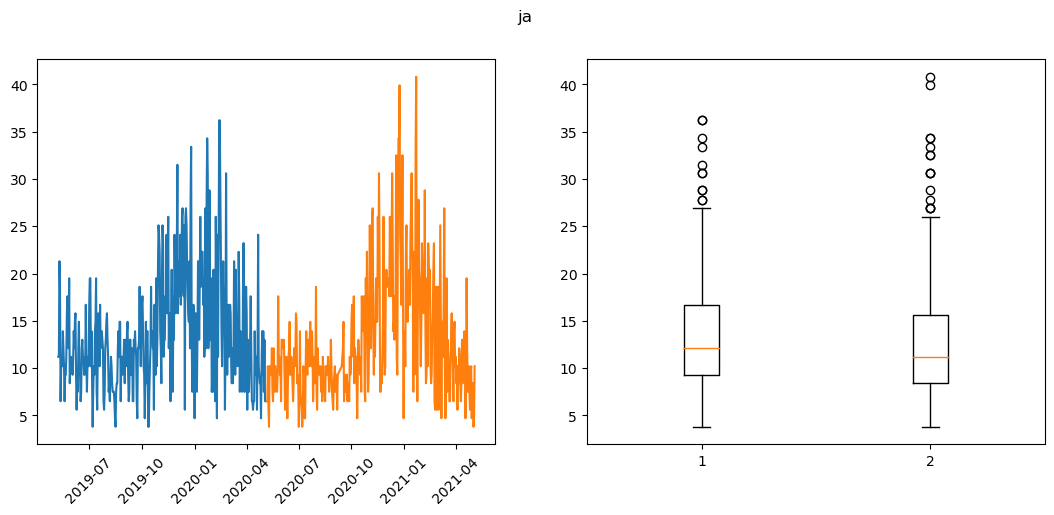

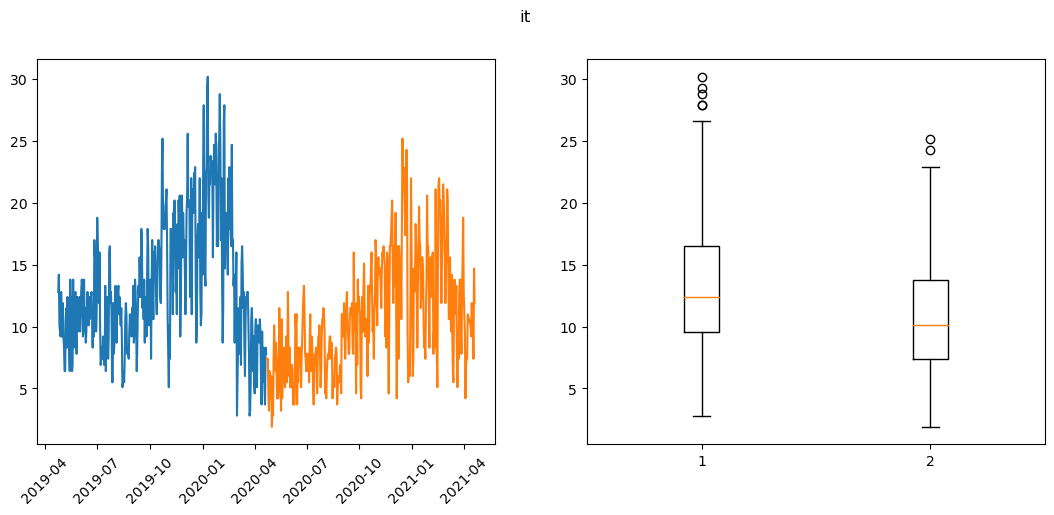

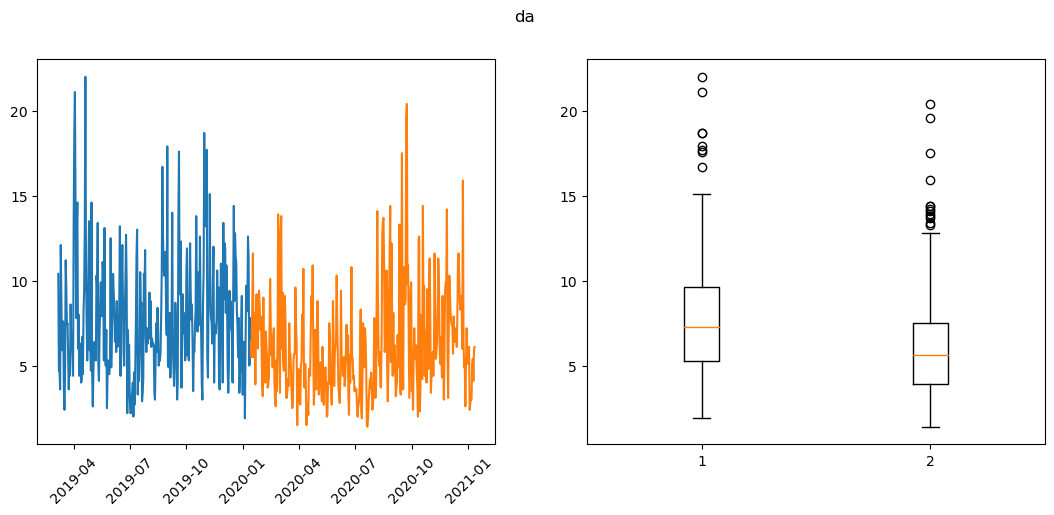

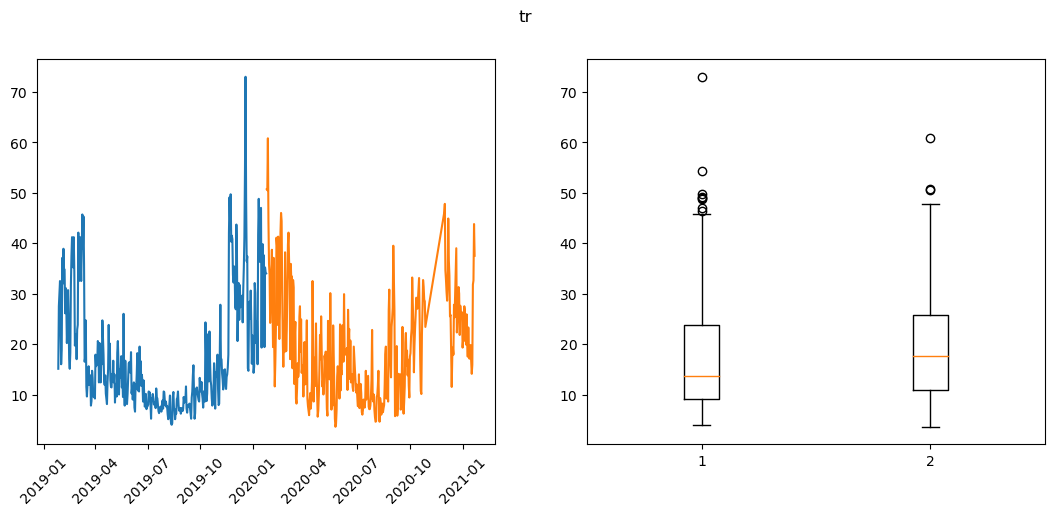

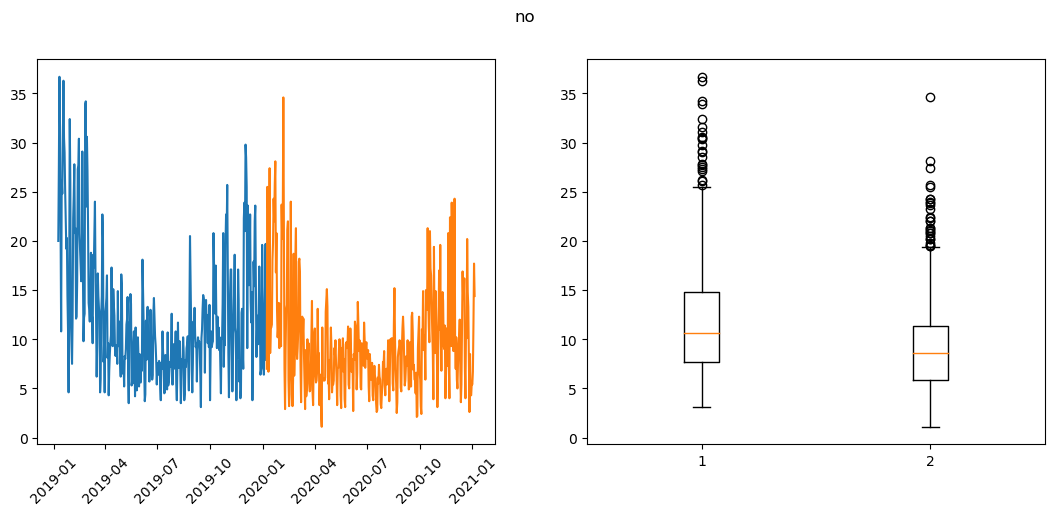

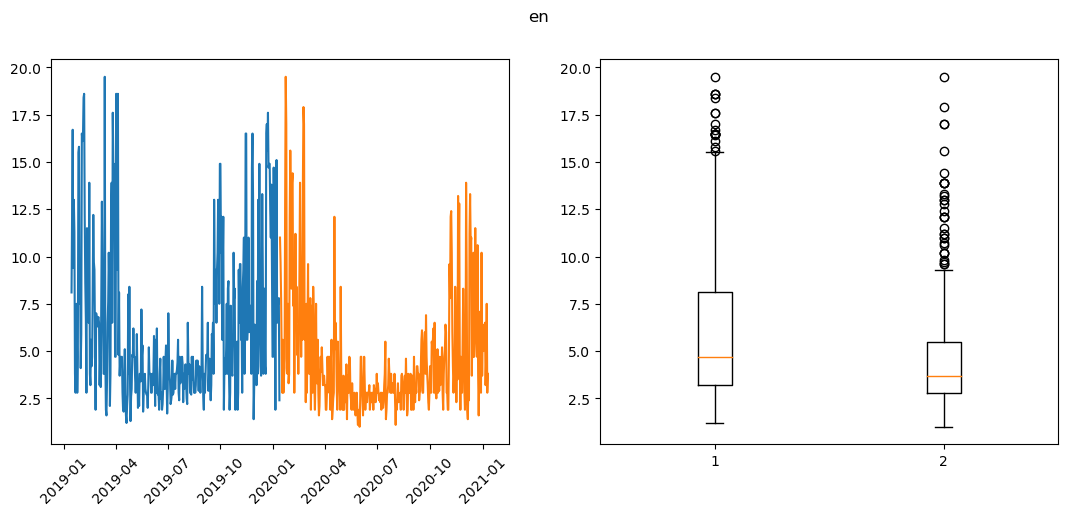

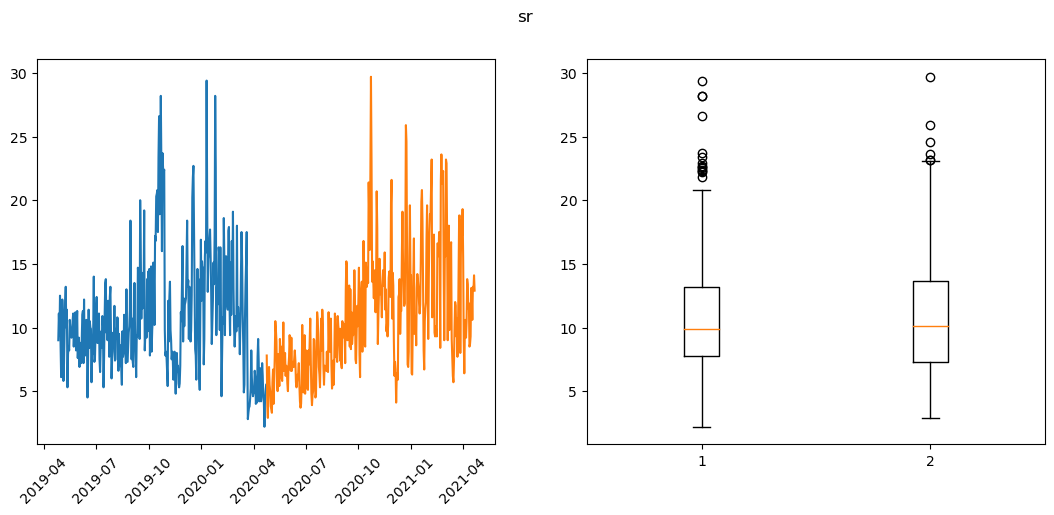

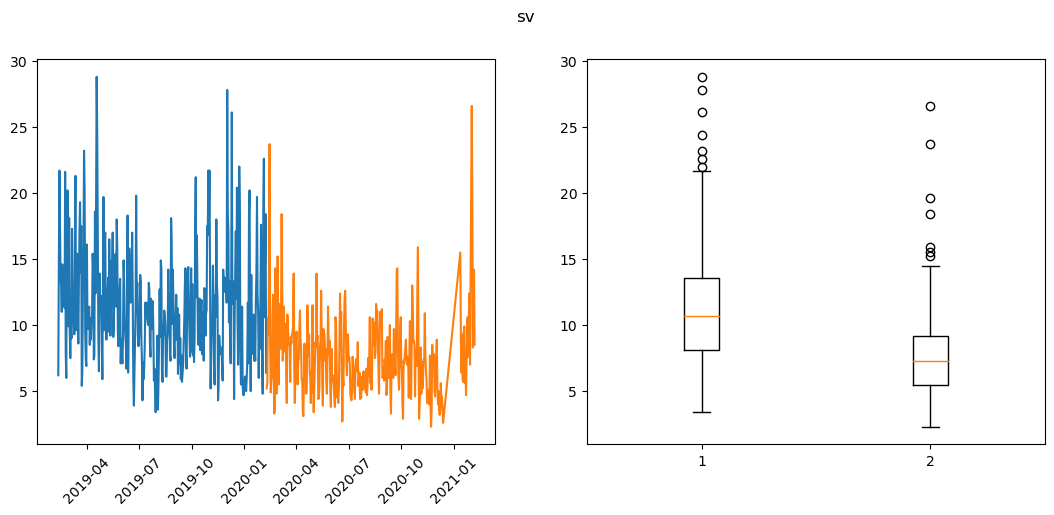

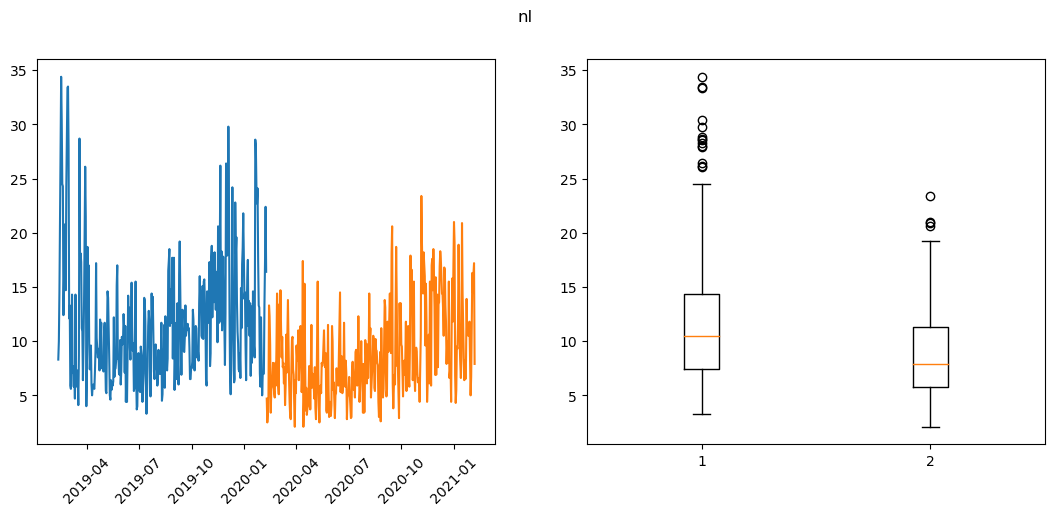

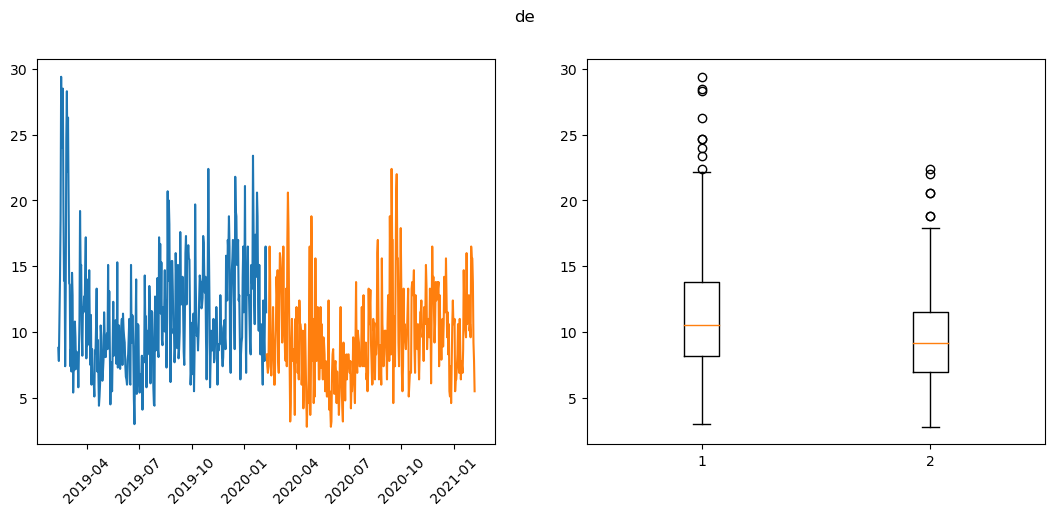

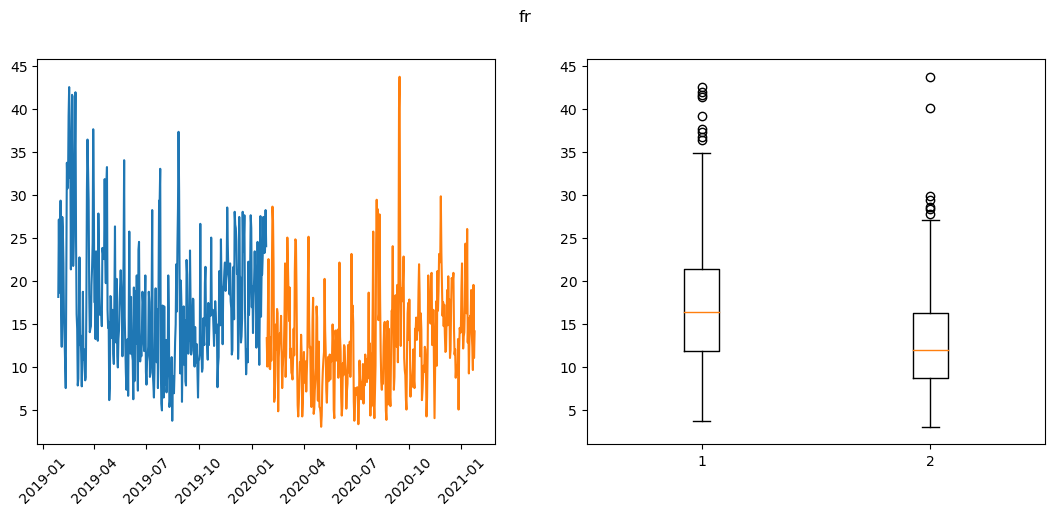

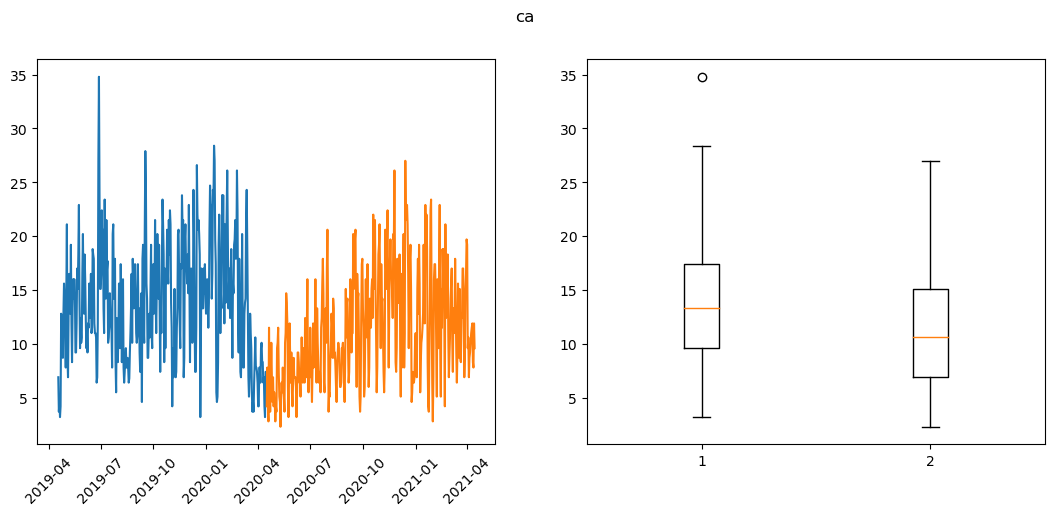

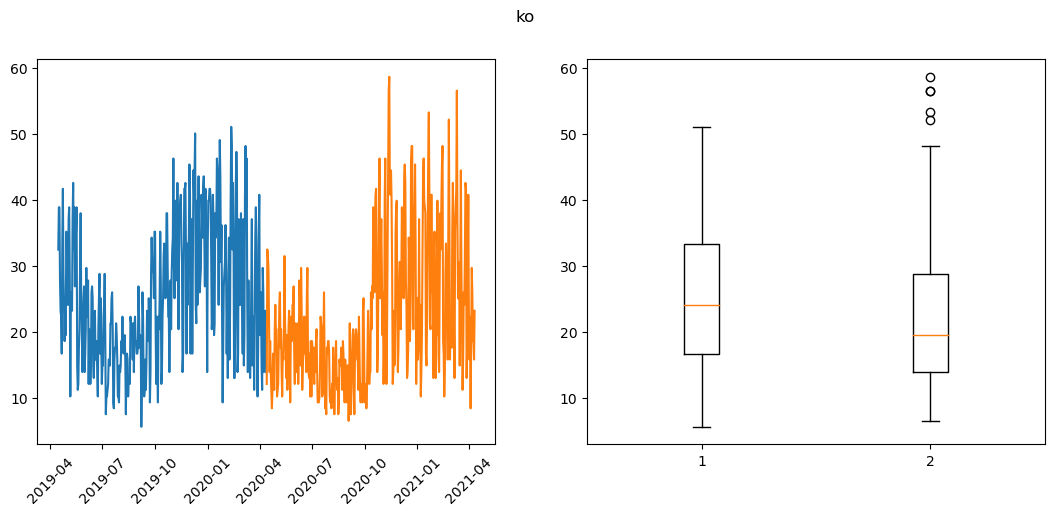

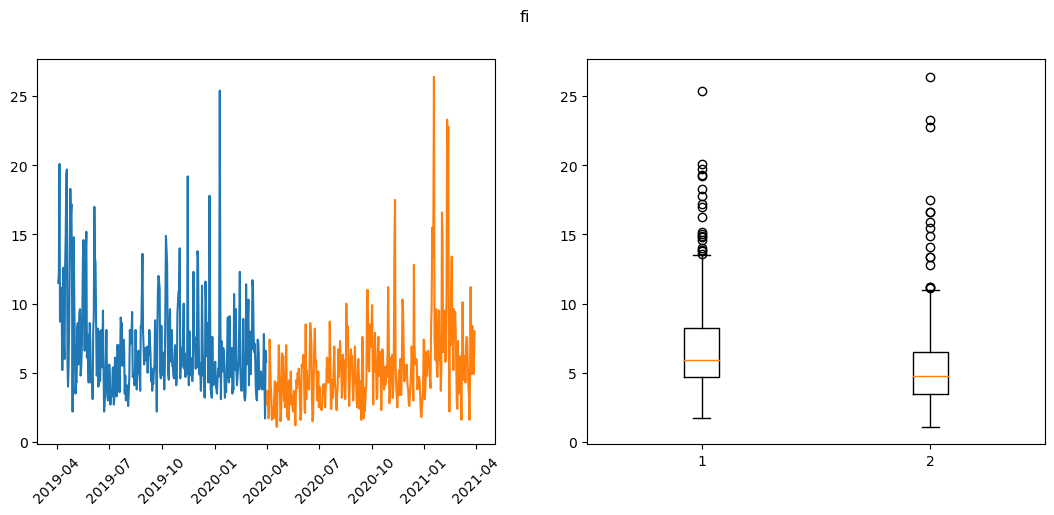

In [141]:
results = []
for code in country_codes:
    dataset = wikipedia_language_to_dataset[code][1]
    dataset["dt"] = pd.to_datetime(dataset.Date)
    dataset["yearless"] = dataset.Date.str[5:]
    peak = peak2020[code]
    
    before = dataset[(dataset["dt"] >= peak - datetime.timedelta(weeks=52)) & (dataset["dt"] < peak)][['Date', 'median']]
    after  = dataset[(dataset["dt"] < peak + datetime.timedelta(weeks=52)) & (dataset["dt"] >= peak)][['Date', 'median']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(code)
    fig.set_size_inches(13, 5)
    ax1.plot_date(matplotlib.dates.datestr2num(before["Date"]), before['median'], tz="UTC+1", fmt="-")
    ax1.plot_date(matplotlib.dates.datestr2num(after["Date"]), after['median'], tz="UTC+1", fmt="-")
    
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    ax2.boxplot([before["median"], after["median"]])
    plt.show()


Here's a few interesting results by themselves : 
- First of all, most countries visibly have less air pollution after the peak of their environment Wikipedia page of 2020. We will analyze this further in the next cell. That alone is however not enough to explain the whole story : both periods of 365 days have strong similarities
- Analyzing in that direction, there seems to be a group of countries that stand out : Japan, Italy, Turkey, Norway, the U.S., Serbia, the Netherlands, Norway, Korea and Finland all have a air pollution that is U-shaped, meaning they are highly seasonal and binary (summer = no pollution, winter = strong pollution). France and Germany also show a similar behavior, but with a seemingly higher variance. This is hardly the case for the last two : Denmark and Sweden are less well-behaved in terms a pollution seasonality. Looking at it globally, we can conclude that there is a strong seasonality of pollution wordlwide.

Then, we can dig into the significance of these results : is it generally true that the peak of awareness marks a significant difference in air quality in a given country ? 

In [142]:
results = []
for code in country_codes:
    dataset = wikipedia_language_to_dataset[code][1]
    dataset["dt"] = pd.to_datetime(dataset.Date)
    dataset["yearless"] = dataset.Date.str[5:]
    peak = peak2020[code]
    
    before = dataset[(dataset["dt"] >= peak - datetime.timedelta(weeks=52)) & (dataset["dt"] < peak)][['yearless', 'median']]
    after  = dataset[(dataset["dt"] < peak + datetime.timedelta(weeks=52)) & (dataset["dt"] >= peak)][['yearless', 'median']]
    
    yearComp = before.merge(after, on='yearless')
    pval = stats.ttest_rel(yearComp['median_x'], yearComp['median_y']).pvalue
    evolution = (
        "{:+.2f}".format(
            ((np.mean(yearComp.median_y) / np.mean(yearComp.median_x)) - 1) * 100
        )
        + "%"
    )
    sig_alone = pval < 0.05
    sig_bonf = pval < 0.05/14
    results.append((code, pval, evolution, sig_alone, sig_bonf))
    
pd.DataFrame(results, columns = ['country', 'pvalue', 'evolution', 'sig_alone', 'sig_bonferonni'])

country        pvalue evolution  sig_alone  sig_bonferonni
0       ja  2.304755e-02    -6.14%       True           False
1       it  2.531780e-17   -20.40%       True            True
2       da  7.471536e-11   -21.91%       True            True
3       tr  8.518085e-05   +13.38%       True            True
4       no  2.573419e-13   -22.45%       True            True
5       en  2.843803e-11   -26.77%       True            True
6       sr  8.936576e-01    +0.37%      False           False
7       sv  8.817333e-32   -32.90%       True            True
8       nl  7.051390e-15   -24.23%       True            True
9       de  5.742731e-10   -15.10%       True            True
10      fr  1.307957e-17   -25.48%       True            True
11      ca  9.359090e-11   -18.59%       True            True
12      ko  3.694718e-06   -11.62%       True            True
13      fi  1.257217e-07   -20.82%       True            True

These results are in line with the rest of the air pollution analysis earlier : countries significantly reduced their air pollution between these two periods. The only exception is again Turkey. This [Wikipedia page](https://en.wikipedia.org/wiki/Air_pollution_in_Turkey#Nitrogen_oxides) gives a bit of an explanation : NOx car pollution and lack of pollution regulation are a large part of the problem. We however could not explain why the pollution goes up instead of stagnating, for example. Serbia also shows a slight increase in air pollution, but this is not a significant change from before the peak.

#### What can we conclude from this analysis of view peak vs. air pollution ?

We can establish that for the capitals of most countries studied here, **air pollution can reasonably be used as an intervention in air pollution**. However, this is not a causal analysis : we cannot really claim that awareness made the pollution go down, because of two related remarks. First, there is a strong confounder : Covid probably made people read the wikipedia page about air pollution, and at the same time made them pollute less. Second, we cannot establish causality in such sequential data, as we would need to also witness an alternative universe where covid did not happen. It is however not out of the question that awareness causes a drop in pollution : being locked down during Covid, people may have had more time to learn and think about their environment.

Bad news aside, we did learn some facts : air pollution gets significantly better after people are most aware about the problem of air pollution in their respective country. 

### Daily views vs actual pollution

We can also ask a related but different question : is it true that the value of wikipedia views of the environment topic can linearly predict the air pollution ? 

Here, the Granger test can help us. The [Granger causality test](https://en.wikipedia.org/wiki/Granger_causality) is a hypothesis testing tool that takes two time-series as input and checks whether the first one is a good linear predictor for the values of the next. It enables us to do some lag analysis, for example verifying whether the past of the first time series can predict the value of the other at a future day. Here's the implementation we will use :

In [143]:
grangercausalitytests?

Signature: grangercausalitytests(x, maxlag, addconst=True, verbose=True)
Docstring:
Four tests for granger non causality of 2 time series.

All four tests give similar results. `params_ftest` and `ssr_ftest` are
equivalent based on F test which is identical to lmtest:grangertest in R.

Parameters
----------
x : array_like
    The data for testing whether the time series in the second column Granger
    causes the time series in the first column. Missing values are not
    supported.
maxlag : {int, Iterable[int]}
    If an integer, computes the test for all lags up to maxlag. If an
    iterable, computes the tests only for the lags in maxlag.
addconst : bool
    Include a constant in the model.
verbose : bool
    Print results.

Returns
-------
dict
    All test results, dictionary keys are the number of lags. For each
    lag the values are a tuple, with the first element a dictionary with
    test statistic, pvalues, degrees of freedom, the second element are
    the OLS estimation re

Since we are concerned with data that goes beyond what the original Coronawiki dataset gives us, we can load the extended version that goes further than 2020.

We loaded all wikipedia views on the environment topic from 2015-07 to the end of 2022. This extends the data in both directions, giving us more datapoints to merge with the air quality.

In [144]:
sum_environment_extended = pd.read_csv("Data/Additional/langviews/final/aggregated_views.csv")
sum_environment_extended.date = pd.to_datetime(sum_environment_extended.date)

In [145]:
sum_environment_extended

ja       it      da       tr      no         en       sr       sv  \
0     182122.0  77640.0  4067.0  16321.0  5386.0  1519066.0   2334.0  12743.0   
1     201826.0  72749.0  3874.0  15493.0  5663.0  1438586.0   2310.0  13477.0   
2     170885.0  68917.0  3758.0  15131.0  5297.0  1293716.0   1938.0  13601.0   
3     154506.0  59069.0  3891.0  32832.0  5101.0  1167907.0   1860.0  16422.0   
4     181196.0  67898.0  5367.0  18967.0  6428.0  1331215.0   2465.0  18411.0   
...        ...      ...     ...      ...     ...        ...      ...      ...   
2696  133494.0  82921.0  5805.0  39317.0  8255.0  1525641.0   9441.0  22762.0   
2697  156458.0  72549.0  5385.0  39910.0  7559.0  1395392.0   8668.0  20617.0   
2698  110291.0  71071.0  4349.0  32031.0  5803.0  1280768.0   7632.0  17542.0   
2699  123332.0  85384.0  5613.0  41407.0  7168.0  1418026.0  10264.0  20283.0   
2700       0.0      0.0     0.0      0.0     0.0        0.0      0.0      0.0   

           nl        de        fr       ca       ko       fi      total  \
0     32902.0  209406.0  124421.0   2601.0  14987.0   9054.0  2213050.0   
1     30745.0  204013.0  114584.0   2876.0  13309.0   8739.0  2128244.0   
2     25835.0  176506.0  105264.0   2321.0  15551.0   8254.0  1906974.0   
3     26814.0  159996.0   99934.0   2328.0  12892.0   7924.0  1751476.0   
4     35109.0  217275.0  112298.0   3086.0  14841.0  10258.0  2024814.0   
...       ...       ...       ...      ...      ...      ...        ...   
2696  37995.0  176343.0  175445.0  10931.0  13706.0  17274.0  2259330.0   
2697  33013.0  155686.0  145484.0   9180.0  13698.0  16618.0  2080217.0   
2698  30480.0  143231.0  140873.0   5007.0  10185.0  13538.0  1872801.0   
2699  34610.0  190498.0  170235.0   6979.0  12222.0  15121.0  2141142.0   
2700      0.0       0.0       0.0      0.0      0.0      0.0        0.0   

           date  
0    2015-07-01  
1    2015-07-02  
2    2015-07-03  
3    2015-07-04  
4    2015-07-05  
...         ...  
2696 2022-11-17  
2697 2022-11-18  
2698 2022-11-19  
2699 2022-11-20  
2700 2022-11-21  

[2701 rows x 16 columns]

In [146]:
res = []
for code in country_codes:
    
    env = sum_environment_extended[[code, 'date']]
    air = wikipedia_language_to_dataset[code][1]
    merged = env.merge(air, left_on="date", right_on="dt")
    
    print(code)
                                                           #jesus the access patterns are annoying
    pval = grangercausalitytests(merged[['median', code]], [1])[1][0]['ssr_chi2test'][1]
    alone_sig = pval < 0.05
    bonf_sig = pval < 0.05/14
    
    res.append((code, pval, alone_sig, bonf_sig))
    
    print("\n\n===================\n")
    


ja

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2311  , p=0.6308  , df_denom=1392, df_num=1
ssr based chi2 test:   chi2=0.2316  , p=0.6304  , df=1
likelihood ratio test: chi2=0.2316  , p=0.6304  , df=1
parameter F test:         F=0.2311  , p=0.6308  , df_denom=1392, df_num=1



it

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.1622 , p=0.0000  , df_denom=1391, df_num=1
ssr based chi2 test:   chi2=37.2423 , p=0.0000  , df=1
likelihood ratio test: chi2=36.7535 , p=0.0000  , df=1
parameter F test:         F=37.1622 , p=0.0000  , df_denom=1391, df_num=1



da

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.8333 , p=0.0000  , df_denom=1348, df_num=1
ssr based chi2 test:   chi2=28.8974 , p=0.0000  , df=1
likelihood ratio test: chi2=28.5927 , p=0.0000  , df=1
parameter F test:         F=28.8333 , p=0.0000  , df_denom=1348, df_num=1



tr

Granger Causality
number of lags (no zero) 1
ssr based F test:    

In [147]:
air_poll_granger = pd.DataFrame(res)
air_poll_granger.columns = ["code", "pvalue", "alone_sig", "bonf_sig"]


In [148]:
air_poll_granger

code        pvalue  alone_sig  bonf_sig
0    ja  6.303586e-01      False     False
1    it  1.043243e-09       True      True
2    da  7.631437e-08       True      True
3    tr  6.566247e-04       True      True
4    no  4.064958e-11       True      True
5    en  2.404359e-07       True      True
6    sr  2.114904e-01      False     False
7    sv  4.970752e-16       True      True
8    nl  6.851376e-07       True      True
9    de  1.306614e-15       True      True
10   fr  6.544468e-14       True      True
11   ca  1.477775e-13       True      True
12   ko  2.171325e-01      False     False
13   fi  2.975978e-04       True      True

The p-values are very binary : either something is not significant alone, or it is significant even under the Bonferonni correction :

In [149]:
(air_poll_granger.alone_sig == air_poll_granger.bonf_sig).all()

True

In other words, there is no need for a finer correction like Benjamin-Hochberg FDR.

We find that for most countries, past wikipedia views make for a good linear predictor of the future of air pollution. This even holds for Turkey where the air pollution got worse during Covid.

An interesting case is that of Japan and South Korea which have very insignificant p-values (>.2), suggesting that day-to-day linear prediction is not very convincing for these two countries. We note that these are the only Eastern-Asian countries in the dataset. An interesting extension to this project could be to check whether this extends further to other countries in the area.

The odd one out is then Serbia, with a p-value of 0.21. There is an explanation which we find satisfying : while air pollution follows the same patterns as similar European countries, the wikipedia views on the environment topic in Serbia are fairly unusual when compared to neighboring countries. Indeed, there is a massive spike around 2020-04, the time at which Covid hit the country. Previously, the article had significnatly fewer views. For most other countries, the process was much more continuous. We see no particular reason as to why the awareness differs, but this explains why the Granger test sees no significant use of wikipedia views for predicting the air pollution.

For all others, the linear prediction works out fine. The model is confident that the past of the wikipedia views is a useful tool to predict the air pollution of the next day in the capital.

# Part 4 : What if ? and what happens next ?

In this final part, we want to create a hypothetical scenario of 2022 using statistical forecasting without the data from that year. The idea is to show whether the direction air pollution is taking is predictable, and where it is headed.

For the statistical forecasting, we will use the [SARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average#Variations_and_extensions) which enables the prediction of the future of a timeseries by using the previous data points and accounting for seasonality.

We will analyze the data in the following way : we will predict whether the air pollution in the period of 2022 can be meaningfully predicted from the previous years.
Ideally, the plan was to attempt to predict what would have heppened by training the model on air data from 2015 to 2019 and predicting 2020-2022, in order to compare with what actually happened.
It turns out, the air data is not available so long in the past. We had to modify the analysis to analyze from 2019-2021 and predict 2022, to give the model data on which it could be trained.
This modifies a bit the intent of the analysis. Instead of seeing whether there is a downwards perturbance in air pollution (which we already know happened), we now ask a slightly different question : "does the air pollution in 2022 significantly change from the trends of 2019-2021, and if so, what is the direction of the change?". This will give us insights into what the different countries have "learned". For example, a year 2022 that is unpredictably low in terms of air pollution means that the country has (for now) learned that it could survive without as much pollution.

There could be other explanations (the country never economically recovered from Covid, ...) but there is little we can do to account for this in time. Besides, speaking only in terms of air pollution, the conclusion is the same : the country is for the foreseeable future on its way to have a better air.

ja 



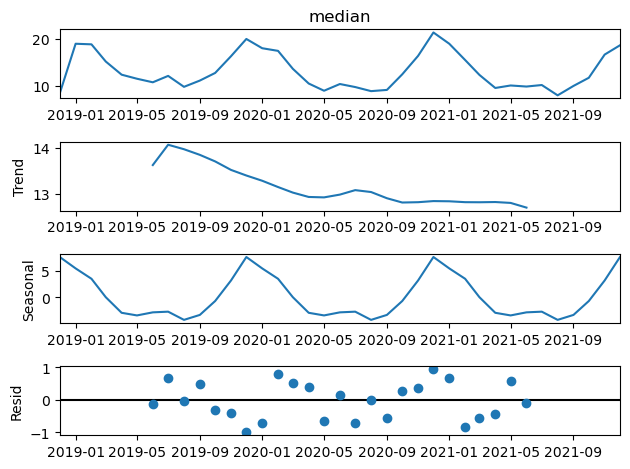

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.590071
         Iterations: 3
         Function evaluations: 248


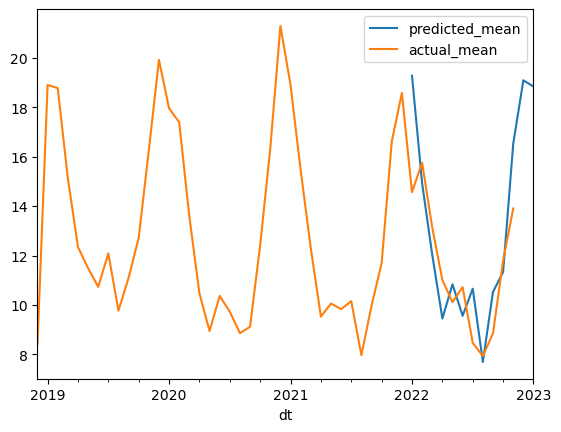





it 



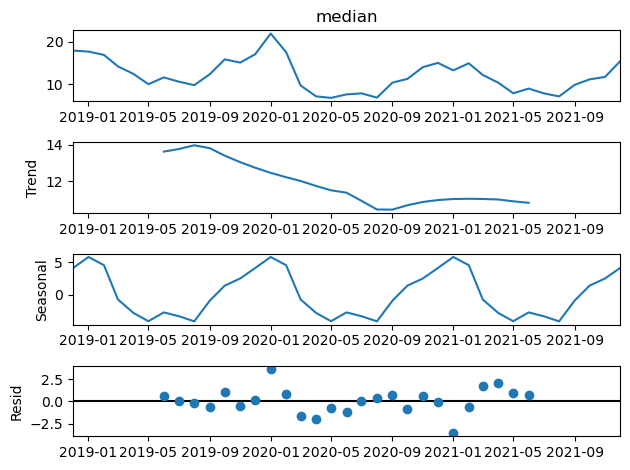

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.286505
         Iterations: 4
         Function evaluations: 215


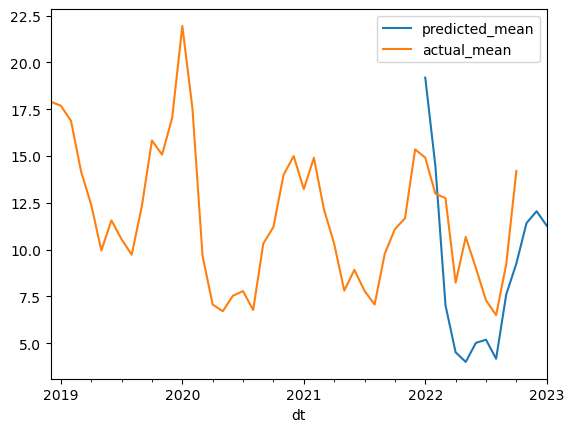





da 

not enough data for sarima!
tr 



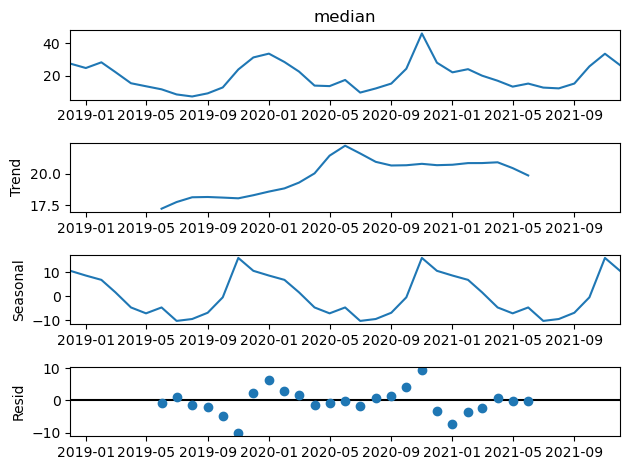

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 2.111032
         Iterations: 4
         Function evaluations: 233


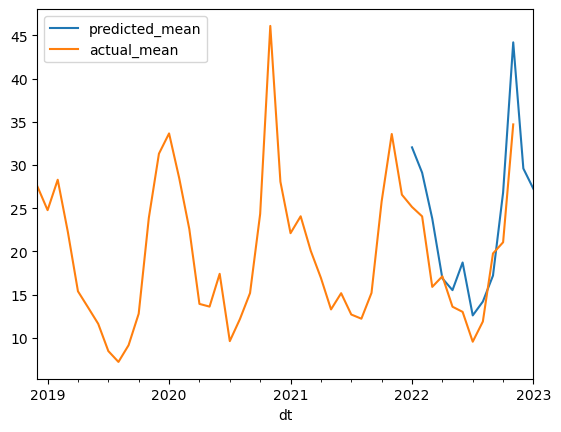





no 



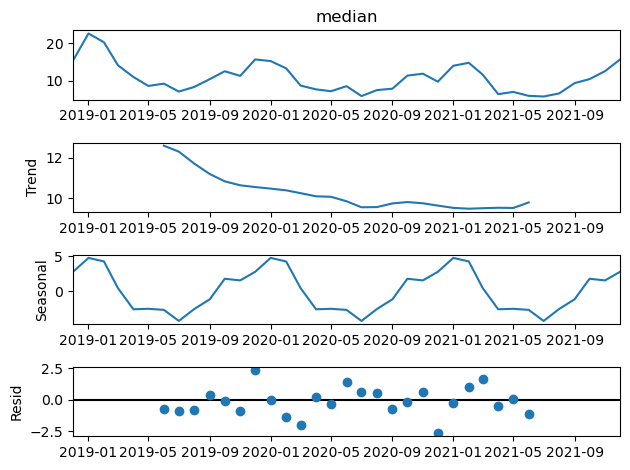

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.443961
         Iterations: 11
         Function evaluations: 554


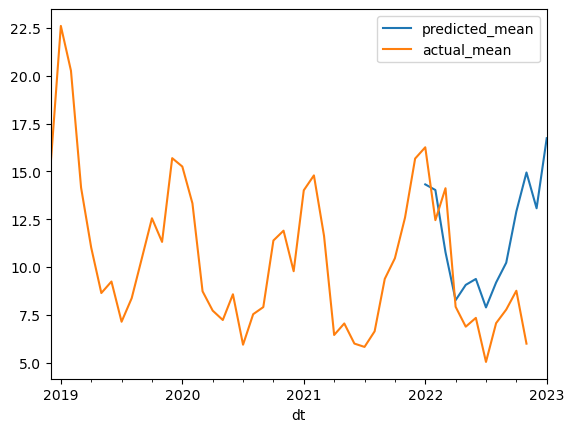





en 



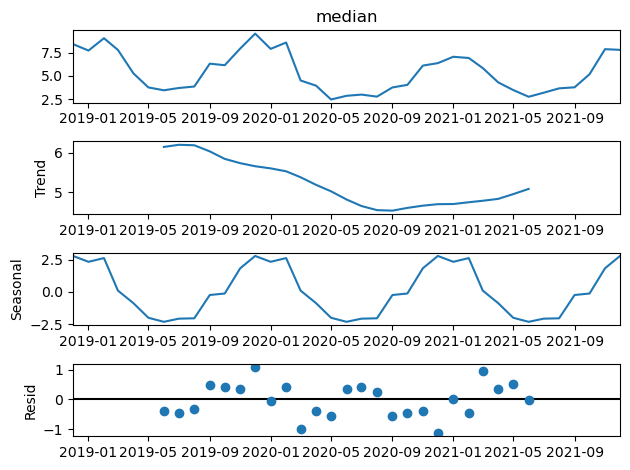

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 0.939573
         Iterations: 4
         Function evaluations: 213


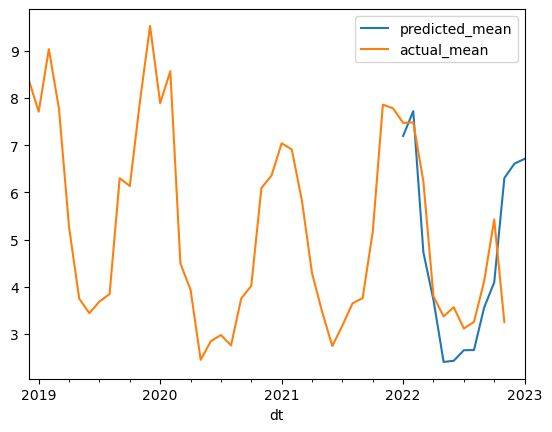





sr 



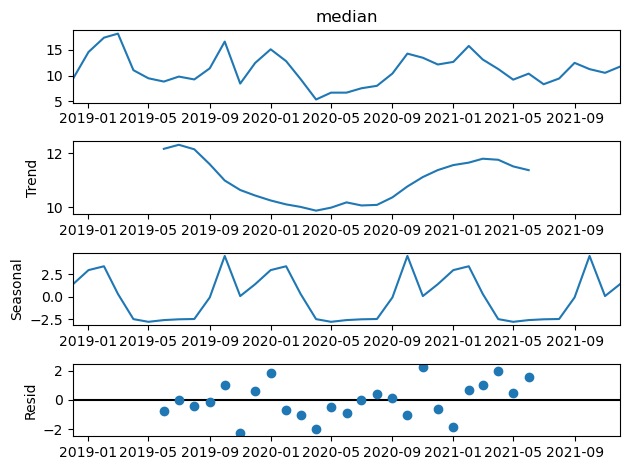

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.620008
         Iterations: 5
         Function evaluations: 260


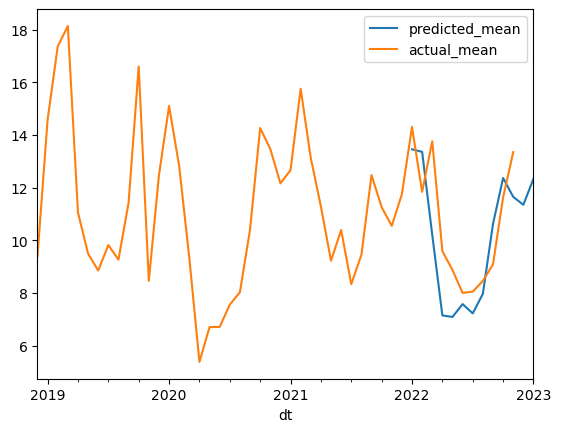





sv 



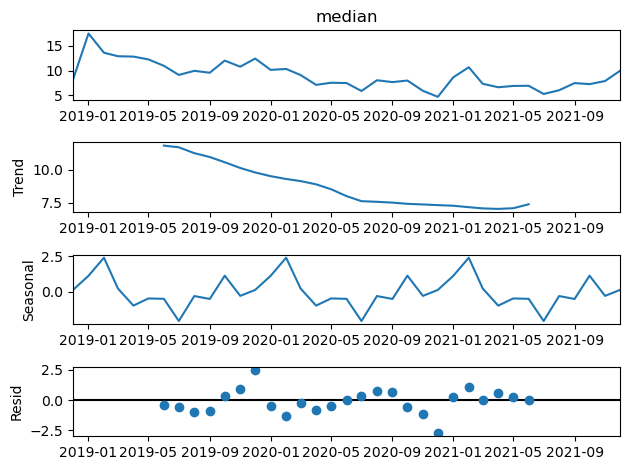

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.438406
         Iterations: 11
         Function evaluations: 559


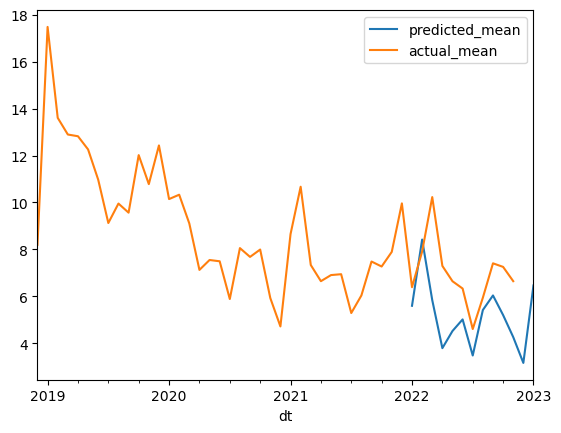





nl 



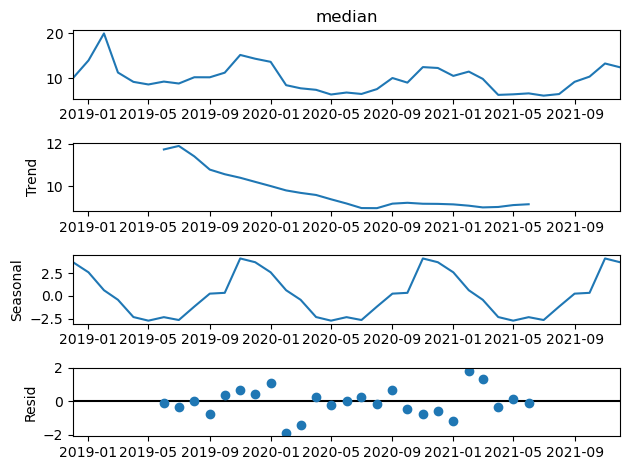

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.560792
         Iterations: 4
         Function evaluations: 200


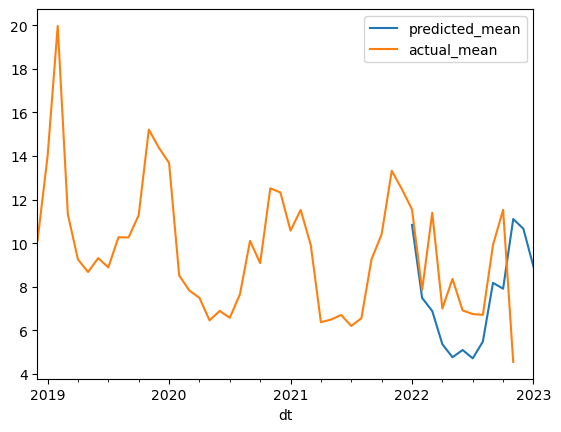





de 



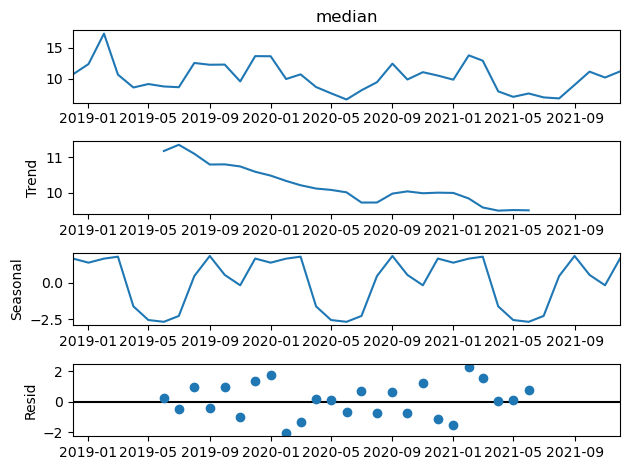

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.452367
         Iterations: 2
         Function evaluations: 155


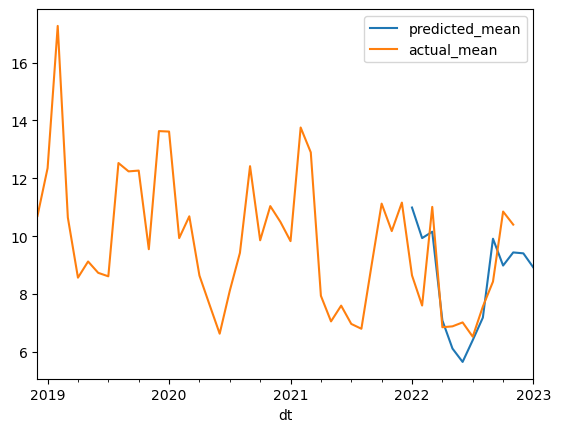





fr 



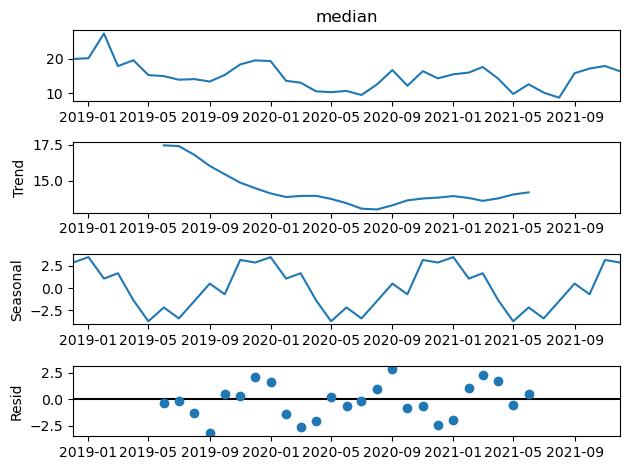

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.768095
         Iterations: 3
         Function evaluations: 145


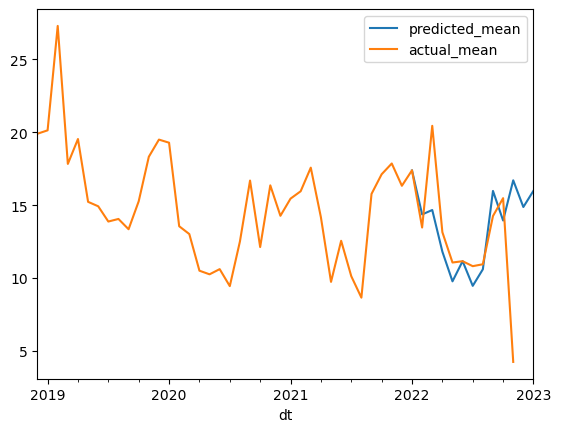





ca 



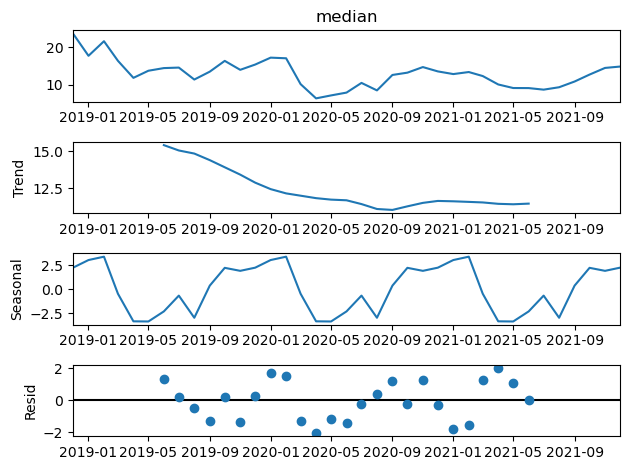

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.496687
         Iterations: 6
         Function evaluations: 302


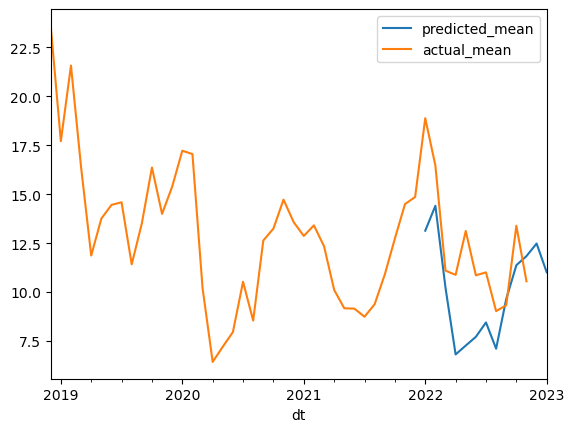





ko 



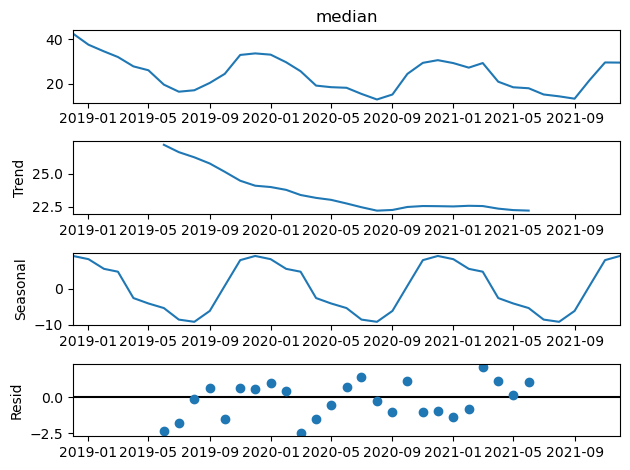

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.536552
         Iterations: 3
         Function evaluations: 134


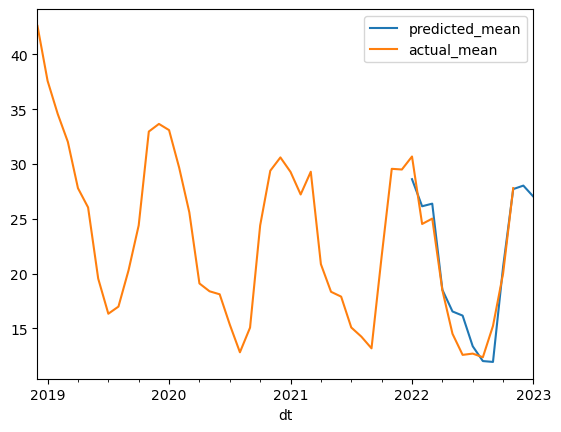





fi 



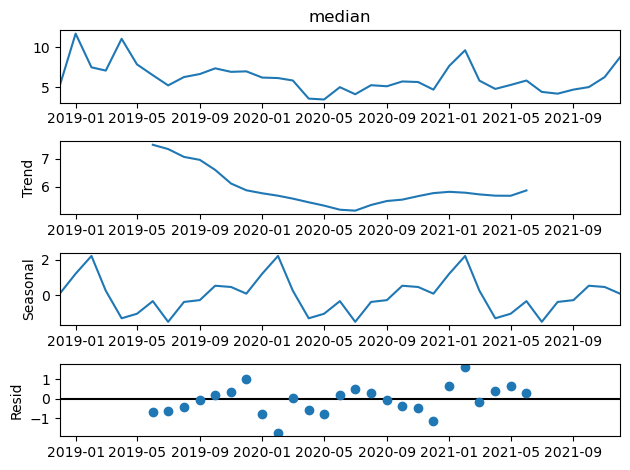

D:\Miniconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 1.440424
         Iterations: 14
         Function evaluations: 710


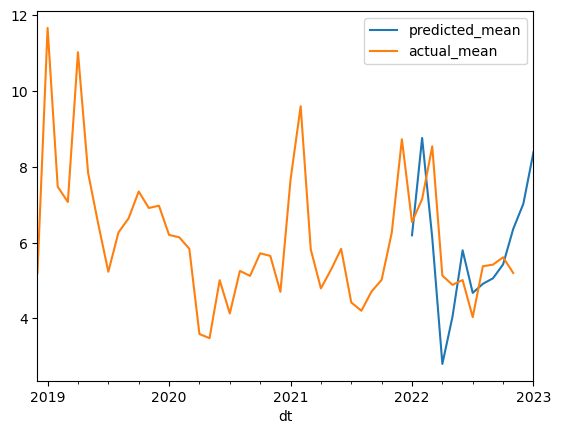

In [150]:
sarima_list = []
for country in country_codes : 
    try:
        print("=========================================================")
        print(country, "\n") 
        
        dataset = wikipedia_language_to_dataset[country][1].copy()
        dataset = dataset[dataset["dt"].dt.year <= 2021]
        dataset = dataset.set_index("dt")
        dataset = dataset["median"]
        decomposition = sm.tsa.seasonal_decompose(dataset.resample('MS').mean(), model='additive')
        fig = decomposition.plot()
        plt.show()

        mod = sm.tsa.statespace.SARIMAX(dataset.resample('MS').mean(),
                                        order=(0, 1, 1),
                                        seasonal_order=(1, 1, 1, 12))
        results = mod.fit(method = 'powell')

        pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), end = pd.to_datetime('2023-01-01'), dynamic=False)
        pred.predicted_mean.plot()
        dataset = wikipedia_language_to_dataset[country][1].copy()
        dataset = dataset.set_index("dt")
        dataset = dataset["median"]
        dataset = dataset.rename("actual_mean")
        dataset.resample('MS').mean().plot()
        plt.legend()
        plt.show()
        
        dataset_2022 = wikipedia_language_to_dataset[country][1]
        dataset_2022 = dataset_2022[dataset_2022["dt"].dt.year > 2021]
        dataset_2022 = dataset_2022.set_index("dt")
        dataset_2022 = dataset_2022["median"].resample('MS').mean()
        
        joined_true_and_pred = pd.concat([pred.predicted_mean, dataset_2022], axis = 1, join = 'inner')
        mae = mean_absolute_error(joined_true_and_pred["median"], joined_true_and_pred["predicted_mean"])
        
        expectedMean = dataset_2022.mean()
        predMean = pred.predicted_mean.mean()
        relative_diff = (
            "{:+.2f}".format(
                ((predMean / expectedMean) - 1) * 100
            )+ "%"
        )
        sarima_list.append((country, expectedMean, predMean, relative_diff, mae))
        print("\n\n\n")
    except:
        print("not enough data for sarima!")
        continue

In [151]:
sarimaDf = pd.DataFrame(sarima_list, columns = ["Country", "expected", "prediction", "relative_diff", "mae"])

In [152]:
sarimaDf

Country   expected  prediction relative_diff       mae
0       ja  11.476385   13.132375       +14.43%  1.568631
1       it  10.580733    8.862446       -16.24%  3.686337
2       tr  18.702739   23.680719       +26.62%  4.628633
3       no   9.059826   11.602469       +28.07%  2.903168
4       en   4.644234    4.676492        +0.69%  0.926752
5       sr  10.634512   10.183984        -4.24%  1.440885
6       sv   6.972206    5.175545       -25.77%  1.824693
7       nl   8.409746    7.492337       -10.91%  2.527357
8       de   8.344909    8.475869        +1.57%  1.156068
9       fr  12.947547   13.594086        +4.99%  2.428310
10      ca  12.236089   10.111393       -17.36%  2.713442
11      ko  19.439387   20.998843        +8.02%  1.428311
12      fi   5.718714    5.813197        +1.65%  1.011720

Here, we have fairly binary results : 
- Either the country has an actual pollution that is lower than the prediction (Japan, Turkey, Norway, the U.S., Germany, France, Korea, Finland). The country that has the largest MAE is in this category: it is Turkey, which has a massive drop in air pollution in 2022, while its trend was increasing before that year.
- Or it has an actual pollution that is higher than the prediction (Italy, Serbia, Sweden, the Netherlands, Catalonia). In this case, the largest difference between the actual pollution is Sweden, which is explained by noticing that the values for Sweden are usually really low, and that there is an small, unexplained peak in the air pollution in 2022. This is seen in the Sarima trends graph of the country. Most countries in this category behave this way.

We also note that Denmark is the only country with a full month of data missing, so it is not included in this study. 

We can conclude in the following way :
For most countries, it holds that either the model predicts a higher pollution than reality for 2022 or the country emissions were already fairly low. This, in turn, suggests that humans were indeed taught a lesson by Covid in terms of climate change.

# Conclusion

If one looked only at the environment Wikipedia views, the image would be quite dark: people didn’t seem to necessarily care more about that topic during the wave, as any increase, is strongly correlated to the overall page views.

If the topic was one of the most visited, that would be okay, but that’s not even the case, as a matter of fact, it’s always at least in the 20 least visited topics. Not only that, but extending the Coronawiki data shows that people visit the environment pages even less in 2021 and 2022.

However, the air pollution dataset enables us to argue that pollution indeed decreased overall during and after the 2020 Covid wave. This is further supported by the SARIMA modeling, which typically predicts more pollution for 2022 than actually happened.

All in all, we seem to be heading into a bad ending. While it is true that the pollution is getting better over time for now, the fact that awareness about the pollution decreases suggests that the decrease in pollution is only temporary and not a global effort to tackle climate change.

That leaves the question of how to improve things. One may observe that awareness on Wikipedia has decreased while media attention is ever-growing about climate change issues. Then, we can only hope that this newly-formed attention is beneficial to public knowledge about the issue and that it will lead to actual durable improvements to the current situation. 